Bachelor thesis Data Mining
Bielefeld University
Lukas Wüppelmann

## Pytorch setup

In [ ]:
%pip install torch


  Using cached typing_extensions-4.12.2-py3-none-any.whl.metadata (3.0 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ---------------------------------------- 0.0/199.4 MB ? eta -:--:--
   ---------------------------------------- 0.8/199.4 MB 17.0 MB/s eta 0:00:12
   ---------------------------------------- 2.1/199.4 MB 22.4 MB/s eta 0:00:09
    --------------------------------------- 3.4/199.4 MB 24.1 MB/s eta 0:00:09
    --------------------------------------- 3.7/199.4 MB 19.9 MB/s eta 0:00:10
   - -------------------------------------- 6.0/199.4 MB 25.6 MB/s eta 0:00:08
   - -------------------------------------- 7.3/199.4 MB 25.8 MB/s eta 0:00:08
   - -------------------------------------- 8.6/199.4 MB 26.1 MB/s eta 0:00:08
   - -------------------------------------- 9.9/199.4 MB 26.2 MB/s eta 0:00:08
   -- ------------------------------------- 11.1/199.4 MB 27.3 MB/s eta 0:00:07
   -- ------------------------------------- 12.3/199.4 MB 27.3 MB/s eta 0:00:0

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## Generated Dataset
The file `partial_credit_data` contains Data of of students and tasks where every column represents a student and every row a task with possible point range [0,3]

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# our data set models a fictional class of students completing a
# number of tasks and is samples from a ground truth 2-PL IRT model
# BUT with a twist, namely that the ground truth ability is actually
# two-dimensional, not uni-dimensional. Still, the abilities are
# correlated, so that a uni-dimensional construct can cover the data
# quite well.

N = 100

# here is our Q matrix
Q = np.array([
   [2., 0.],
   [0., 2.],
   [1., 0.2],
   [0.2, 1.],
   [1., 0.5],
   [0.5, 1.],
   [1., 1.]
])

# here our difficulties for each achievable point value
B = np.array([
   [-1., 0., 2.],
   [-1., 0., 2.],
   [-1, 0.5, 1.5],
   [-1, 0.5, 1.5],
   [0.7, 1., 2.],
   [0.7, 1., 2.],
   [0.5, 1.5, 1.8]
])


A = 4


In [31]:
abilities = np.random.randn(N, 2)

# compute the logit success probabilities of every student on every task
Z = np.zeros((N, B.shape[0], B.shape[1] + 1))
for i in range(N):
   Z[i, :, 1:] = (np.expand_dims(np.dot(abilities[i, :], Q.T), 1) - B) * A

Z = np.cumsum(Z, axis = 2)

# compute probabilities
P = np.exp(Z) / np.expand_dims(np.sum(np.exp(Z), axis = 2), 2)

# sample actual data
X = np.zeros((N, B.shape[0]))
for i in range(N):
   for j in range(B.shape[0]):
     X[i, j] = np.random.choice(B.shape[1]+1, p = P[i, j, :], size = 1)

np.savetxt('partial_credit_data.csv', X, fmt = '%g', delimiter = '\t',
encoding = 'utf-8')

C:\Users\wuepp\AppData\Local\Temp\ipykernel_18216\431169652.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X[i, j] = np.random.choice(B.shape[1]+1, p = P[i, j, :], size = 1)


In [32]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split

X = np.loadtxt('partial_credit_data.csv', delimiter = '\t', dtype=int)

# Die Daten in Training und Validierung aufteilen (z.B. 80% Training, 20% Validierung)
X, X_val = train_test_split(X, test_size=0.2, random_state=42)
N, m = X.shape
print(X)

print("number of students: " + str(N))
print("number of tasks: " + str(m))

[[2 0 2 1 0 0 0]
 [3 2 2 2 2 2 2]
 [3 0 2 0 2 0 0]
 [1 2 1 1 0 0 0]
 [1 0 1 0 0 0 0]
 [2 2 2 2 2 1 1]
 [0 2 0 1 0 0 0]
 [2 1 1 0 0 0 0]
 [0 0 1 0 0 0 0]
 [2 3 2 3 2 2 3]
 [2 3 1 2 1 1 1]
 [2 0 1 1 0 0 0]
 [0 0 1 0 0 0 0]
 [2 1 2 1 0 0 0]
 [3 1 3 1 2 0 3]
 [3 2 2 2 2 1 1]
 [1 2 1 1 0 0 0]
 [2 2 2 2 1 1 1]
 [1 3 0 2 0 0 0]
 [3 3 3 3 3 3 3]
 [0 1 0 1 0 0 0]
 [0 3 1 2 0 2 1]
 [2 2 1 1 0 0 0]
 [3 2 3 1 2 2 1]
 [0 3 0 3 0 3 2]
 [2 0 1 0 0 0 0]
 [0 2 0 1 0 0 0]
 [1 0 1 1 0 0 0]
 [0 2 0 2 0 0 0]
 [0 1 0 1 0 0 0]
 [0 2 0 1 0 0 0]
 [3 3 2 2 3 2 3]
 [1 1 1 1 0 0 0]
 [2 0 2 2 0 0 0]
 [0 1 0 1 0 0 0]
 [3 2 2 1 2 0 2]
 [0 1 1 1 0 0 0]
 [2 3 2 2 0 0 1]
 [1 0 1 0 0 0 0]
 [2 0 2 0 0 0 0]
 [1 0 1 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 3 0 3 0 1 1]
 [2 0 1 1 0 0 0]
 [3 2 3 2 1 2 3]
 [2 0 2 1 1 0 0]
 [2 2 2 1 1 2 1]
 [1 0 1 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 1 0 1 0 0 0]
 [3 0 3 1 2 1 1]
 [0 2 1 2 0 2 1]
 [2 2 3 3 2 2 2]
 [0 2 1 2 0 0 0]
 [1 2 1 2 0 1 1]
 [3 1 1 1 1 0 0]
 [1 3 1 3 0 2 1]
 [2 2 2 2 2 1 

## IRT no PC

In [ ]:
import torch

class IRTModel(torch.nn.Module):
    """The initialization method of a pytorch module. Here, we should set all hyperparameters
    of the model, such as the regularization strength.

    Parameters
    ----------
    C: float (default = 1000)
        The inverse of the L2 regularization strength.
    num_epochs: int (default = 1000)
        How many times we iterate over the data set during training.
    learning_rate: float (default = 1E-2)
        The learning rate of our optimizer during training.
    """
    def __init__(self, C = 1000, num_epochs = 1000, learning_rate = 1E-2):
        # We call the torch.nn.Module constructor
        super(IRTModel, self).__init__()
        # Then, we store all hyperparameters as attributes of the model
        self.C_ = C
        self.num_epochs_ = num_epochs
        self.learning_rate_ = learning_rate

    """Predicts responses based on the learned parameters.
    
    Parameters
    ----------
    X: np.ndarray
        A matrix where each row represents a student and each column represents a task.
        The entry X[i, j] is expected to be 0 if student i failed task j and to be 1
        if student i passed task j.

    Returns
    -------
    Z: torch.tensor
        A matrix where each row represents a student and each column represents a task.
        The entry Z[i, j] represents the logit probability of student i passing task j.
    
    """
    def predict_logits(self, X = None):
        # the logits correspond to the difference of abilities and difficulties.
        # The 'unsqueeze' method transforms the abilities vector from an N-entry
        # vector to an (N, 1)-matrix and the difficulties vector from an m-entry
        # vector to an (1, m)-matrix, such that the difference - thanks to the
        # magic of broadcasting - yields a (N, m) matrix.
        Z = self.abilities_.unsqueeze(1) - self.difficulties_.unsqueeze(0)
        return Z

    """Predicts responses based on the learned parameters.
    
    Parameters
    ----------
    X: np.ndarray
        A matrix where each row represents a student and each column represents a task.
        The entry X[i, j] is expected to be 0 if student i failed task j and to be 1
        if student i passed task j.

    Returns
    -------
    Xhat: np.ndarray
        A matrix where each row represents a student and each column represents a task.
        The entry Xhat[i, j] is 1 if the model predicts student i to pass task j and 0
        otherwise.
    
    """
    def predict(self, X = None):
        Z = self.predict_logits()
        Xhat = torch.zeros_like(Z)
        Xhat[Z > 0.] = 1.
        return Xhat.detach().numpy()

    """Fits this model to the given data matrix.

    Parameters
    ----------
    X: np.ndarray
        A matrix where each row represents a student and each column represents a task.
        The entry X[i, j] is expected to be 0 if student i failed task j and to be 1
        if student i passed task j.

    """
    def fit(self, X):
        # convert the input matrix to a pytorch tensor
        X = torch.tensor(X, dtype=torch.float)
        # initialize our model parameters based on passing rates, meaning:
        # students have higher initial ability if they get more tasks right and
        # items have higher initial difficulty if less students get them right.
        self.abilities_    = torch.nn.Parameter(torch.mean(X, 1).detach() - 0.5)
        self.difficulties_ = torch.nn.Parameter(0.5 - torch.mean(X, 0).detach())
        # initialize optimizer with the right learning rate and regularization strength
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate_, weight_decay=1./self.C_)
        # start training
        for epoch in range(self.num_epochs_):
            # re-set the current gradient to zero
            optimizer.zero_grad()
            # predict the logit passing probabilities for each student-item combination
            # with the current model
            Z = self.predict_logits()
            # compute the loss between predicted and desired answers using the crossentropy loss
            loss = torch.nn.functional.binary_cross_entropy_with_logits(Z, X)
            # report the loss every 100 steps
            if (epoch+1) % 100 == 0:
                print('epoch %d: loss %g' % (epoch+1, loss.item()))
            # compute the gradient
            loss.backward()
            # apply the optimizer
            optimizer.step()
        
        return self

In [83]:
model_pytorch = IRTModel()
model_pytorch.fit(X)
Xhat = model_pytorch.predict(X)
accuracy = np.mean(Xhat == X)
print(f'Accuracy: {accuracy:.2f}')
print(Xhat)


epoch 100: loss -0.901313
epoch 200: loss -1.39042
epoch 300: loss -1.79679
epoch 400: loss -2.14637
epoch 500: loss -2.45288
epoch 600: loss -2.72582
epoch 700: loss -2.97245
epoch 800: loss -3.19838
epoch 900: loss -3.40794
epoch 1000: loss -3.60444
Accuracy: 0.43
[[1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 0. 0. 0.]]


## VAE

### Models

In [23]:
import torch
import torch.nn.functional as F

class VAE(torch.nn.Module):
    def __init__(self, num_inputs, num_neurons, num_latent, num_categories):
        super(VAE, self).__init__()
        self.num_categories = num_categories
        self.n_ = num_latent
        self.enc1 = torch.nn.Linear(num_inputs, num_neurons)
        self.enc2 = torch.nn.Linear(num_neurons, 2 * num_latent)
        self.dec1 = torch.nn.Linear(num_latent, num_neurons)
        self.dec2 = torch.nn.Linear(num_neurons, num_inputs)

    def forward(self, X):
        # Encoding
        H_enc = torch.nn.functional.relu(self.enc1(X))
        Mu_and_LogSigma = self.enc2(H_enc)
        Mu = Mu_and_LogSigma[:, :self.n_]
        LogSigma = Mu_and_LogSigma[:, self.n_:]
        # Sampling
        Z = Mu + torch.exp(LogSigma) * torch.randn_like(Mu)
        # Decoding
        H_dec = torch.nn.functional.relu(self.dec1(Z))
        Y = self.dec2(H_dec)
        # Scaling the output to 0-3 range
        Y = torch.sigmoid(Y) * (self.num_categories - 1)
        return Mu, LogSigma, Z, Y

    def fit(self, X):
        # Initialize everything before training
        learning_rate = 1E-3
        num_epochs = 10000
        lambda_ = 0.1
        X = torch.tensor(X, dtype=torch.float)
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        loss_values = []
        
        # Start training
        for epoch in range(num_epochs):
            # Reset the current gradient to zero
            optimizer.zero_grad()
            # Autoencode the data
            Mu, LogSigma, Z, Y = self.forward(X)
            # Compute the loss function
            neg_log_pz = 0.5 * torch.sum(torch.square(Z))
            neg_log_qzx = torch.sum(LogSigma)
            neg_log_pxz = 0.5 / lambda_ ** 2 * torch.sum(torch.square(X - Y))
            loss = neg_log_pxz + neg_log_pz - neg_log_qzx
            loss_values.append(loss.item())
            # Compute the gradient via backpropagation
            loss.backward()
            # Apply the optimizer
            optimizer.step()
            
        # Plot the loss curve
        plt.plot(loss_values)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss Curve')
        plt.show()

In [20]:
import torch
import torch.nn.functional as F
import numpy as np
import numpy as np
import matplotlib.pyplot as plt

class PC_IRT_AE(torch.nn.Module):
    def __init__(self, num_inputs, num_neurons, num_latent, num_categories, noise = 0.5, regul = 0.5, monotonic_penalty_parameter = 300, q_penalty_parameter = 200, q_value_penalty_parameter = 0):
        super(PC_IRT_AE, self).__init__()
        self.q_value_penalty_parameter = q_value_penalty_parameter
        self.q_penalty_parameter = q_penalty_parameter
        self.monotonic_penalty_parameter = monotonic_penalty_parameter
        self.noise = noise
        self.regul = regul
        self.num_inputs = num_inputs
        self.num_latent = num_latent
        self.num_categories = num_categories
        self.enc1 = torch.nn.Linear(num_inputs, num_neurons)
        self.enc2 = torch.nn.Linear(num_neurons, 2 * num_latent)
        #self.dec1 = torch.nn.Linear(num_latent, num_neurons)
        #self.dec2 = torch.nn.Linear(num_latent, num_inputs)
        # Definiere eine Matrix für Diskriminationsparameter (Q)
        self.Q = torch.nn.Parameter(torch.abs(torch.randn(num_latent, num_inputs)))

        # Diskriminationsparameter und Schwellenwerte initialisieren
        self.a = torch.nn.Parameter(torch.ones(num_inputs))  # Diskriminationsparameter
        #self.a_pos = torch.exp(self.a)  # Exponentiation ensures positivity
        self.b = torch.nn.Parameter(torch.randn(num_inputs, num_categories - 1))  # Schwellenwerte
        #self.b_aufsteigend = torch.cumsum(torch.cat([self.b[:, :1], F.softplus(self.b[:, 1:])], dim=1), dim=1)  # Ensure b is monotonically increasing

    def forward(self, X):
        # Encoding
        H_enc = torch.relu(self.enc1(X))
        Mu_and_LogSigma = self.enc2(H_enc)
        Mu = Mu_and_LogSigma[:, :self.num_latent]
        LogSigma = Mu_and_LogSigma[:, self.num_latent:]
        # Sampling
        # eventuell noise parameter 10e-2
        theta = Mu + torch.exp(LogSigma) * torch.randn_like(Mu)*self.noise
        # Decoding
        #H_dec = torch.relu(self.dec1(Z))
        
        #raw_logits = self.dec2(theta)  # Fähigkeitsschätzung
        #nich constrainter layer bis jetzt
        #print(raw_logits)

        #Apply softplus to ensure Q is positive
        #learned_Q = torch.nn.functional.softplus(self.Q)
        
        #Apply ReLU
        #learned_Q = torch.relu(self.Q)

        # Matrix-basiertes Decoding
        raw_logits = torch.matmul(theta, self.Q)  # Matrixmultiplikation

        # Initialisiere eine leere Liste für die Logits (logarithmischen Wahrscheinlichkeiten)
        logits = []

        #a_pos = torch.exp(self.a)  # Exponentiation ensures positivity
        #b_aufsteigend = torch.cumsum(torch.cat([self.b[:, :1], F.softplus(self.b[:, 1:])], dim=1), dim=1)  # Ensure b is monotonically increasing
        
        # Schleife über die Anzahl der Inputs (Items im Test)
        for i in range(self.num_inputs):
            # Initialisiere eine leere Liste für die Logits eines einzelnen Items
            item_logits = []
            
            # Schleife über die Kategorien des aktuellen Items
            for k in range(self.num_categories):
                if k == 0:
                    # Für die erste Kategorie (k = 0) setzen wir die Logits auf Null
                    item_logits.append(torch.zeros_like(raw_logits[:, i]))
                else:
                    # Berechne die Logits für die restlichen Kategorien
                    # Die Logits sind kumulativ, d.h., sie basieren auf den vorherigen Logits
                    item_logits.append((raw_logits[:, i] - self.b[i, k-1]) * self.a[i] + item_logits[-1])
            
            # Füge die Logits des aktuellen Items zur Liste hinzu, und stacke sie entlang der letzten Dimension
            logits.append(torch.stack(item_logits, dim=-1))

        # Stacke die Logits aller Items entlang der zweiten Dimension
        logits = torch.stack(logits, dim=1)
        # Wende die Softmax-Funktion auf die Logits an, um die Wahrscheinlichkeitsverteilung über die Kategorien zu erhalten
        Y = torch.softmax(logits, dim=-1)

        # Gib die anderen Variablen und die Wahrscheinlichkeiten zurück
        return Mu, LogSigma, theta, Y
    
    def decode(self, theta):
        # Decoding only
        # Matrix-based decoding
        raw_logits = torch.matmul(theta, self.Q)  # Matrix multiplication

        # Initializing an empty list for logits
        logits = []

        # Loop over the number of inputs (tasks)
        for i in range(self.num_inputs):
            # Initializing an empty list for the logits of a single item
            item_logits = []

            # Loop over categories for the current item
            for k in range(self.num_categories):
                if k == 0:
                    # For the first category (k = 0), set logits to zero
                    item_logits.append(torch.zeros_like(raw_logits[:, i]))
                else:
                    # Calculate logits for remaining categories
                    item_logits.append((raw_logits[:, i] - self.b[i, k - 1]) * self.a[i] + item_logits[-1])

            # Add the logits for the current item to the list
            logits.append(torch.stack(item_logits, dim=-1))

        # Stack logits for all items along the second dimension
        logits = torch.stack(logits, dim=1)
        # Apply softmax to logits to get probabilities
        Y = torch.softmax(logits, dim=-1)

        return Y
    
    
        
        """
        logits = []

        for i in range(self.num_inputs):
            item_logits = []
            
            # Neue Berechnung: raw_logits_item repräsentiert den Einfluss der latenten Fähigkeiten
            raw_logits_item = torch.sum(theta * self.a[i], dim=1)
            
            for k in range(self.num_categories):
                if k == 0:
                    item_logits.append(torch.zeros_like(raw_logits_item))
                else:
                    # Berechne die Logits unter Berücksichtigung der Schwellenwerte b
                    item_logits.append((raw_logits_item - self.b[i, k-1]) + item_logits[-1])
            
            logits.append(torch.stack(item_logits, dim=-1))

        logits = torch.stack(logits, dim=1)
        Y = torch.softmax(logits, dim=-1)

        return Mu, LogSigma, theta, Y
        """



    def fit(self, X):
        # Initialize everything before training
        learning_rate = 1E-3
        num_epochs = 10000
        X = torch.tensor(X, dtype=torch.float)
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        loss_values = []
        
        # Start training
        for epoch in range(num_epochs):
            optimizer.zero_grad()
            Mu, LogSigma, theta, Y = self.forward(X)
            
            # Compute the loss function
            neg_log_pz = 0.5 * torch.sum(theta ** 2)
            # Mu and LogSigma are the outputs of the model representing the mean and log-variance
            # Convert LogSigma to the actual variance (sigma^2)
            sigma2 = torch.exp(LogSigma)  # Variance from LogSigma
            mu2 = Mu ** 2  # Square of the mean
            neg_log_qzx = torch.sum(LogSigma)
            
            #X_onehot = F.one_hot(X.long(), num_classes=self.num_categories).float()
            #neg_log_pxz = -torch.sum(X_onehot * torch.log(Y + 1e-10))
            
            # Compute negative log-likelihood without one-hot encoding
            # X is assumed to be integer-encoded
            X_int = X.squeeze().to(torch.long)  # Remove unnecessary dimensions if needed
            # Use torch.gather to select the probabilities corresponding to the true classes
            true_probs = torch.gather(Y, dim=-1, index=X_int.unsqueeze(-1)).squeeze(-1)
            neg_log_pxz = -torch.sum(torch.log(true_probs + 1e-10))  # Adding epsilon to avoid log(0)
            
            
            #original_loss = neg_log_pxz + neg_log_pz - neg_log_qzx

            # Monotonicity penalty
            diffs = self.b[:, 1:] - self.b[:, :-1]
            mono_penalty = torch.sum(F.relu(-diffs))

            # Penalize negative values in Q
            q_penalty = torch.sum(F.relu(-self.Q))

            # Penalize positive values in Q
            q_l1_penalty = torch.sum(F.relu(self.Q))


            loss = neg_log_pxz + (neg_log_pz - neg_log_qzx) * self.regul + self.monotonic_penalty_parameter * mono_penalty + self.q_penalty_parameter * q_penalty + q_l1_penalty * self.q_value_penalty_parameter
            loss_values.append(loss.item())
            
            loss.backward()
            optimizer.step()

            if (epoch % 100 == 0):
                print(f"Epoch {epoch}, Loss: {loss.item()}")

        # Plot the loss curve
        plt.plot(loss_values)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss Curve')
        plt.show()


### metrics functions

In [18]:
import numpy as np
import torch
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, cohen_kappa_score

def cross_validate_VAE(X, model_class, num_inputs, num_neurons, num_latent, num_categories, num_folds=5, random_state=42):
    # Initialize KFold
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=random_state)

    # Lists to store metrics for each fold
    train_accuracies, val_accuracies = [], []
    train_maes, val_maes = [], []
    train_mses, val_mses = [], []
    train_kappas, val_kappas = [], []

    # Cross-validation loop
    for fold, (train_index, val_index) in enumerate(kf.split(X)):
        print(f"Cross-validation for fold: {fold + 1}")

        # Split data into training and validation sets
        X_train, X_val = X[train_index], X[val_index]

        # Convert input to tensor
        X_train_tensor = torch.tensor(X_train, dtype=torch.float)
        X_val_tensor = torch.tensor(X_val, dtype=torch.float)

        # Initialize the model
        model = model_class(num_inputs=num_inputs, num_neurons=num_neurons, num_latent=num_latent, num_categories=num_categories)

        # Train the model
        model.fit(X_train_tensor)

        # Evaluate on training set
        _, _, _, Xhat_train_tensor = model.forward(X_train_tensor)
        Xhat_train = Xhat_train_tensor.round().detach().numpy()

        # Compute training metrics
        accuracy_train = np.mean(X_train_tensor.numpy() == Xhat_train)
        mae_train = mean_absolute_error(X_train_tensor.numpy(), Xhat_train)
        mse_train = mean_squared_error(X_train_tensor.numpy(), Xhat_train)
        kappa_train = cohen_kappa_score(X_train_tensor.numpy().ravel(), Xhat_train.ravel(), weights='quadratic')

        # Store training results
        train_accuracies.append(accuracy_train)
        train_maes.append(mae_train)
        train_mses.append(mse_train)
        train_kappas.append(kappa_train)

        print(f"Training Accuracy: {accuracy_train}")
        print(f"Training Mean Absolute Error: {mae_train}")
        print(f"Training Mean Squared Error: {mse_train}")
        print(f"Training Quadratic Weighted Kappa: {kappa_train}")

        # Evaluate on validation set
        _, _, _, Xhat_val_tensor = model.forward(X_val_tensor)
        Xhat_val = Xhat_val_tensor.round().detach().numpy()

        # Compute validation metrics
        accuracy_val = np.mean(X_val_tensor.numpy() == Xhat_val)
        mae_val = mean_absolute_error(X_val_tensor.numpy(), Xhat_val)
        mse_val = mean_squared_error(X_val_tensor.numpy(), Xhat_val)
        kappa_val = cohen_kappa_score(X_val_tensor.numpy().ravel(), Xhat_val.ravel(), weights='quadratic')

        # Store validation results
        val_accuracies.append(accuracy_val)
        val_maes.append(mae_val)
        val_mses.append(mse_val)
        val_kappas.append(kappa_val)

        print(f"Validation Accuracy: {accuracy_val}")
        print(f"Validation Mean Absolute Error: {mae_val}")
        print(f"Validation Mean Squared Error: {mse_val}")
        print(f"Validation Quadratic Weighted Kappa: {kappa_val}")

        print("-" * 50)

    # Compute average and standard deviation of metrics across all folds
    print("Cross-Validation Performance Summary:")
    print(f"Average Training Accuracy: {np.mean(train_accuracies)} ± {np.std(train_accuracies)}")
    print(f"Average Validation Accuracy: {np.mean(val_accuracies)} ± {np.std(val_accuracies)}")
    print(f"Average Training MAE: {np.mean(train_maes)} ± {np.std(train_maes)}")
    print(f"Average Validation MAE: {np.mean(val_maes)} ± {np.std(val_maes)}")
    print(f"Average Training MSE: {np.mean(train_mses)} ± {np.std(train_mses)}")
    print(f"Average Validation MSE: {np.mean(val_mses)} ± {np.std(val_mses)}")
    print(f"Average Training Quadratic Weighted Kappa: {np.mean(train_kappas)} ± {np.std(train_kappas)}")
    print(f"Average Validation Quadratic Weighted Kappa: {np.mean(val_kappas)} ± {np.std(val_kappas)}")

# Example usage:
# cross_validate(X, VAE, num_inputs=10, num_neurons=128, num_latent=2, num_categories=5)


def cross_validate_PC_VAE(X, model_class, num_inputs, num_neurons, num_latent, num_categories, num_folds=5, random_state=42):

    import numpy as np
    import torch
    from sklearn.model_selection import KFold
    from sklearn.metrics import mean_absolute_error, mean_squared_error, cohen_kappa_score
      
    # Initialize KFold
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=random_state)

    # Lists to store metrics for each fold
    train_accuracies, val_accuracies = [], []
    train_maes, val_maes = [], []
    train_mses, val_mses = [], []
    train_kappas, val_kappas = [], []

    # Cross-validation loop
    for fold, (train_index, val_index) in enumerate(kf.split(X)):
        print(f"Cross-validation for fold: {fold + 1}")

        # Split data into training and validation sets
        X_train, X_val = X[train_index], X[val_index]

        # Convert input to tensor
        X_train_tensor = torch.tensor(X_train, dtype=torch.float)
        X_val_tensor = torch.tensor(X_val, dtype=torch.float)

        # Initialize the model
        model = model_class(num_inputs=num_inputs, num_neurons=num_neurons, num_latent=num_latent, num_categories=num_categories)

        # Train the model
        model.fit(X_train_tensor)

        # Evaluate on training set
        _, _, _, Xhat_train_tensor = model.forward(X_train_tensor)
        Xhat_train = torch.argmax(Xhat_train_tensor, dim=-1).detach().numpy()

        # Compute training metrics
        accuracy_train = np.mean(X_train_tensor.numpy() == Xhat_train)
        mae_train = mean_absolute_error(X_train_tensor.numpy(), Xhat_train)
        mse_train = mean_squared_error(X_train_tensor.numpy(), Xhat_train)
        kappa_train = cohen_kappa_score(X_train_tensor.numpy().ravel(), Xhat_train.ravel(), weights='quadratic')

        # Store training results
        train_accuracies.append(accuracy_train)
        train_maes.append(mae_train)
        train_mses.append(mse_train)
        train_kappas.append(kappa_train)

        print(f"Training Accuracy: {accuracy_train}")
        print(f"Training Mean Absolute Error: {mae_train}")
        print(f"Training Mean Squared Error: {mse_train}")
        print(f"Training Quadratic Weighted Kappa: {kappa_train}")

        # Evaluate on validation set
        _, _, _, Xhat_val_tensor = model.forward(X_val_tensor)
        Xhat_val = torch.argmax(Xhat_val_tensor, dim=-1).detach().numpy()

        # Compute validation metrics
        accuracy_val = np.mean(X_val_tensor.numpy() == Xhat_val)
        mae_val = mean_absolute_error(X_val_tensor.numpy(), Xhat_val)
        mse_val = mean_squared_error(X_val_tensor.numpy(), Xhat_val)
        kappa_val = cohen_kappa_score(X_val_tensor.numpy().ravel(), Xhat_val.ravel(), weights='quadratic')

        # Store validation results
        val_accuracies.append(accuracy_val)
        val_maes.append(mae_val)
        val_mses.append(mse_val)
        val_kappas.append(kappa_val)

        learned_Q = model.Q.detach().numpy()

        learned_Q_transposed = learned_Q.T

        # Heatmap erstellen
        plt.figure(figsize=(8, 6))
        plt.imshow(learned_Q_transposed, cmap='coolwarm', aspect='auto')

        # Colorbar hinzufügen
        plt.colorbar()

        # Achsenbeschriftungen und Titel
        plt.title('Learned Q Matrix Heatmap')
        plt.xlabel('Latent Dimensions')
        plt.ylabel('Questions')

        # Set y-ticks to start from 1 instead of 0
        plt.yticks(np.arange(learned_Q_transposed.shape[0]), np.arange(1, learned_Q_transposed.shape[0] + 1))

        # Zahlenwerte in die Heatmap einfügen
        for i in range(learned_Q_transposed.shape[0]):
            for j in range(learned_Q_transposed.shape[1]):
                plt.text(j, i, f'{learned_Q_transposed[i, j]:.2f}', ha='center', va='center', color='black')

        # Heatmap anzeigen
        plt.show()

        import numpy as np
        from numpy.linalg import norm
        from scipy.stats import pearsonr

        # Spaltenvektoren extrahieren
        v1 = learned_Q_transposed[:, 0]  # Erster Vektor (erste Spalte)
        v2 = learned_Q_transposed[:, 1]  # Zweiter Vektor (zweite Spalte)

        # 1. Winkel zwischen den beiden Vektoren berechnen
        cos_theta = np.dot(v1, v2) / (norm(v1) * norm(v2))  # Skalarprodukt / Produkt der Normen
        theta = np.arccos(np.clip(cos_theta, -1, 1))  # Winkel in Radiant (mit np.clip, um Rundungsfehler zu vermeiden)
        winkel_in_grad = np.degrees(theta)  # In Grad umrechnen

        # 2. Pearson-Korrelation zwischen den beiden Vektoren berechnen
        correlation, _ = pearsonr(v1, v2)

        # Ergebnisse ausgeben
        print(f"Winkel zwischen den beiden Vektoren: {winkel_in_grad:.2f} Grad")
        print(f"Pearson-Korrelationskoeffizient: {correlation:.2f}")

        print(f"Validation Accuracy: {accuracy_val}")
        print(f"Validation Mean Absolute Error: {mae_val}")
        print(f"Validation Mean Squared Error: {mse_val}")
        print(f"Validation Quadratic Weighted Kappa: {kappa_val}")


        print("-" * 50)
    
    # Compute average and standard deviation of metrics across all folds
    print("Cross-Validation Performance Summary:")
    print(f"Average Training Accuracy: {np.mean(train_accuracies)} ± {np.std(train_accuracies)}")
    print(f"Average Validation Accuracy: {np.mean(val_accuracies)} ± {np.std(val_accuracies)}")
    print(f"Average Training MAE: {np.mean(train_maes)} ± {np.std(train_maes)}")
    print(f"Average Validation MAE: {np.mean(val_maes)} ± {np.std(val_maes)}")
    print(f"Average Training MSE: {np.mean(train_mses)} ± {np.std(train_mses)}")
    print(f"Average Validation MSE: {np.mean(val_mses)} ± {np.std(val_mses)}")
    print(f"Average Training Quadratic Weighted Kappa: {np.mean(train_kappas)} ± {np.std(train_kappas)}")
    print(f"Average Validation Quadratic Weighted Kappa: {np.mean(val_kappas)} ± {np.std(val_kappas)}")

# Example usage:
# cross_validate(X, VAE_PC, num_inputs=10, num_neurons=128, num_latent=2, num_categories=5)


### Generated Data

#### single run

C:\Users\wuepp\AppData\Local\Temp\ipykernel_10764\3702903398.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)


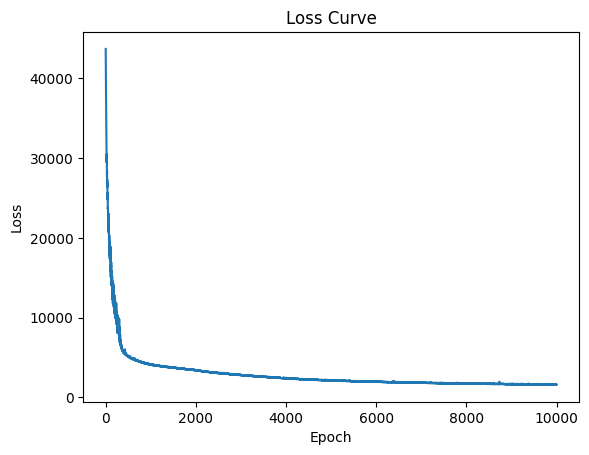

Accuracy: 0.9857142857142858
Mean Absolute Error: 0.01428571343421936
Mean Squared Error: 0.01428571343421936
Quadratic Weighted Kappa: 0.9928944830736436
Validation Accuracy: 0.9928571428571429
Validation Mean Absolute Error: 0.0071428571827709675
Validation Mean Squared Error: 0.0071428571827709675
Validation Quadratic Weighted Kappa: 0.9971181556195965


In [20]:
num_inputs = 7  # number of tasks
num_neurons = 128  # number of neurons in the hidden layer
num_latent = 2  # latent space dimension
num_categories = 4

model_pytorch = VAE(num_inputs=num_inputs, num_neurons=num_neurons, num_latent=num_latent, num_categories=num_categories)

# Convert input to tensor
X_tensor = torch.tensor(X, dtype=torch.float)

# Train the model
model_pytorch.fit(X_tensor)

# Make predictions
_, _, _, Xhat_tensor = model_pytorch.forward(X_tensor)

# Convert predictions to integer values
Xhat = Xhat_tensor.round().detach().numpy()

# Calculate accuracy
accuracy = np.mean(X_tensor.numpy() == Xhat)
print(f"Accuracy: {accuracy}")

# Make predictions on validation set
X_val_tensor = torch.tensor(X_val, dtype=torch.float)
_, _, _, Xhat_val_tensor = model_pytorch.forward(X_val_tensor)

# Convert probabilities to predicted categories for validation set
Xhat_val = Xhat_val_tensor.round().detach().numpy()

from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(X_tensor.numpy(), Xhat)
print(f"Mean Absolute Error: {mae}")

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(X_tensor.numpy(), Xhat)
print(f"Mean Squared Error: {mse}")


from sklearn.metrics import cohen_kappa_score
X_tensor_flat = X_tensor.numpy().ravel()
X_hat_flat = Xhat.ravel()

# Berechne den quadratisch gewichteten Kappa
kappa = cohen_kappa_score(X_tensor_flat, X_hat_flat, weights='quadratic')
print(f"Quadratic Weighted Kappa: {kappa}")

# Calculate accuracy for validation set
accuracy_val = np.mean(X_val_tensor.numpy() == Xhat_val)
print(f"Validation Accuracy: {accuracy_val}")

# Mean Absolute Error for validation set
mae_val = mean_absolute_error(X_val_tensor.numpy(), Xhat_val)
print(f"Validation Mean Absolute Error: {mae_val}")

# Mean Squared Error for validation set
mse_val = mean_squared_error(X_val_tensor.numpy(), Xhat_val)
print(f"Validation Mean Squared Error: {mse_val}")

# Flatten the tensors for Kappa calculation
X_val_tensor_flat = X_val_tensor.numpy().ravel()
X_hat_val_flat = Xhat_val.ravel()

# Quadratic Weighted Kappa for validation set
kappa_val = cohen_kappa_score(X_val_tensor_flat, X_hat_val_flat, weights='quadratic')
print(f"Validation Quadratic Weighted Kappa: {kappa_val}")


Epoch 0, Loss: 2859.145751953125


C:\Users\wuepp\AppData\Local\Temp\ipykernel_10764\3564886637.py:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)


Epoch 100, Loss: 2103.685302734375
Epoch 200, Loss: 1699.47705078125
Epoch 300, Loss: 1416.3616943359375
Epoch 400, Loss: 1203.54345703125
Epoch 500, Loss: 1053.102294921875
Epoch 600, Loss: 912.3028564453125
Epoch 700, Loss: 775.8829345703125
Epoch 800, Loss: 633.6828002929688
Epoch 900, Loss: 515.2234497070312
Epoch 1000, Loss: 486.1064758300781
Epoch 1100, Loss: 473.4285888671875
Epoch 1200, Loss: 463.4166259765625
Epoch 1300, Loss: 452.337890625
Epoch 1400, Loss: 444.05145263671875
Epoch 1500, Loss: 438.18603515625
Epoch 1600, Loss: 427.6751708984375
Epoch 1700, Loss: 420.6977844238281
Epoch 1800, Loss: 413.69720458984375
Epoch 1900, Loss: 405.1346435546875
Epoch 2000, Loss: 396.8633728027344
Epoch 2100, Loss: 391.81005859375
Epoch 2200, Loss: 381.49371337890625
Epoch 2300, Loss: 374.6777648925781
Epoch 2400, Loss: 366.1477966308594
Epoch 2500, Loss: 358.05340576171875
Epoch 2600, Loss: 350.75604248046875
Epoch 2700, Loss: 344.73675537109375
Epoch 2800, Loss: 339.2547607421875
Epoc

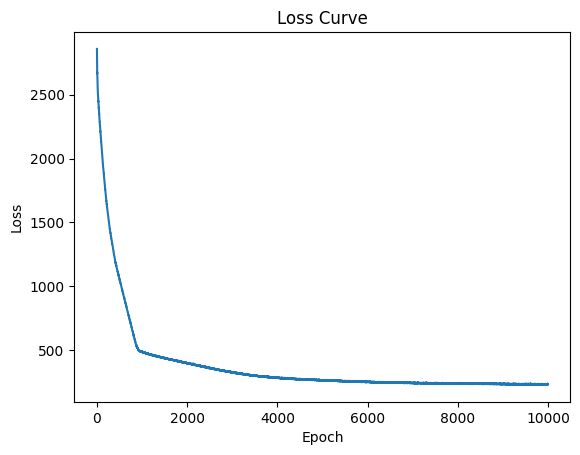

In [21]:
num_inputs = 7  # number of tasks
num_neurons = 128  # number of neurons in the hidden layer


num_latent = 2  # latent space dimension

model_pytorch = PC_IRT_AE(num_inputs=num_inputs, num_neurons=num_neurons, num_latent=num_latent, num_categories=4)

# Convert input to tensor
X_tensor = torch.tensor(X, dtype=torch.float)

# Train the model
model_pytorch.fit(X_tensor)

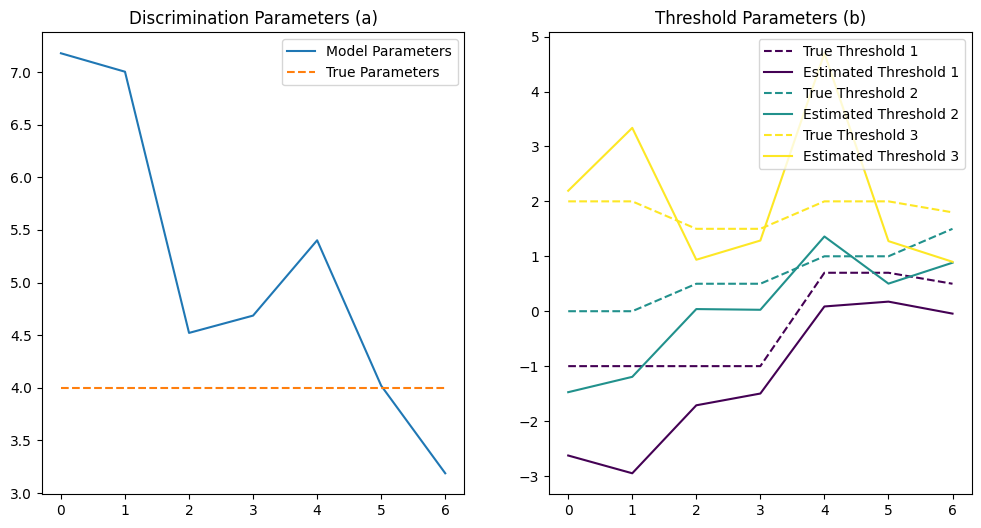

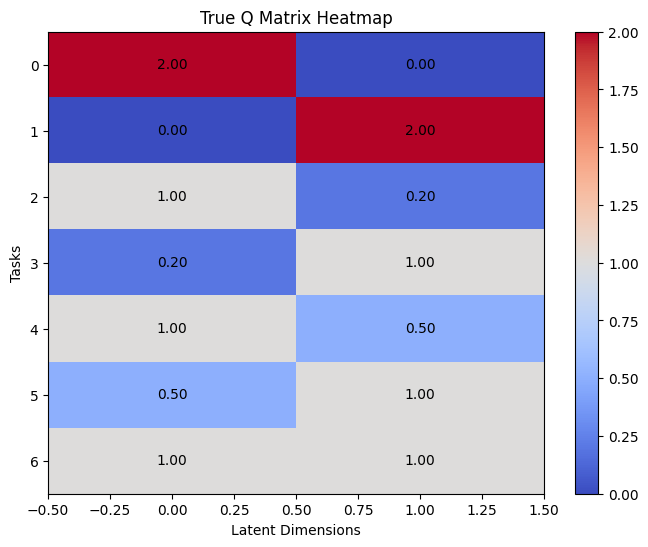

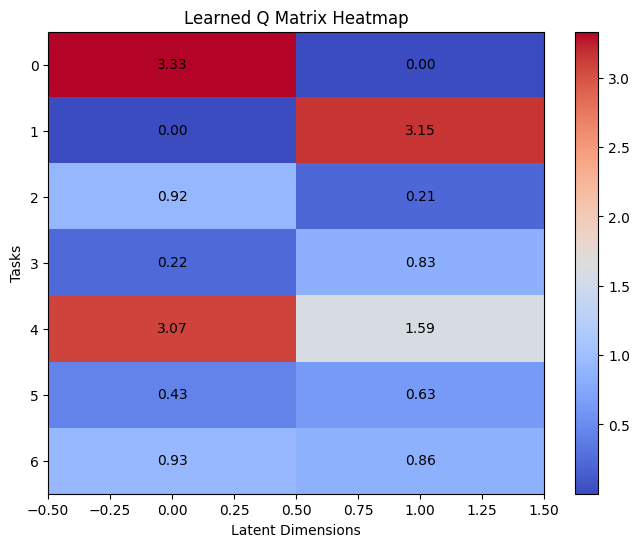

b values:
 [[-2.6272337  -1.4742109   2.1932437 ]
 [-2.9505875  -1.1948814   3.3378232 ]
 [-1.7129292   0.03904182  0.9369826 ]
 [-1.4987367   0.0259598   1.2868062 ]
 [ 0.08635323  1.3602508   4.6960034 ]
 [ 0.17443778  0.502158    1.276169  ]
 [-0.04368393  0.8830743   0.8997056 ]]
original B values:
 [[-1.   0.   2. ]
 [-1.   0.   2. ]
 [-1.   0.5  1.5]
 [-1.   0.5  1.5]
 [ 0.7  1.   2. ]
 [ 0.7  1.   2. ]
 [ 0.5  1.5  1.8]]
Differences (should be non-negative):
 []
a values (should be positive):
 [7.1788554 7.003599  4.521194  4.6857367 5.401502  4.0196857 3.187142 ]
Learned Q matrix:
 [[3.3319182e+00 1.4274024e-03]
 [7.4833084e-04 3.1548223e+00]
 [9.2073536e-01 2.1278541e-01]
 [2.2331201e-01 8.3408833e-01]
 [3.0739038e+00 1.5918797e+00]
 [4.3129024e-01 6.2795770e-01]
 [9.3121982e-01 8.5929698e-01]]
True Q matrix:
 [[2.  0. ]
 [0.  2. ]
 [1.  0.2]
 [0.2 1. ]
 [1.  0.5]
 [0.5 1. ]
 [1.  1. ]]
Difference Q matrix:
 [[ 1.33191824e+00  1.42740237e-03]
 [ 7.48330844e-04  1.15482235e+00]

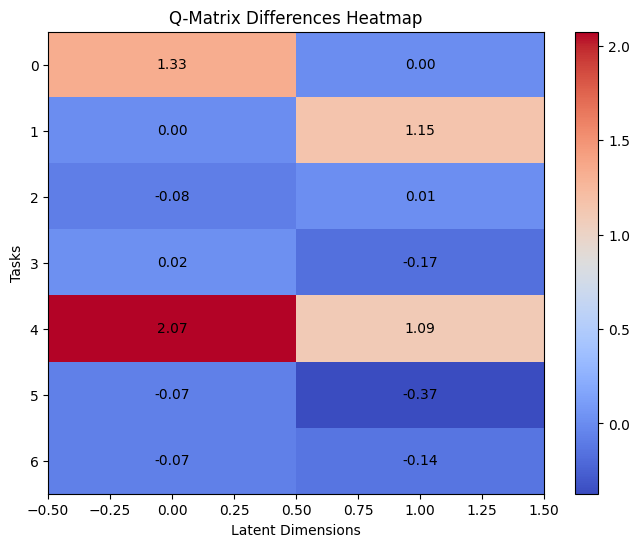

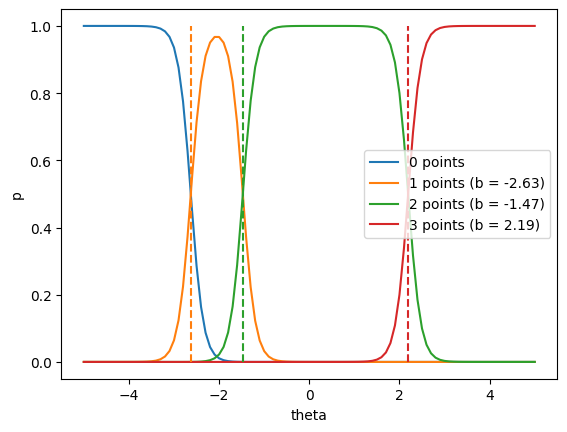

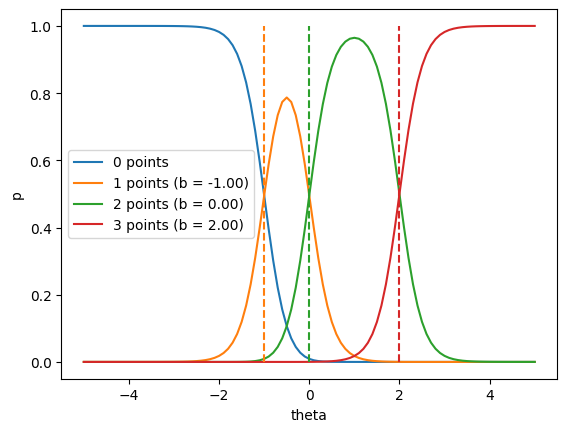

Accuracy: 0.8885714285714286
Mean Absolute Error: 0.11285714285714286
Mean Squared Error: 0.11571428571428573
Quadratic Weighted Kappa: 0.9414352999504214
Validation Accuracy: 0.9214285714285714
Validation Mean Absolute Error: 0.07857142857142858
Validation Mean Squared Error: 0.07857142857142858
Validation Quadratic Weighted Kappa: 0.9682212133718531


In [22]:
# Extracting model parameters
diffs = model_pytorch.b[:, 1:] - model_pytorch.b[:, :-1]
b_values = model_pytorch.b.detach().numpy()
a_values = model_pytorch.a.detach().numpy()

# Comparing the discrimination parameters (a)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title('Discrimination Parameters (a)')
plt.plot(a_values, label='Model Parameters')
plt.plot([A] * len(a_values), label='True Parameters', linestyle='--')
plt.legend()

# Erstelle eine Liste von Farben für die Parameter
colors = plt.cm.viridis(np.linspace(0, 1, b_values.shape[1]))  # z.B. "viridis" Farbschema


# Comparing the threshold parameters (b)
plt.subplot(1, 2, 2)
plt.title('Threshold Parameters (b)')

# Plotte die echten und geschätzten Werte mit gleichen Farben
for j in range(b_values.shape[1]):  # Für jede Spalte (Parameter)
    plt.plot(B[:, j], label=f'True Threshold {j + 1}', linestyle='--', color=colors[j])  # Echte Werte
    plt.plot(b_values[:, j], label=f'Estimated Threshold {j + 1}', color=colors[j])  # Geschätzte Werte

#plt.plot(b_values, label='Model Parameters')
#plt.plot(B, label='True Parameters', linestyle='--')
plt.legend()

plt.show()

learned_Q = model_pytorch.Q.detach().numpy()


learned_Q_transposed = learned_Q.T
#hier werden die spalten der MAtrix vertauscht dies ist nur notwendig, wenn die Faktoren nicht angeordnet sind wie die echten Faktoren der Generierungsdaten
learned_Q_transposed = learned_Q_transposed[:,::-1]

# Compare the true Q matrix with the learned Q matrix
true_Q = Q

# Heatmap erstellen
plt.figure(figsize=(8, 6))
plt.imshow(Q, cmap='coolwarm', aspect='auto')

# Colorbar hinzufügen
plt.colorbar()

# Achsenbeschriftungen und Titel
plt.title('True Q Matrix Heatmap')
plt.xlabel('Latent Dimensions')
plt.ylabel('Tasks')

# Zahlenwerte in die Heatmap einfügen
for i in range(Q.shape[0]):
    for j in range(Q.shape[1]):
        plt.text(j, i, f'{Q[i, j]:.2f}', ha='center', va='center', color='black')

# Heatmap anzeigen
plt.show()

# Heatmap erstellen
plt.figure(figsize=(8, 6))
plt.imshow(learned_Q_transposed, cmap='coolwarm', aspect='auto')

# Colorbar hinzufügen
plt.colorbar()

# Achsenbeschriftungen und Titel
plt.title('Learned Q Matrix Heatmap')
plt.xlabel('Latent Dimensions')
plt.ylabel('Tasks')

# Zahlenwerte in die Heatmap einfügen
for i in range(learned_Q_transposed.shape[0]):
    for j in range(learned_Q_transposed.shape[1]):
        plt.text(j, i, f'{learned_Q_transposed[i, j]:.2f}', ha='center', va='center', color='black')

# Heatmap anzeigen
plt.show()



neg_diffs = diffs[diffs < 0]

print("b values:\n", b_values)
print("original B values:\n", B)
print("Differences (should be non-negative):\n", neg_diffs.detach().numpy())
print("a values (should be positive):\n", a_values)


if learned_Q_transposed.size == true_Q.size:
    diff_Q = learned_Q_transposed - true_Q
    print("Learned Q matrix:\n", learned_Q_transposed)
    print("True Q matrix:\n", true_Q)
    print("Difference Q matrix:\n", diff_Q)

    # Heatmap erstellen
    plt.figure(figsize=(8, 6))
    plt.imshow(diff_Q, cmap='coolwarm', aspect='auto')

    # Colorbar hinzufügen
    plt.colorbar()

    # Achsenbeschriftungen und Titel
    plt.title('Q-Matrix Differences Heatmap')
    plt.xlabel('Latent Dimensions')
    plt.ylabel('Tasks')

    # Zahlenwerte in die Heatmap einfügen
    for i in range(diff_Q.shape[0]):
        for j in range(diff_Q.shape[1]):
            plt.text(j, i, f'{diff_Q[i, j]:.2f}', ha='center', va='center', color='black')

    # Heatmap anzeigen
    plt.show()

else:
    print("Learned Q matrix:\n", learned_Q_transposed)

def compute_probabilities_for_theta(model, theta_range):
    probabilities = []

    # Loop through each theta value in the specified range
    for theta_val in theta_range:
        # Create a single latent vector for decoding (shape: (1, num_latent))
        theta_tensor = torch.tensor([[theta_val, theta_val]], dtype=torch.float)
        print(theta_tensor)
        # Get the probabilities from the model for this theta value
        with torch.no_grad():  # Disable gradient tracking
            Y = model.decode(theta_tensor)  # Forward pass with only theta
        probabilities.append(Y.numpy())

    probabilities = np.array(probabilities)

    # Remove the unnecessary '1' dimension
    probabilities = np.squeeze(probabilities, axis=1)  # Shape becomes (100, 7, 4)

    return probabilities



import numpy as np
import matplotlib.pyplot as plt
task = 0

theta_values = np.linspace(-5,5, 101)
bs = b_values[task,:]
a  = a_values[task] 

M = len(bs) + 1
N = len(theta_values)

# compute logits
Z = np.zeros((N, M))
Z[:, 1:] = a * (np.expand_dims(theta_values, 1) - np.expand_dims(bs, 0))
Z = np.cumsum(Z, axis=1)

# compute probabilities
P = np.exp(Z) / np.expand_dims(np.sum(np.exp(Z), axis=1), 1)

# Plot the probabilities and store the plot objects
lines = []
for i in range(M):
    line, = plt.plot(theta_values, P[:, i], label=f'{i} points')
    lines.append(line)

plt.xlabel('theta')
plt.ylabel('p')
#plt.title(f'modeled response probabilities for a participant`s point answer for question {task + 1}')

legend_entries = ['0 points ']
for j in range(M - 1):
    legend_entries.append(f'{j + 1} points (b = {bs[j]:.2f})')

# Plot vertical lines (thresholds) in the same color as the corresponding probabilities
for j in range(M - 1):
    plt.plot([bs[j], bs[j]], [0, 1], linestyle='--', color=lines[j + 1].get_color())  # Use the color of the corresponding probability curve

plt.legend(legend_entries)
plt.show()

bs = B[task,:]
a = A

M = len(bs)+1
N = len(theta_values)

M = len(bs) + 1
N = len(theta_values)

# compute logits
Z = np.zeros((N, M))
Z[:, 1:] = a * (np.expand_dims(theta_values, 1) - np.expand_dims(bs, 0))
Z = np.cumsum(Z, axis=1)

# compute probabilities
P = np.exp(Z) / np.expand_dims(np.sum(np.exp(Z), axis=1), 1)

# Plot the probabilities and store the plot objects
lines = []
for i in range(M):
    line, = plt.plot(theta_values, P[:, i], label=f'{i} points')
    lines.append(line)

plt.xlabel('theta')
plt.ylabel('p')
#plt.title(f'true response probabilities for a participant`s point answer for question {task + 1}')

legend_entries = ['0 points ']
for j in range(M - 1):
    legend_entries.append(f'{j + 1} points (b = {bs[j]:.2f})')

# Plot vertical lines (thresholds) in the same color as the corresponding probabilities
for j in range(M - 1):
    plt.plot([bs[j], bs[j]], [0, 1], linestyle='--', color=lines[j + 1].get_color())  # Use the color of the corresponding probability curve

plt.legend(legend_entries)
plt.show()



# Make predictions
_, _, _, Xhat_tensor = model_pytorch.forward(X_tensor)

# Convert probabilities to predicted categories
Xhat = torch.argmax(Xhat_tensor, dim=-1).detach().numpy()

#print(X_tensor[0])
#print(Xhat[0])

# Calculate accuracy
accuracy = np.mean(X_tensor.numpy() == Xhat)
print(f"Accuracy: {accuracy}")

# Make predictions on validation set

X_val_tensor = torch.tensor(X_val, dtype=torch.float)
_, _, _, Xhat_val_tensor = model_pytorch.forward(X_val_tensor)

# Convert probabilities to predicted categories for validation set
Xhat_val = torch.argmax(Xhat_val_tensor, dim=-1).detach().numpy()

#print(X_tensor[0])
#print(Xhat[0])

from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(X_tensor.numpy(), Xhat)
print(f"Mean Absolute Error: {mae}")

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(X_tensor.numpy(), Xhat)
print(f"Mean Squared Error: {mse}")


from sklearn.metrics import cohen_kappa_score
X_tensor_flat = X_tensor.numpy().ravel()
X_hat_flat = Xhat.ravel()

# Berechne den quadratisch gewichteten Kappa
kappa = cohen_kappa_score(X_tensor_flat, X_hat_flat, weights='quadratic')
print(f"Quadratic Weighted Kappa: {kappa}")

# Calculate accuracy for validation set
accuracy_val = np.mean(X_val_tensor.numpy() == Xhat_val)
print(f"Validation Accuracy: {accuracy_val}")

# Mean Absolute Error for validation set
mae_val = mean_absolute_error(X_val_tensor.numpy(), Xhat_val)
print(f"Validation Mean Absolute Error: {mae_val}")

# Mean Squared Error for validation set
mse_val = mean_squared_error(X_val_tensor.numpy(), Xhat_val)
print(f"Validation Mean Squared Error: {mse_val}")

# Flatten the tensors for Kappa calculation
X_val_tensor_flat = X_val_tensor.numpy().ravel()
X_hat_val_flat = Xhat_val.ravel()

# Quadratic Weighted Kappa for validation set
kappa_val = cohen_kappa_score(X_val_tensor_flat, X_hat_val_flat, weights='quadratic')
print(f"Validation Quadratic Weighted Kappa: {kappa_val}")

#print(Xhat)

#### Cross Validation

Cross-validation for fold: 1


C:\Users\wuepp\AppData\Local\Temp\ipykernel_4944\4037316119.py:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)


Epoch 0, Loss: 2173.62109375
Epoch 100, Loss: 1605.379150390625
Epoch 200, Loss: 1331.571044921875
Epoch 300, Loss: 1127.177978515625
Epoch 400, Loss: 976.934326171875
Epoch 500, Loss: 838.03857421875
Epoch 600, Loss: 694.56005859375
Epoch 700, Loss: 584.2430419921875
Epoch 800, Loss: 484.7068786621094
Epoch 900, Loss: 468.06695556640625
Epoch 1000, Loss: 456.92852783203125
Epoch 1100, Loss: 443.2347717285156
Epoch 1200, Loss: 441.77825927734375
Epoch 1300, Loss: 428.9123840332031
Epoch 1400, Loss: 424.83673095703125
Epoch 1500, Loss: 421.3968505859375
Epoch 1600, Loss: 417.05224609375
Epoch 1700, Loss: 410.2591552734375
Epoch 1800, Loss: 404.3072814941406
Epoch 1900, Loss: 394.88519287109375
Epoch 2000, Loss: 384.77972412109375
Epoch 2100, Loss: 385.5499572753906
Epoch 2200, Loss: 376.8857116699219
Epoch 2300, Loss: 376.40118408203125
Epoch 2400, Loss: 382.91595458984375
Epoch 2500, Loss: 373.23291015625
Epoch 2600, Loss: 360.4628601074219
Epoch 2700, Loss: 363.1715087890625
Epoch 280

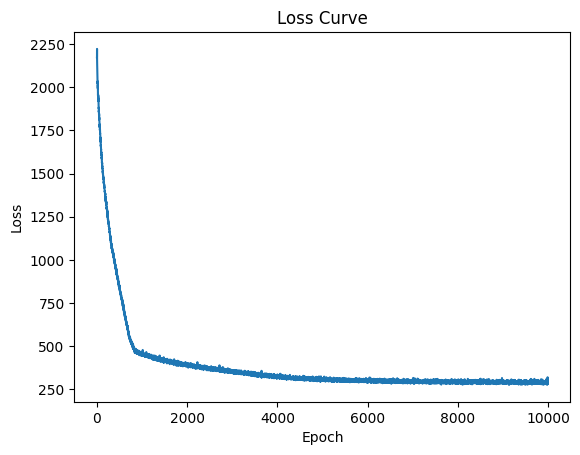

Training Accuracy: 0.9089285714285714
Training Mean Absolute Error: 0.09642857142857142
Training Mean Squared Error: 0.10714285714285714
Training Quadratic Weighted Kappa: 0.9498507462686567


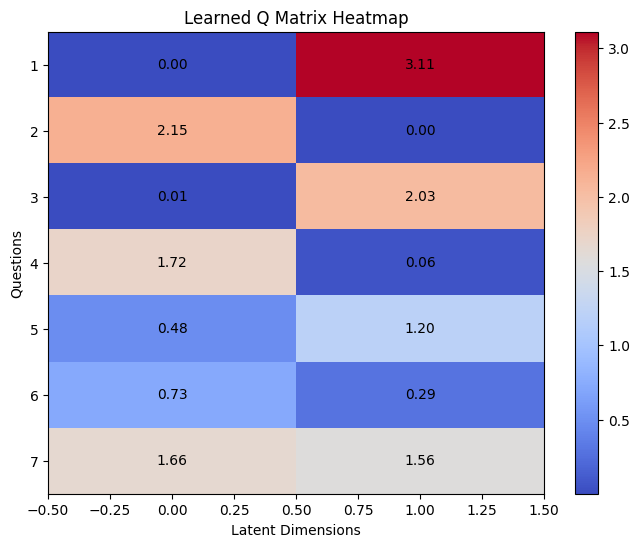

Validation Accuracy: 0.8428571428571429
Validation Mean Absolute Error: 0.15714285714285717
Validation Mean Squared Error: 0.15714285714285717
Validation Quadratic Weighted Kappa: 0.9272933289268684
--------------------------------------------------
Cross-validation for fold: 2
Epoch 0, Loss: 2345.443359375


C:\Users\wuepp\AppData\Local\Temp\ipykernel_4944\4037316119.py:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)


Epoch 100, Loss: 1653.295654296875
Epoch 200, Loss: 1281.642822265625
Epoch 300, Loss: 1027.748779296875
Epoch 400, Loss: 823.8619384765625
Epoch 500, Loss: 697.993896484375
Epoch 600, Loss: 617.3531494140625
Epoch 700, Loss: 543.5775756835938
Epoch 800, Loss: 537.1295166015625
Epoch 900, Loss: 536.1471557617188
Epoch 1000, Loss: 519.2291870117188
Epoch 1100, Loss: 514.304443359375
Epoch 1200, Loss: 504.8475036621094
Epoch 1300, Loss: 498.8870849609375
Epoch 1400, Loss: 499.7832336425781
Epoch 1500, Loss: 487.96807861328125
Epoch 1600, Loss: 479.88519287109375
Epoch 1700, Loss: 474.98358154296875
Epoch 1800, Loss: 462.0361328125
Epoch 1900, Loss: 459.1562805175781
Epoch 2000, Loss: 445.17999267578125
Epoch 2100, Loss: 438.74798583984375
Epoch 2200, Loss: 432.30322265625
Epoch 2300, Loss: 446.39495849609375
Epoch 2400, Loss: 414.1349182128906
Epoch 2500, Loss: 413.25390625
Epoch 2600, Loss: 397.8779296875
Epoch 2700, Loss: 401.11798095703125
Epoch 2800, Loss: 394.74627685546875
Epoch 29

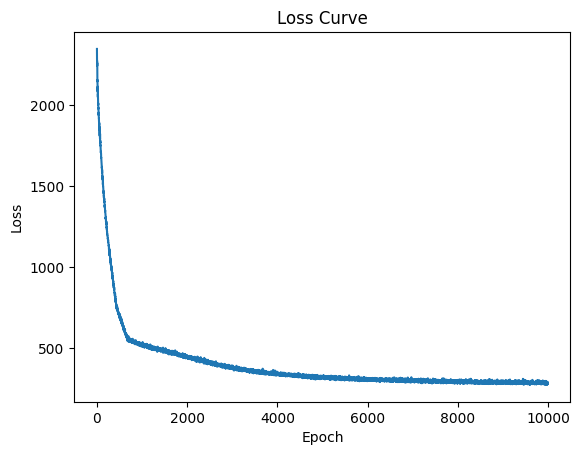

Training Accuracy: 0.9
Training Mean Absolute Error: 0.10714285714285714
Training Mean Squared Error: 0.12142857142857144
Training Quadratic Weighted Kappa: 0.9419966672454815


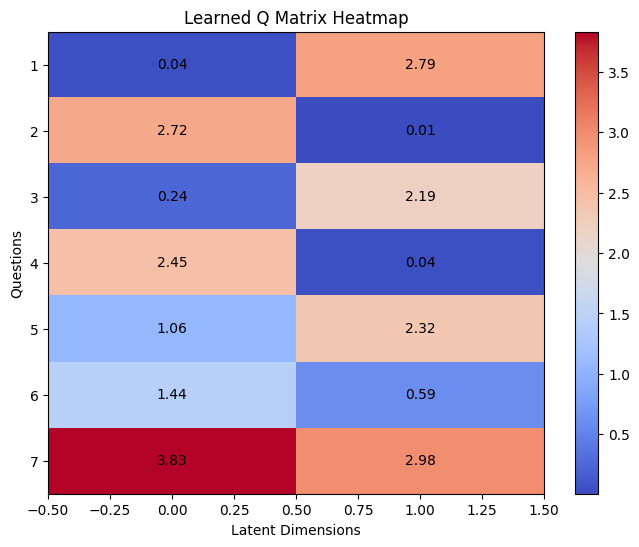

Validation Accuracy: 0.8714285714285714
Validation Mean Absolute Error: 0.13571428571428573
Validation Mean Squared Error: 0.15
Validation Quadratic Weighted Kappa: 0.9347594532220841
--------------------------------------------------
Cross-validation for fold: 3
Epoch 0, Loss: 3523.89013671875


C:\Users\wuepp\AppData\Local\Temp\ipykernel_4944\4037316119.py:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)


Epoch 100, Loss: 2701.98779296875
Epoch 200, Loss: 2249.84619140625
Epoch 300, Loss: 1823.958251953125
Epoch 400, Loss: 1465.8812255859375
Epoch 500, Loss: 1194.373291015625
Epoch 600, Loss: 950.5003662109375
Epoch 700, Loss: 762.2748413085938
Epoch 800, Loss: 641.6425170898438
Epoch 900, Loss: 563.1115112304688
Epoch 1000, Loss: 564.3021240234375
Epoch 1100, Loss: 545.7301025390625
Epoch 1200, Loss: 538.1080932617188
Epoch 1300, Loss: 526.4176025390625
Epoch 1400, Loss: 530.81005859375
Epoch 1500, Loss: 524.86181640625
Epoch 1600, Loss: 512.8279418945312
Epoch 1700, Loss: 508.883056640625
Epoch 1800, Loss: 513.1362915039062
Epoch 1900, Loss: 507.5950927734375
Epoch 2000, Loss: 498.7650146484375
Epoch 2100, Loss: 498.257080078125
Epoch 2200, Loss: 490.750244140625
Epoch 2300, Loss: 492.8171081542969
Epoch 2400, Loss: 484.96246337890625
Epoch 2500, Loss: 481.5830078125
Epoch 2600, Loss: 477.10504150390625
Epoch 2700, Loss: 479.0276794433594
Epoch 2800, Loss: 471.78729248046875
Epoch 290

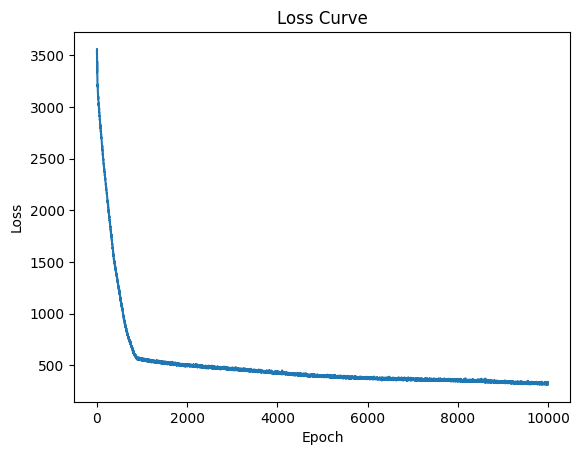

Training Accuracy: 0.8607142857142858
Training Mean Absolute Error: 0.15357142857142855
Training Mean Squared Error: 0.1857142857142857
Training Quadratic Weighted Kappa: 0.9192994124819864


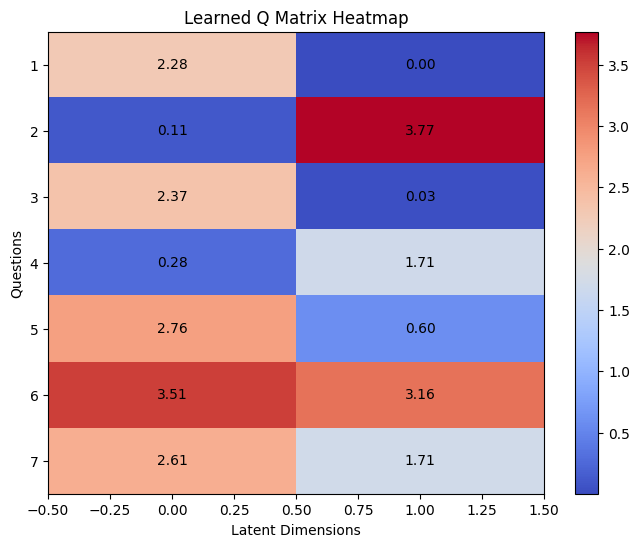

Validation Accuracy: 0.8571428571428571
Validation Mean Absolute Error: 0.17857142857142858
Validation Mean Squared Error: 0.2785714285714286
Validation Quadratic Weighted Kappa: 0.8726679104477612
--------------------------------------------------
Cross-validation for fold: 4
Epoch 0, Loss: 3138.2578125


C:\Users\wuepp\AppData\Local\Temp\ipykernel_4944\4037316119.py:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)


Epoch 100, Loss: 2441.3544921875
Epoch 200, Loss: 2130.328857421875
Epoch 300, Loss: 1804.073974609375
Epoch 400, Loss: 1536.6004638671875
Epoch 500, Loss: 1309.9691162109375
Epoch 600, Loss: 1141.865478515625
Epoch 700, Loss: 956.2906494140625
Epoch 800, Loss: 786.3327026367188
Epoch 900, Loss: 650.075439453125
Epoch 1000, Loss: 585.625
Epoch 1100, Loss: 519.0193481445312
Epoch 1200, Loss: 455.7853088378906
Epoch 1300, Loss: 436.618408203125
Epoch 1400, Loss: 417.8140563964844
Epoch 1500, Loss: 418.68133544921875
Epoch 1600, Loss: 419.45965576171875
Epoch 1700, Loss: 407.43939208984375
Epoch 1800, Loss: 411.6800537109375
Epoch 1900, Loss: 406.9635925292969
Epoch 2000, Loss: 402.9931640625
Epoch 2100, Loss: 396.11968994140625
Epoch 2200, Loss: 396.4813232421875
Epoch 2300, Loss: 389.9045715332031
Epoch 2400, Loss: 374.8292236328125
Epoch 2500, Loss: 385.62738037109375
Epoch 2600, Loss: 381.2931213378906
Epoch 2700, Loss: 385.03485107421875
Epoch 2800, Loss: 371.89453125
Epoch 2900, Los

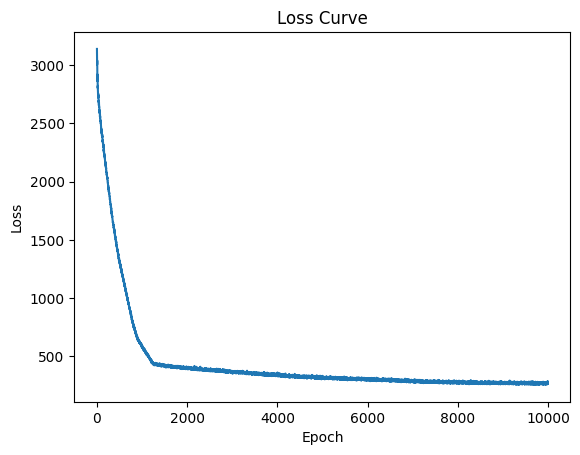

Training Accuracy: 0.925
Training Mean Absolute Error: 0.07857142857142856
Training Mean Squared Error: 0.08571428571428572
Training Quadratic Weighted Kappa: 0.9600624024960999


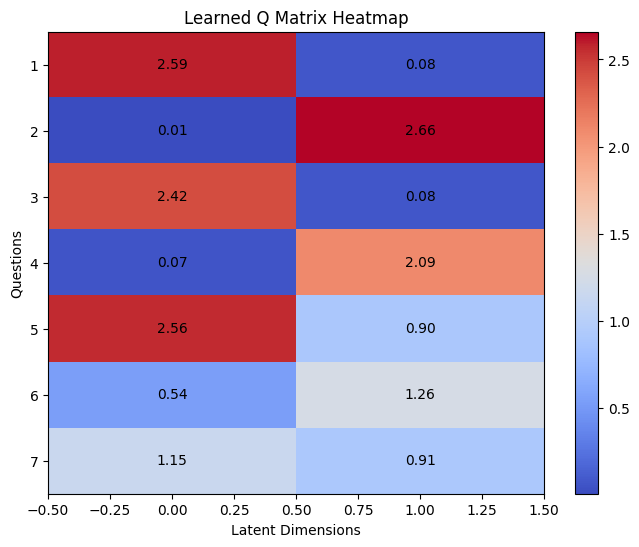

Validation Accuracy: 0.8285714285714286
Validation Mean Absolute Error: 0.17857142857142858
Validation Mean Squared Error: 0.19285714285714287
Validation Quadratic Weighted Kappa: 0.9059327095361338
--------------------------------------------------
Cross-validation for fold: 5
Epoch 0, Loss: 3846.827392578125


C:\Users\wuepp\AppData\Local\Temp\ipykernel_4944\4037316119.py:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)


Epoch 100, Loss: 2927.1064453125
Epoch 200, Loss: 2513.458251953125
Epoch 300, Loss: 2230.5791015625
Epoch 400, Loss: 1971.613037109375
Epoch 500, Loss: 1771.098876953125
Epoch 600, Loss: 1589.3861083984375
Epoch 700, Loss: 1406.38818359375
Epoch 800, Loss: 1214.123046875
Epoch 900, Loss: 1038.625732421875
Epoch 1000, Loss: 907.9989013671875
Epoch 1100, Loss: 782.946044921875
Epoch 1200, Loss: 682.69775390625
Epoch 1300, Loss: 616.8892211914062
Epoch 1400, Loss: 543.556884765625
Epoch 1500, Loss: 491.8653869628906
Epoch 1600, Loss: 497.476806640625
Epoch 1700, Loss: 482.2303466796875
Epoch 1800, Loss: 465.6683654785156
Epoch 1900, Loss: 470.5169982910156
Epoch 2000, Loss: 463.4475402832031
Epoch 2100, Loss: 451.3565979003906
Epoch 2200, Loss: 466.12939453125
Epoch 2300, Loss: 448.1488037109375
Epoch 2400, Loss: 444.0662841796875
Epoch 2500, Loss: 433.6180419921875
Epoch 2600, Loss: 436.82049560546875
Epoch 2700, Loss: 422.0207824707031
Epoch 2800, Loss: 419.5628967285156
Epoch 2900, Lo

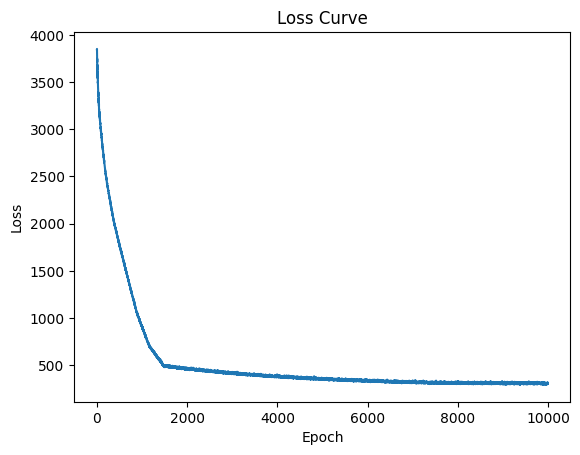

Training Accuracy: 0.8946428571428572
Training Mean Absolute Error: 0.1142857142857143
Training Mean Squared Error: 0.13214285714285715
Training Quadratic Weighted Kappa: 0.9381905830131494


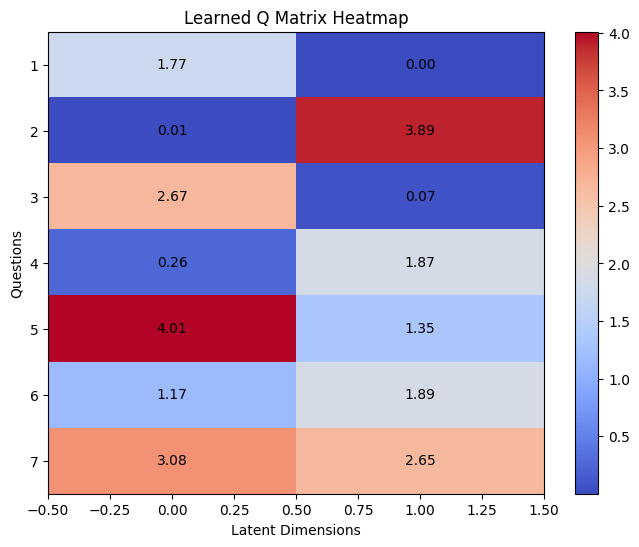

Validation Accuracy: 0.9357142857142857
Validation Mean Absolute Error: 0.0642857142857143
Validation Mean Squared Error: 0.0642857142857143
Validation Quadratic Weighted Kappa: 0.9687933425797504
--------------------------------------------------
Cross-Validation Performance Summary:
Average Training Accuracy: 0.8978571428571429 ± 0.021231234211002634
Average Validation Accuracy: 0.8671428571428572 ± 0.03714285714285714
Average Training MAE: 0.10999999999999999 ± 0.024887501985977636
Average Validation MAE: 0.14285714285714288 ± 0.04237827706911807
Average Training MSE: 0.12642857142857142 ± 0.03347249861102851
Average Validation MSE: 0.16857142857142857 ± 0.0693409205686377
Average Training Quadratic Weighted Kappa: 0.9418799623010748 ± 0.013547257273781123
Average Validation Quadratic Weighted Kappa: 0.9218893489425195 ± 0.031850248198713314


In [3]:
X = np.loadtxt('partial_credit_data.csv', delimiter = '\t', dtype=int)
cross_validate_PC_VAE(X, PC_IRT_AE, num_inputs=7, num_neurons=128, num_latent=2, num_categories=4)

Cross-validation for fold: 1


C:\Users\wuepp\AppData\Local\Temp\ipykernel_18216\3702903398.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)


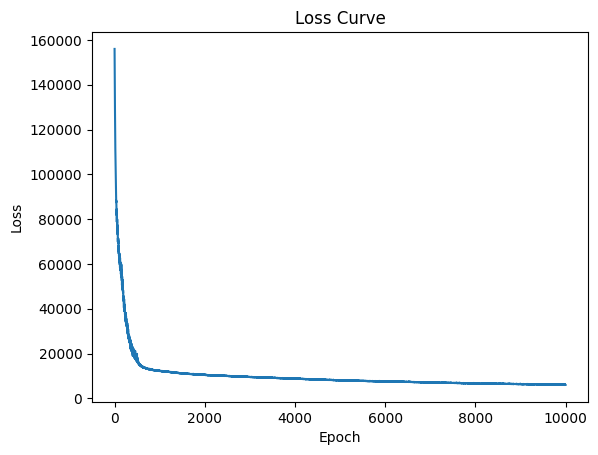

Training Accuracy: 0.9709821428571429
Training Mean Absolute Error: 0.02901786006987095
Training Mean Squared Error: 0.02901786006987095
Training Quadratic Weighted Kappa: 0.9856088826404379
Validation Accuracy: 0.8678571428571429
Validation Mean Absolute Error: 0.1428571492433548
Validation Mean Squared Error: 0.16785714030265808
Validation Quadratic Weighted Kappa: 0.9253731343283582
--------------------------------------------------
Cross-validation for fold: 2


C:\Users\wuepp\AppData\Local\Temp\ipykernel_18216\3702903398.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)


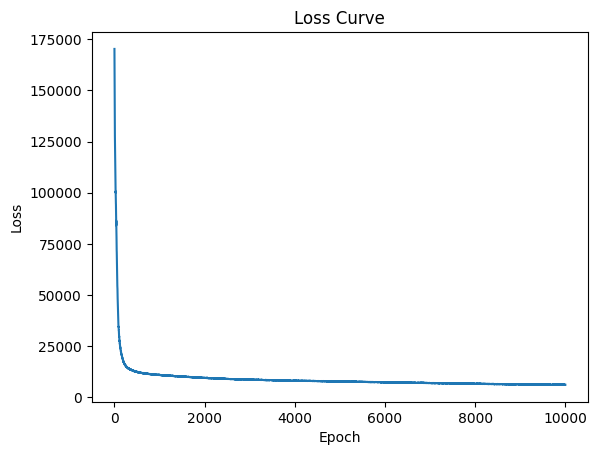

Training Accuracy: 0.9647321428571428
Training Mean Absolute Error: 0.03526785597205162
Training Mean Squared Error: 0.03526785597205162
Training Quadratic Weighted Kappa: 0.9828207184310315
Validation Accuracy: 0.8892857142857142
Validation Mean Absolute Error: 0.11428570747375488
Validation Mean Squared Error: 0.12142856419086456
Validation Quadratic Weighted Kappa: 0.9446648357237311
--------------------------------------------------
Cross-validation for fold: 3


C:\Users\wuepp\AppData\Local\Temp\ipykernel_18216\3702903398.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)


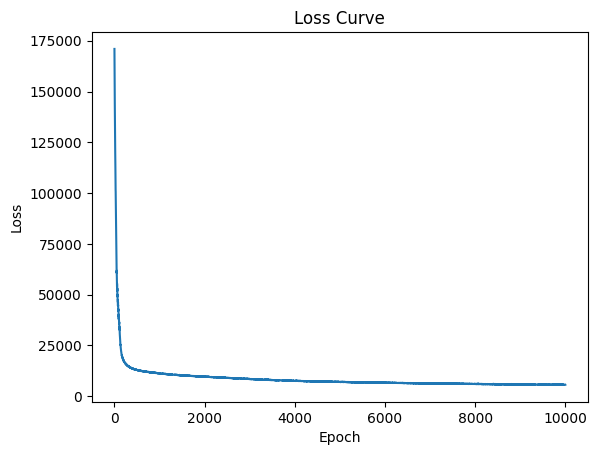

Training Accuracy: 0.9709821428571429
Training Mean Absolute Error: 0.02901786006987095
Training Mean Squared Error: 0.02901786006987095
Training Quadratic Weighted Kappa: 0.986074256349986
Validation Accuracy: 0.8821428571428571
Validation Mean Absolute Error: 0.11964285373687744
Validation Mean Squared Error: 0.12321428954601288
Validation Quadratic Weighted Kappa: 0.937740080950785
--------------------------------------------------
Cross-validation for fold: 4


C:\Users\wuepp\AppData\Local\Temp\ipykernel_18216\3702903398.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)


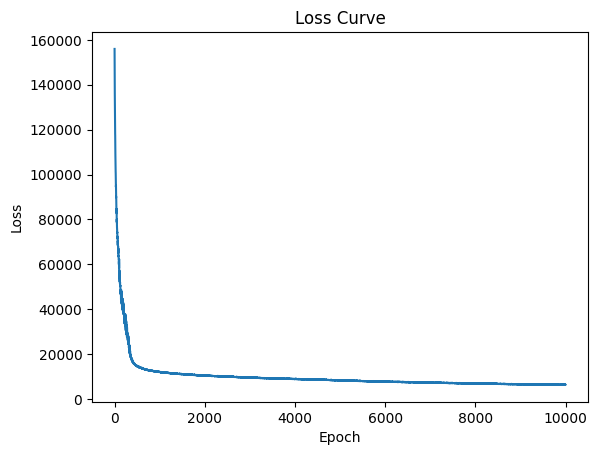

Training Accuracy: 0.9660714285714286
Training Mean Absolute Error: 0.03392856940627098
Training Mean Squared Error: 0.03392856940627098
Training Quadratic Weighted Kappa: 0.9835491985645748
Validation Accuracy: 0.8982142857142857
Validation Mean Absolute Error: 0.11071427911520004
Validation Mean Squared Error: 0.12857142090797424
Validation Quadratic Weighted Kappa: 0.9374301675977653
--------------------------------------------------
Cross-validation for fold: 5


C:\Users\wuepp\AppData\Local\Temp\ipykernel_18216\3702903398.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)


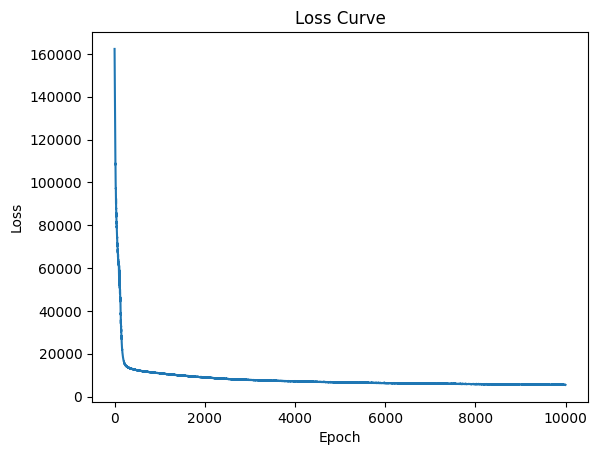

Training Accuracy: 0.971875
Training Mean Absolute Error: 0.02812500111758709
Training Mean Squared Error: 0.02812500111758709
Training Quadratic Weighted Kappa: 0.9865895285808771
Validation Accuracy: 0.8732142857142857
Validation Mean Absolute Error: 0.1339285671710968
Validation Mean Squared Error: 0.14821429550647736
Validation Quadratic Weighted Kappa: 0.9256215275110735
--------------------------------------------------
Cross-Validation Performance Summary:
Average Training Accuracy: 0.9689285714285715 ± 0.0029287891905101617
Average Validation Accuracy: 0.8821428571428571 ± 0.010891393344269213
Average Training MAE: 0.031071430072188377 ± 0.002928787376731634
Average Validation MAE: 0.12428571283817291 ± 0.012195269577205181
Average Training MSE: 0.031071430072188377 ± 0.002928787376731634
Average Validation MSE: 0.13785713911056519 ± 0.01776404306292534
Average Training Quadratic Weighted Kappa: 0.9849285169133815 ± 0.0014751209908514182
Average Validation Quadratic Weighted Ka

In [26]:
cross_validate_VAE(X, VAE, num_inputs=7, num_neurons=128, num_latent=2, num_categories=4)

### Usability Datensatz

#### data loading

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold

# CSV-Datei einlesen (angenommen, die Daten sind Komma-getrennt)
# Anpassen des Delimiters, falls die Daten Tab-getrennt sind: delimiter='\t'
data = np.genfromtxt('uta4_sus.csv', skip_header=1, delimiter=',')

X1 = data[:, 3:13].astype(int)
#print(X)
X1 = X1 - 1

# Zweite CSV-Datei einlesen und verarbeiten
data2 = np.genfromtxt('uta7_sus_assistant.csv', skip_header=1, delimiter=',')
X2 = data2[:, 3:13].astype(int)
#print(X2)
X2 = X2 - 1  # Anpassung der Werte

# Dritte CSV-Datei einlesen und verarbeiten
data3 = np.genfromtxt('uta7_sus_current.csv', skip_header=1, delimiter=',')
X3 = data3[:, 3:13].astype(int)
X3 = X3 - 1  # Anpassung der Werte

# Vierte CSV-Datei einlesen und verarbeiten
data4 = np.genfromtxt('uta10_SUS_analises.csv', skip_header=1, delimiter=';')
X4 = data4[:, 3:13].astype(int)
X4 = X4 - 1  # Anpassung der Werte

# fünfte CSV-Datei einlesen und verarbeiten
data5 = np.genfromtxt('mimbcdui_UTA9_SUS.csv', skip_header=1, delimiter=',')
X5 = data5[:, 2:12].astype(int)
X5 = X5 - 1  # Anpassung der Werte


# Alle drei Matrizen entlang der Zeilenachse (axis=0) zusammenfügen
X = np.concatenate((X2, X4, X3), axis=0)
#print(X.shape)

# Die Daten in Training und Validierung aufteilen (z.B. 80% Training, 20% Validierung)
X, X_val = train_test_split(X, test_size=0.2, random_state=44)
N, m = X.shape
print(X)

# Anzahl der Zeilen und Spalten ausgeben
print("number of rows: " + str(N))
print("number of columns: " + str(m))

[[2 3 4 1 4 2 4 2 3 1]
 [2 0 4 0 4 0 4 0 4 0]
 [0 3 1 3 1 3 1 4 1 4]
 [0 0 0 1 0 1 0 0 2 0]
 [2 0 4 0 4 0 4 0 4 0]
 [0 3 4 3 3 0 1 0 4 0]
 [3 0 3 0 4 0 2 0 4 1]
 [2 0 4 0 4 0 2 0 4 0]
 [4 0 4 0 4 0 3 0 4 0]
 [1 2 1 0 4 3 1 3 3 4]
 [2 0 2 0 2 3 4 4 4 1]
 [1 1 3 1 4 1 3 0 3 1]
 [0 0 4 0 4 0 4 0 3 0]
 [4 0 4 1 4 0 4 0 4 1]
 [0 0 4 0 3 1 3 0 3 1]
 [3 0 3 0 3 0 4 0 3 0]
 [3 0 4 0 4 0 4 0 4 0]
 [3 0 3 0 3 0 3 0 3 0]
 [3 0 4 0 4 0 4 0 4 0]
 [3 0 3 0 3 0 4 0 3 0]
 [2 1 4 0 1 0 2 0 0 3]
 [4 0 4 0 4 0 4 0 4 0]
 [3 1 3 3 4 1 4 0 3 0]
 [3 0 4 0 3 0 3 0 3 0]
 [0 0 4 0 2 0 3 1 3 1]
 [2 0 4 2 4 0 3 0 4 4]
 [4 0 4 0 4 0 4 0 4 3]
 [4 0 4 0 4 2 4 0 4 0]
 [3 1 2 2 3 1 3 1 3 1]
 [1 2 0 4 1 3 0 3 1 4]
 [4 0 4 0 4 0 4 0 4 0]
 [0 1 4 0 3 0 3 0 4 3]
 [4 0 4 1 4 0 4 0 4 0]
 [4 0 4 0 4 0 4 0 4 0]
 [3 0 4 0 3 0 4 0 4 0]
 [4 0 3 0 4 0 4 0 4 0]
 [4 0 4 0 3 0 2 0 4 0]
 [1 3 0 1 3 0 1 2 4 0]
 [0 4 0 3 0 3 1 4 0 4]
 [4 0 4 0 4 0 4 0 4 0]
 [2 0 2 0 4 0 4 3 3 2]
 [3 0 4 1 4 0 4 0 4 0]
 [3 0 3 2 3 1 3 0 2 2]
 [0 0 4 0 4

#### single run

C:\Users\wuepp\AppData\Local\Temp\ipykernel_15076\1231359900.py:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)


Epoch 0, Loss: 6811.421875
Epoch 100, Loss: 5424.0830078125
Epoch 200, Loss: 4703.40283203125
Epoch 300, Loss: 4081.295654296875
Epoch 400, Loss: 3509.44775390625
Epoch 500, Loss: 3050.94482421875
Epoch 600, Loss: 2662.455078125
Epoch 700, Loss: 2319.30419921875
Epoch 800, Loss: 2061.662841796875
Epoch 900, Loss: 1850.5343017578125
Epoch 1000, Loss: 1669.552734375
Epoch 1100, Loss: 1552.713134765625
Epoch 1200, Loss: 1494.656005859375
Epoch 1300, Loss: 1424.74169921875
Epoch 1400, Loss: 1360.6207275390625
Epoch 1500, Loss: 1296.3397216796875
Epoch 1600, Loss: 1248.740478515625
Epoch 1700, Loss: 1183.2655029296875
Epoch 1800, Loss: 1134.7799072265625
Epoch 1900, Loss: 1080.562255859375
Epoch 2000, Loss: 1075.638916015625
Epoch 2100, Loss: 1069.6510009765625
Epoch 2200, Loss: 1076.2567138671875
Epoch 2300, Loss: 1075.24658203125
Epoch 2400, Loss: 1079.271728515625
Epoch 2500, Loss: 1053.84228515625
Epoch 2600, Loss: 1061.5045166015625
Epoch 2700, Loss: 1060.2872314453125
Epoch 2800, Loss

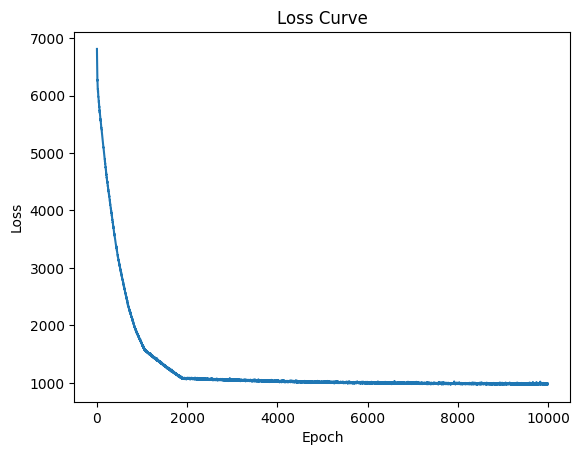

In [25]:
num_inputs = 10  # number of tasks
num_neurons = 128  # number of neurons in the hidden layer
num_latent = 2  # latent space dimension

model_pytorch = PC_IRT_AE(num_inputs=num_inputs, num_neurons=num_neurons, num_latent=num_latent, num_categories=5)

# Convert input to tensor
X_tensor = torch.tensor(X, dtype=torch.float)

# Train the model
model_pytorch.fit(X_tensor)

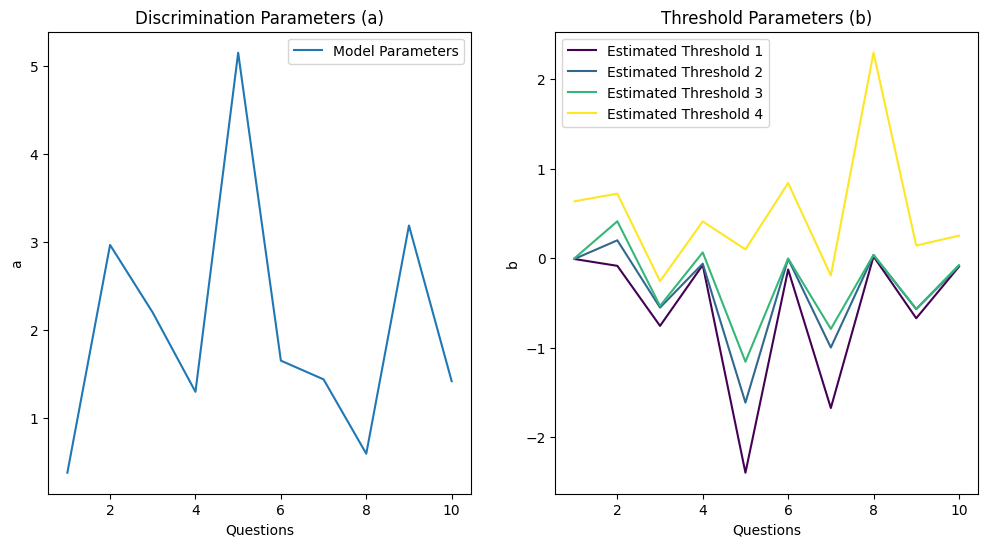

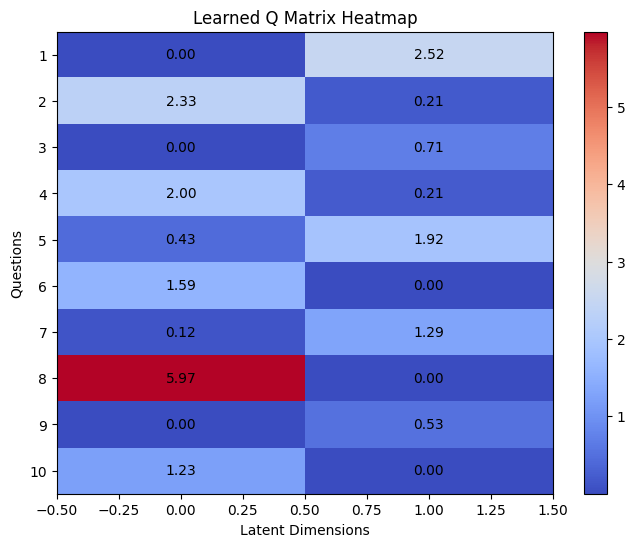

Winkel zwischen den beiden Vektoren: 85.59 Grad
Pearson-Korrelationskoeffizient: -0.56
b values:
 [[-8.9430073e-03 -6.6692899e-03  1.0666151e-03  6.3676375e-01]
 [-8.4877953e-02  2.0043613e-01  4.1288757e-01  7.2174412e-01]
 [-7.5583363e-01 -5.5114895e-01 -5.3276038e-01 -2.5652191e-01]
 [-7.5339802e-02 -6.0576033e-02  6.5213092e-02  4.1108716e-01]
 [-2.3964853e+00 -1.6127968e+00 -1.1561470e+00  9.8449640e-02]
 [-1.2609448e-01 -7.5784484e-03 -2.4729553e-03  8.4054911e-01]
 [-1.6734105e+00 -9.9766934e-01 -7.8999835e-01 -1.9244732e-01]
 [ 2.1003220e-02  3.5664499e-02  3.8507346e-02  2.2965493e+00]
 [-6.7034197e-01 -5.6848341e-01 -5.6644541e-01  1.4230497e-01]
 [-9.3875237e-02 -8.8998944e-02 -7.6185942e-02  2.5205439e-01]]
Differences (should be non-negative):
 []
a values (should be positive):
 [0.37553287 2.9655328  2.1956508  1.2953001  5.15074    1.6498437
 1.4369724  0.59178203 3.1862564  1.4161869 ]
Learned Q matrix:
 [[6.3847547e-04 2.5157526e+00]
 [2.3276558e+00 2.0929708e-01]
 [8.

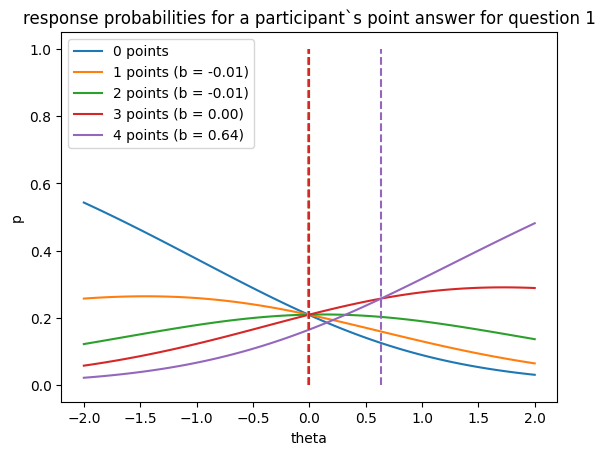

Accuracy: 0.6827272727272727
Mean Absolute Error: 0.4745454545454545
Mean Squared Error: 0.9072727272727275
Quadratic Weighted Kappa: 0.854222836952665
Validation Accuracy: 0.7272727272727273
Validation Mean Absolute Error: 0.39999999999999997
Validation Mean Squared Error: 0.7545454545454545
Validation Quadratic Weighted Kappa: 0.8847804139323574


In [26]:
# Extracting model parameters
diffs = model_pytorch.b[:, 1:] - model_pytorch.b[:, :-1]
b_values = model_pytorch.b.detach().numpy()
a_values = model_pytorch.a.detach().numpy()

# Comparing the discrimination parameters (a)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title('Discrimination Parameters (a)')
plt.plot(np.arange(1, len(a_values) + 1), a_values, label='Model Parameters')  # Shift task index to start from 1
plt.ylabel('a')
plt.xlabel('Questions')
plt.legend()

# Erstelle eine Liste von Farben für die Parameter
colors = plt.cm.viridis(np.linspace(0, 1, b_values.shape[1]))  # z.B. "viridis" Farbschema

#plt.figure(figsize=(12, 6))

# Comparing the threshold parameters (b)
plt.subplot(1, 2, 2)
plt.title('Threshold Parameters (b)')

# Plotte die echten und geschätzten Werte mit gleichen Farben
for j in range(b_values.shape[1]):  # Für jede Spalte (Parameter)
    plt.plot(np.arange(1, len(b_values) + 1), b_values[:, j], label=f'Estimated Threshold {j + 1}', color=colors[j])  # Shift task index to start from 1

plt.ylabel('b')
plt.xlabel('Questions')
plt.legend()

plt.show()


learned_Q = model_pytorch.Q.detach().numpy()


learned_Q_transposed = learned_Q.T


# Heatmap erstellen
plt.figure(figsize=(8, 6))
plt.imshow(learned_Q_transposed, cmap='coolwarm', aspect='auto')

# Colorbar hinzufügen
plt.colorbar()

# Achsenbeschriftungen und Titel
plt.title('Learned Q Matrix Heatmap')
plt.xlabel('Latent Dimensions')
plt.ylabel('Questions')

# Set y-ticks to start from 1 instead of 0
plt.yticks(np.arange(learned_Q_transposed.shape[0]), np.arange(1, learned_Q_transposed.shape[0] + 1))

# Zahlenwerte in die Heatmap einfügen
for i in range(learned_Q_transposed.shape[0]):
    for j in range(learned_Q_transposed.shape[1]):
        plt.text(j, i, f'{learned_Q_transposed[i, j]:.2f}', ha='center', va='center', color='black')

# Heatmap anzeigen
plt.show()

import numpy as np
from numpy.linalg import norm
from scipy.stats import pearsonr

# Spaltenvektoren extrahieren
v1 = learned_Q_transposed[:, 0]  # Erster Vektor (erste Spalte)
v2 = learned_Q_transposed[:, 1]  # Zweiter Vektor (zweite Spalte)

# 1. Winkel zwischen den beiden Vektoren berechnen
cos_theta = np.dot(v1, v2) / (norm(v1) * norm(v2))  # Skalarprodukt / Produkt der Normen
theta = np.arccos(np.clip(cos_theta, -1, 1))  # Winkel in Radiant (mit np.clip, um Rundungsfehler zu vermeiden)
winkel_in_grad = np.degrees(theta)  # In Grad umrechnen

# 2. Pearson-Korrelation zwischen den beiden Vektoren berechnen
correlation, _ = pearsonr(v1, v2)

# Ergebnisse ausgeben
print(f"Winkel zwischen den beiden Vektoren: {winkel_in_grad:.2f} Grad")
print(f"Pearson-Korrelationskoeffizient: {correlation:.2f}")


neg_diffs = diffs[diffs < 0]

print("b values:\n", b_values)
print("Differences (should be non-negative):\n", neg_diffs.detach().numpy())
print("a values (should be positive):\n", a_values)

print("Learned Q matrix:\n", learned_Q_transposed)

def compute_probabilities_for_theta(model, theta_range):
    probabilities = []

    # Loop through each theta value in the specified range
    for theta_val in theta_range:
        # Create a single latent vector for decoding (shape: (1, num_latent))
        theta_tensor = torch.tensor([[0, theta_val]], dtype=torch.float)
        # Get the probabilities from the model for this theta value
        with torch.no_grad():  # Disable gradient tracking
            Y = model.decode(theta_tensor)  # Forward pass with only theta
        probabilities.append(Y.numpy())

    probabilities = np.array(probabilities)

    # Remove the unnecessary '1' dimension
    probabilities = np.squeeze(probabilities, axis=1)  # Shape becomes (100, 7, 4)

    return probabilities



import numpy as np
import matplotlib.pyplot as plt

task = 0

theta_values = np.linspace(-2, 2, 101)
bs = b_values[task, :]
a = a_values[task]

M = len(bs) + 1
N = len(theta_values)

# compute logits
Z = np.zeros((N, M))
Z[:, 1:] = a * (np.expand_dims(theta_values, 1) - np.expand_dims(bs, 0))
Z = np.cumsum(Z, axis=1)

# compute probabilities
P = np.exp(Z) / np.expand_dims(np.sum(np.exp(Z), axis=1), 1)

# Plot the probabilities and store the plot objects
lines = []
for i in range(M):
    line, = plt.plot(theta_values, P[:, i], label=f'{i} points')
    lines.append(line)

plt.xlabel('theta')
plt.ylabel('p')
plt.title(f'response probabilities for a participant`s point answer for question {task + 1}')

legend_entries = ['0 points ']
for j in range(M - 1):
    legend_entries.append(f'{j + 1} points (b = {bs[j]:.2f})')

# Plot vertical lines (thresholds) in the same color as the corresponding probabilities
for j in range(M - 1):
    plt.plot([bs[j], bs[j]], [0, 1], linestyle='--', color=lines[j + 1].get_color())  # Use the color of the corresponding probability curve

plt.legend(legend_entries)
plt.show()


# Make predictions
_, _, _, Xhat_tensor = model_pytorch.forward(X_tensor)

# Convert probabilities to predicted categories
Xhat = torch.argmax(Xhat_tensor, dim=-1).detach().numpy()

#print(X_tensor[0])
#print(Xhat[0])

# Calculate accuracy
accuracy = np.mean(X_tensor.numpy() == Xhat)
print(f"Accuracy: {accuracy}")

# Make predictions on validation set

X_val_tensor = torch.tensor(X_val, dtype=torch.float)
_, _, _, Xhat_val_tensor = model_pytorch.forward(X_val_tensor)

# Convert probabilities to predicted categories for validation set
Xhat_val = torch.argmax(Xhat_val_tensor, dim=-1).detach().numpy()

#print(X_tensor[0])
#print(Xhat[0])

from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(X_tensor.numpy(), Xhat)
print(f"Mean Absolute Error: {mae}")

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(X_tensor.numpy(), Xhat)
print(f"Mean Squared Error: {mse}")


from sklearn.metrics import cohen_kappa_score
X_tensor_flat = X_tensor.numpy().ravel()
X_hat_flat = Xhat.ravel()

# Berechne den quadratisch gewichteten Kappa
kappa = cohen_kappa_score(X_tensor_flat, X_hat_flat, weights='quadratic')
print(f"Quadratic Weighted Kappa: {kappa}")

# Calculate accuracy for validation set
accuracy_val = np.mean(X_val_tensor.numpy() == Xhat_val)
print(f"Validation Accuracy: {accuracy_val}")

# Mean Absolute Error for validation set
mae_val = mean_absolute_error(X_val_tensor.numpy(), Xhat_val)
print(f"Validation Mean Absolute Error: {mae_val}")

# Mean Squared Error for validation set
mse_val = mean_squared_error(X_val_tensor.numpy(), Xhat_val)
print(f"Validation Mean Squared Error: {mse_val}")

# Flatten the tensors for Kappa calculation
X_val_tensor_flat = X_val_tensor.numpy().ravel()
X_hat_val_flat = Xhat_val.ravel()

# Quadratic Weighted Kappa for validation set
kappa_val = cohen_kappa_score(X_val_tensor_flat, X_hat_val_flat, weights='quadratic')
print(f"Validation Quadratic Weighted Kappa: {kappa_val}")

#print(Xhat)

C:\Users\wuepp\AppData\Local\Temp\ipykernel_2336\3702903398.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)


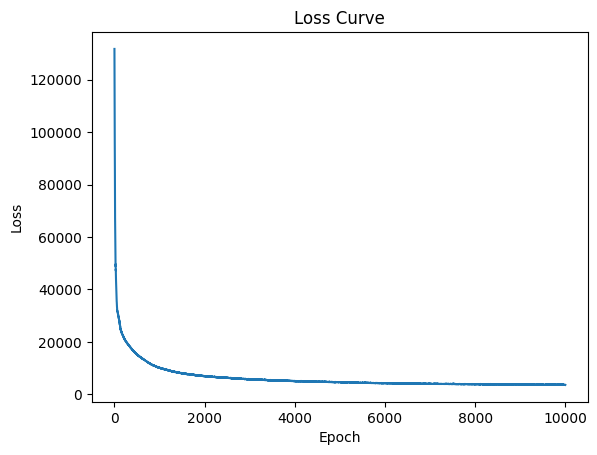

Accuracy: 0.9556818181818182
Mean Absolute Error: 0.04772727191448212
Mean Squared Error: 0.05681817978620529
Quadratic Weighted Kappa: 0.9903414092322957
Validation Accuracy: 0.5909090909090909
Validation Mean Absolute Error: 0.6000000238418579
Validation Mean Squared Error: 1.1090909242630005
Validation Quadratic Weighted Kappa: 0.8087515408896901


In [56]:
from sklearn.metrics import mean_squared_error
num_inputs = 10  # number of tasks
num_neurons = 128  # number of neurons in the hidden layer
num_latent = 2  # latent space dimension
num_categories = 5

model_pytorch = VAE(num_inputs=num_inputs, num_neurons=num_neurons, num_latent=num_latent, num_categories=num_categories)

# Convert input to tensor
X_tensor = torch.tensor(X, dtype=torch.float)

# Train the model
model_pytorch.fit(X_tensor)

# Make predictions
_, _, _, Xhat_tensor = model_pytorch.forward(X_tensor)

# Convert predictions to integer values
Xhat = Xhat_tensor.round().detach().numpy()

# Calculate accuracy
accuracy = np.mean(X_tensor.numpy() == Xhat)
print(f"Accuracy: {accuracy}")

# Make predictions on validation set
X_val_tensor = torch.tensor(X_val, dtype=torch.float)
_, _, _, Xhat_val_tensor = model_pytorch.forward(X_val_tensor)

# Convert probabilities to predicted categories for validation set
Xhat_val = Xhat_val_tensor.round().detach().numpy()

from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(X_tensor.numpy(), Xhat)
print(f"Mean Absolute Error: {mae}")

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(X_tensor.numpy(), Xhat)
print(f"Mean Squared Error: {mse}")


from sklearn.metrics import cohen_kappa_score
X_tensor_flat = X_tensor.numpy().ravel()
X_hat_flat = Xhat.ravel()

# Berechne den quadratisch gewichteten Kappa
kappa = cohen_kappa_score(X_tensor_flat, X_hat_flat, weights='quadratic')
print(f"Quadratic Weighted Kappa: {kappa}")

# Calculate accuracy for validation set
accuracy_val = np.mean(X_val_tensor.numpy() == Xhat_val)
print(f"Validation Accuracy: {accuracy_val}")

# Mean Absolute Error for validation set
mae_val = mean_absolute_error(X_val_tensor.numpy(), Xhat_val)
print(f"Validation Mean Absolute Error: {mae_val}")

# Mean Squared Error for validation set
mse_val = mean_squared_error(X_val_tensor.numpy(), Xhat_val)
print(f"Validation Mean Squared Error: {mse_val}")

# Flatten the tensors for Kappa calculation
X_val_tensor_flat = X_val_tensor.numpy().ravel()
X_hat_val_flat = Xhat_val.ravel()

# Quadratic Weighted Kappa for validation set
kappa_val = cohen_kappa_score(X_val_tensor_flat, X_hat_val_flat, weights='quadratic')
print(f"Validation Quadratic Weighted Kappa: {kappa_val}")

#### Cross Validation

Cross-validation for fold: 1
Epoch 0, Loss: 8082.9150390625


C:\Users\wuepp\AppData\Local\Temp\ipykernel_15076\1231359900.py:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)


Epoch 100, Loss: 6648.91845703125
Epoch 200, Loss: 5992.00244140625
Epoch 300, Loss: 5332.1083984375
Epoch 400, Loss: 4681.48193359375
Epoch 500, Loss: 4085.447998046875
Epoch 600, Loss: 3496.522216796875
Epoch 700, Loss: 3006.2822265625
Epoch 800, Loss: 2642.490234375
Epoch 900, Loss: 2338.084228515625
Epoch 1000, Loss: 2052.00537109375
Epoch 1100, Loss: 1771.2127685546875
Epoch 1200, Loss: 1546.0552978515625
Epoch 1300, Loss: 1360.862060546875
Epoch 1400, Loss: 1203.9927978515625
Epoch 1500, Loss: 1042.6561279296875
Epoch 1600, Loss: 922.9991455078125
Epoch 1700, Loss: 856.47802734375
Epoch 1800, Loss: 851.885986328125
Epoch 1900, Loss: 852.3908081054688
Epoch 2000, Loss: 849.82958984375
Epoch 2100, Loss: 855.0692138671875
Epoch 2200, Loss: 839.5658569335938
Epoch 2300, Loss: 842.4335327148438
Epoch 2400, Loss: 830.4658203125
Epoch 2500, Loss: 828.0385131835938
Epoch 2600, Loss: 837.3111572265625
Epoch 2700, Loss: 830.0726928710938
Epoch 2800, Loss: 827.143798828125
Epoch 2900, Loss:

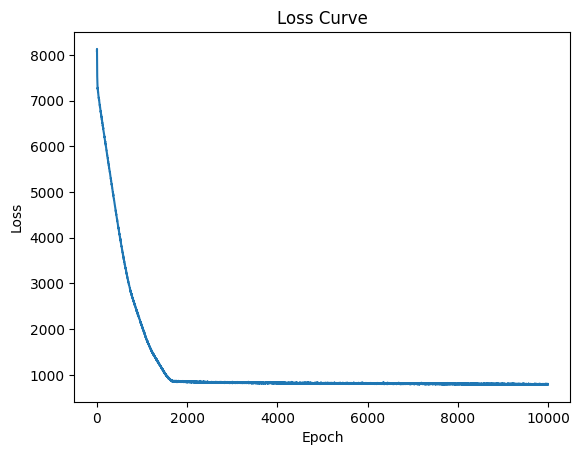

Training Accuracy: 0.6693181818181818
Training Mean Absolute Error: 0.4818181818181818
Training Mean Squared Error: 0.8977272727272728
Training Quadratic Weighted Kappa: 0.8523482406672704


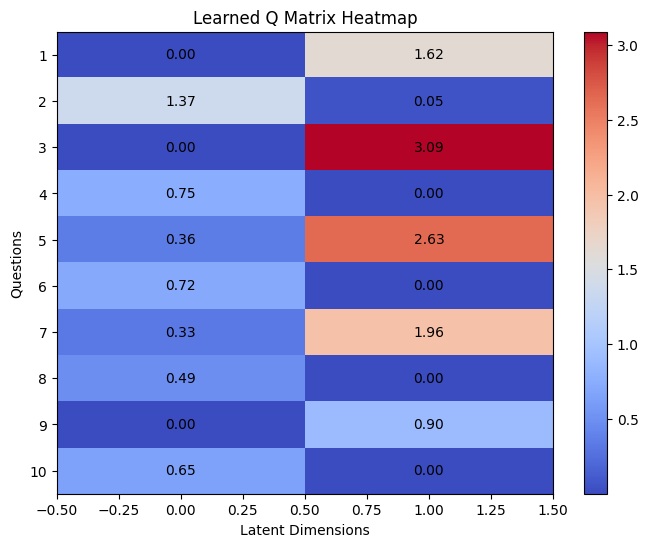

Winkel zwischen den beiden Vektoren: 79.90 Grad
Pearson-Korrelationskoeffizient: -0.66
Validation Accuracy: 0.6727272727272727
Validation Mean Absolute Error: 0.46818181818181814
Validation Mean Squared Error: 0.8681818181818182
Validation Quadratic Weighted Kappa: 0.8633371493989697
--------------------------------------------------
Cross-validation for fold: 2
Epoch 0, Loss: 8239.314453125


C:\Users\wuepp\AppData\Local\Temp\ipykernel_15076\1231359900.py:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)


Epoch 100, Loss: 5547.056640625
Epoch 200, Loss: 4850.76220703125
Epoch 300, Loss: 4256.966796875
Epoch 400, Loss: 3707.939697265625
Epoch 500, Loss: 3309.27001953125
Epoch 600, Loss: 2932.54052734375
Epoch 700, Loss: 2672.885986328125
Epoch 800, Loss: 2423.71435546875
Epoch 900, Loss: 2192.54931640625
Epoch 1000, Loss: 2013.6451416015625
Epoch 1100, Loss: 1835.335205078125
Epoch 1200, Loss: 1674.41162109375
Epoch 1300, Loss: 1494.022216796875
Epoch 1400, Loss: 1321.740966796875
Epoch 1500, Loss: 1161.1103515625
Epoch 1600, Loss: 1051.7630615234375
Epoch 1700, Loss: 1000.9944458007812
Epoch 1800, Loss: 917.4379272460938
Epoch 1900, Loss: 892.5155639648438
Epoch 2000, Loss: 884.9434814453125
Epoch 2100, Loss: 887.2970581054688
Epoch 2200, Loss: 888.392578125
Epoch 2300, Loss: 889.8854370117188
Epoch 2400, Loss: 883.6044921875
Epoch 2500, Loss: 876.9170532226562
Epoch 2600, Loss: 875.5575561523438
Epoch 2700, Loss: 876.0020141601562
Epoch 2800, Loss: 884.3175048828125
Epoch 2900, Loss: 8

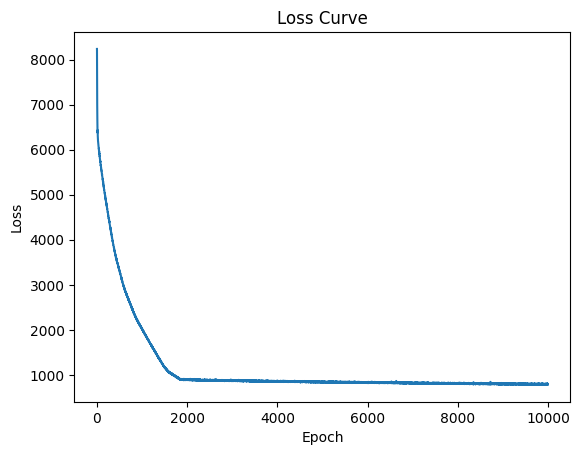

Training Accuracy: 0.6818181818181818
Training Mean Absolute Error: 0.48977272727272725
Training Mean Squared Error: 0.978409090909091
Training Quadratic Weighted Kappa: 0.838088863929512


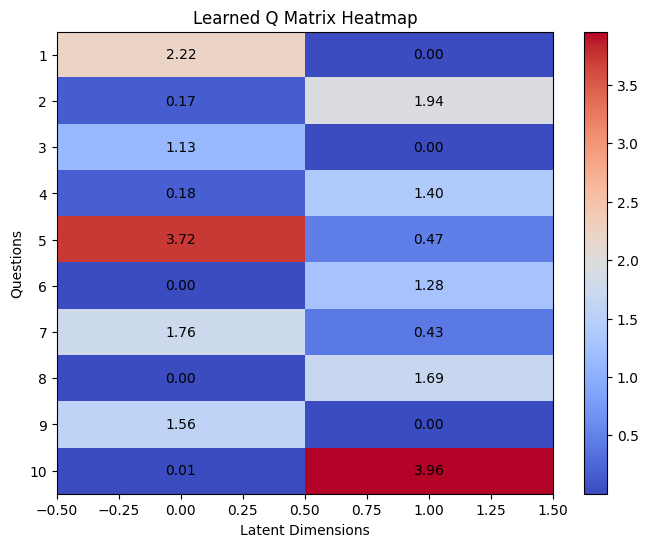

Winkel zwischen den beiden Vektoren: 83.12 Grad
Pearson-Korrelationskoeffizient: -0.64
Validation Accuracy: 0.6818181818181818
Validation Mean Absolute Error: 0.4545454545454545
Validation Mean Squared Error: 0.8454545454545453
Validation Quadratic Weighted Kappa: 0.8722399840143871
--------------------------------------------------
Cross-validation for fold: 3
Epoch 0, Loss: 8492.7314453125


C:\Users\wuepp\AppData\Local\Temp\ipykernel_15076\1231359900.py:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)


Epoch 100, Loss: 6938.59814453125
Epoch 200, Loss: 6194.27099609375
Epoch 300, Loss: 5541.79296875
Epoch 400, Loss: 4903.89453125
Epoch 500, Loss: 4365.2822265625
Epoch 600, Loss: 3888.006103515625
Epoch 700, Loss: 3421.31787109375
Epoch 800, Loss: 2960.079833984375
Epoch 900, Loss: 2515.05126953125
Epoch 1000, Loss: 2121.511962890625
Epoch 1100, Loss: 1714.55615234375
Epoch 1200, Loss: 1404.7421875
Epoch 1300, Loss: 1150.677978515625
Epoch 1400, Loss: 1005.0693359375
Epoch 1500, Loss: 887.27392578125
Epoch 1600, Loss: 840.4854736328125
Epoch 1700, Loss: 822.7708740234375
Epoch 1800, Loss: 828.015625
Epoch 1900, Loss: 830.276611328125
Epoch 2000, Loss: 832.3524780273438
Epoch 2100, Loss: 821.2376708984375
Epoch 2200, Loss: 820.975830078125
Epoch 2300, Loss: 814.7135009765625
Epoch 2400, Loss: 819.1963500976562
Epoch 2500, Loss: 824.6173706054688
Epoch 2600, Loss: 815.6412353515625
Epoch 2700, Loss: 808.2190551757812
Epoch 2800, Loss: 816.2343139648438
Epoch 2900, Loss: 815.111083984375

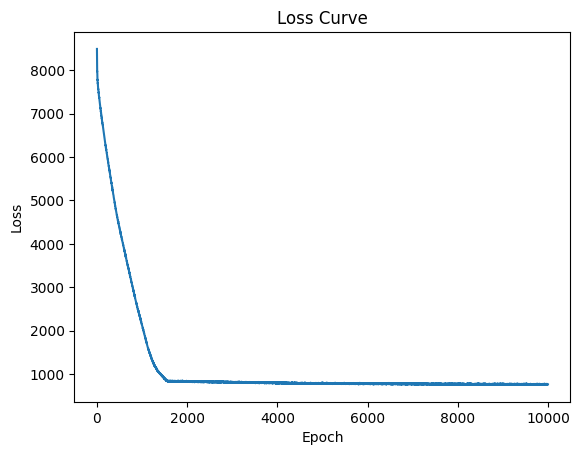

Training Accuracy: 0.6818181818181818
Training Mean Absolute Error: 0.4818181818181818
Training Mean Squared Error: 0.9545454545454545
Training Quadratic Weighted Kappa: 0.8472040322260587


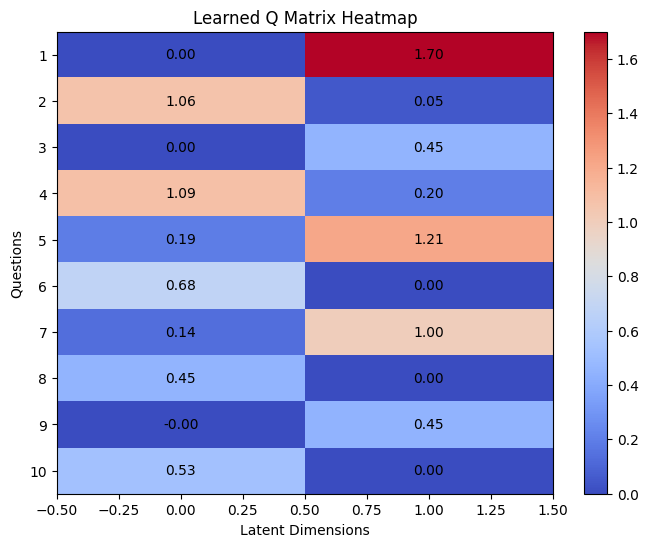

Winkel zwischen den beiden Vektoren: 81.60 Grad
Pearson-Korrelationskoeffizient: -0.64
Validation Accuracy: 0.6318181818181818
Validation Mean Absolute Error: 0.5772727272727273
Validation Mean Squared Error: 1.140909090909091
Validation Quadratic Weighted Kappa: 0.8168806706637661
--------------------------------------------------
Cross-validation for fold: 4
Epoch 0, Loss: 9439.130859375


C:\Users\wuepp\AppData\Local\Temp\ipykernel_15076\1231359900.py:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)


Epoch 100, Loss: 7330.69873046875
Epoch 200, Loss: 6551.35546875
Epoch 300, Loss: 5928.91943359375
Epoch 400, Loss: 5361.6474609375
Epoch 500, Loss: 4856.27783203125
Epoch 600, Loss: 4422.78125
Epoch 700, Loss: 4027.04248046875
Epoch 800, Loss: 3647.053466796875
Epoch 900, Loss: 3299.48291015625
Epoch 1000, Loss: 3030.247802734375
Epoch 1100, Loss: 2761.982177734375
Epoch 1200, Loss: 2498.109619140625
Epoch 1300, Loss: 2225.166748046875
Epoch 1400, Loss: 1976.3338623046875
Epoch 1500, Loss: 1711.574951171875
Epoch 1600, Loss: 1489.0760498046875
Epoch 1700, Loss: 1310.0479736328125
Epoch 1800, Loss: 1206.5166015625
Epoch 1900, Loss: 1119.884521484375
Epoch 2000, Loss: 1026.857177734375
Epoch 2100, Loss: 951.578369140625
Epoch 2200, Loss: 906.0547485351562
Epoch 2300, Loss: 879.5304565429688
Epoch 2400, Loss: 875.6788330078125
Epoch 2500, Loss: 864.143310546875
Epoch 2600, Loss: 865.781494140625
Epoch 2700, Loss: 870.267578125
Epoch 2800, Loss: 849.3723754882812
Epoch 2900, Loss: 855.362

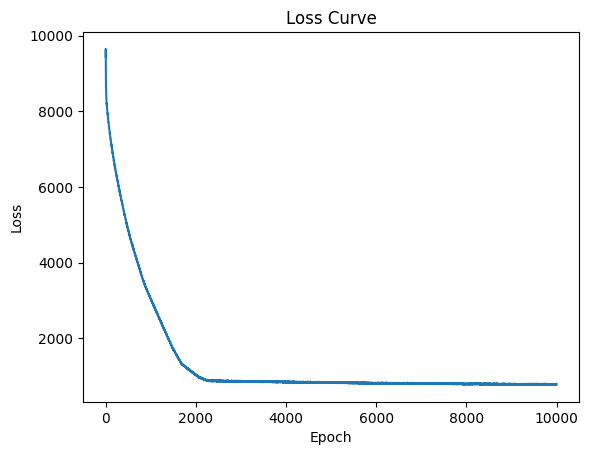

Training Accuracy: 0.6875
Training Mean Absolute Error: 0.45
Training Mean Squared Error: 0.8386363636363636
Training Quadratic Weighted Kappa: 0.865080473065954


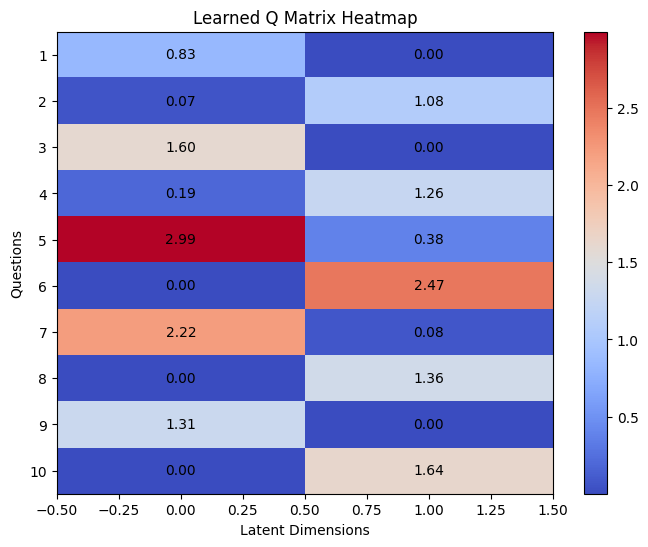

Winkel zwischen den beiden Vektoren: 84.10 Grad
Pearson-Korrelationskoeffizient: -0.72
Validation Accuracy: 0.6227272727272727
Validation Mean Absolute Error: 0.6227272727272727
Validation Mean Squared Error: 1.3045454545454542
Validation Quadratic Weighted Kappa: 0.7896595376107669
--------------------------------------------------
Cross-validation for fold: 5
Epoch 0, Loss: 7237.9765625


C:\Users\wuepp\AppData\Local\Temp\ipykernel_15076\1231359900.py:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)


Epoch 100, Loss: 6136.970703125
Epoch 200, Loss: 5350.20458984375
Epoch 300, Loss: 4636.015625
Epoch 400, Loss: 3983.416748046875
Epoch 500, Loss: 3381.510498046875
Epoch 600, Loss: 2960.13671875
Epoch 700, Loss: 2555.547607421875
Epoch 800, Loss: 2182.99560546875
Epoch 900, Loss: 1898.57421875
Epoch 1000, Loss: 1614.05078125
Epoch 1100, Loss: 1388.10986328125
Epoch 1200, Loss: 1199.31689453125
Epoch 1300, Loss: 1063.7620849609375
Epoch 1400, Loss: 943.3272705078125
Epoch 1500, Loss: 900.8451538085938
Epoch 1600, Loss: 851.494140625
Epoch 1700, Loss: 853.0248413085938
Epoch 1800, Loss: 861.893310546875
Epoch 1900, Loss: 843.9727783203125
Epoch 2000, Loss: 844.21630859375
Epoch 2100, Loss: 839.7225952148438
Epoch 2200, Loss: 844.4306640625
Epoch 2300, Loss: 836.4353637695312
Epoch 2400, Loss: 829.3050537109375
Epoch 2500, Loss: 826.4331665039062
Epoch 2600, Loss: 825.8638305664062
Epoch 2700, Loss: 825.4495849609375
Epoch 2800, Loss: 823.0181884765625
Epoch 2900, Loss: 828.9411010742188

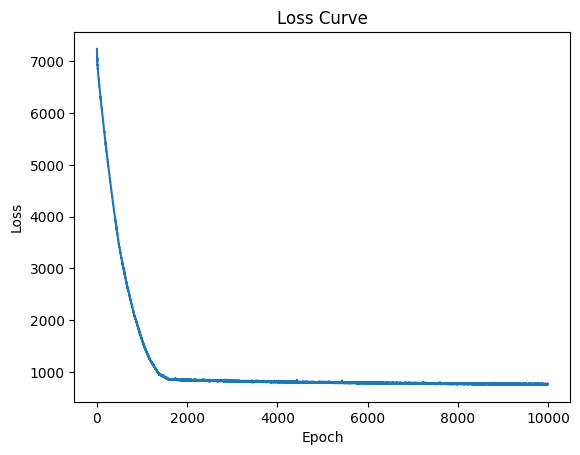

Training Accuracy: 0.7079545454545455
Training Mean Absolute Error: 0.45
Training Mean Squared Error: 0.906818181818182
Training Quadratic Weighted Kappa: 0.8530635201481083


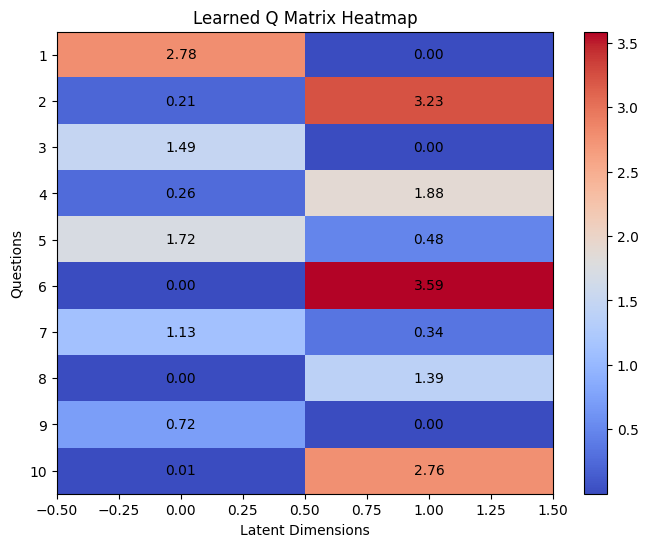

Winkel zwischen den beiden Vektoren: 84.05 Grad
Pearson-Korrelationskoeffizient: -0.75
Validation Accuracy: 0.5772727272727273
Validation Mean Absolute Error: 0.5999999999999999
Validation Mean Squared Error: 1.0727272727272728
Validation Quadratic Weighted Kappa: 0.8166407684701229
--------------------------------------------------
Cross-Validation Performance Summary:
Average Training Accuracy: 0.6856818181818182 ± 0.012625404011210161
Average Validation Accuracy: 0.6372727272727272 ± 0.03763680280815354
Average Training MAE: 0.4706818181818182 ± 0.017134615295427955
Average Validation MAE: 0.5445454545454546 ± 0.06955585186686752
Average Training MSE: 0.9152272727272729 ± 0.048540687542590895
Average Validation MSE: 1.0463636363636362 ± 0.17228172200073105
Average Training Quadratic Weighted Kappa: 0.8511570260073806 ± 0.008778600232338592
Average Validation Quadratic Weighted Kappa: 0.8317516220316025 ± 0.031171075233156396


In [21]:
import numpy as np
import torch
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, cohen_kappa_score

# Assume X2, X4, X3 are defined and preprocessed data matrices

# Combine data matrices along the row axis
X = np.concatenate((X2, X4, X3), axis=0)
#print(X)

num_inputs = 10  # number of tasks
num_neurons = 128  # number of neurons in the hidden layer
num_latent = 2  # latent space dimension

cross_validate_PC_VAE(X, PC_IRT_AE, num_inputs=10, num_neurons=128, num_latent=2, num_categories=5)

cross val vae

Cross-validation for fold: 1


C:\Users\wuepp\AppData\Local\Temp\ipykernel_15076\3702903398.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)


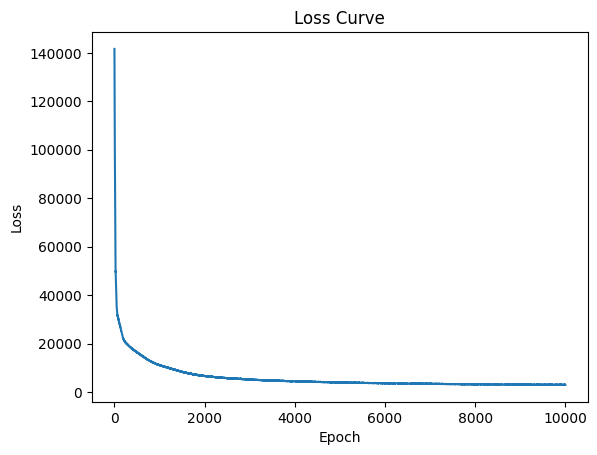

Training Accuracy: 0.9613636363636363
Training Mean Absolute Error: 0.039772726595401764
Training Mean Squared Error: 0.04204545170068741
Training Quadratic Weighted Kappa: 0.9927443155634431
Validation Accuracy: 0.6636363636363637
Validation Mean Absolute Error: 0.44999998807907104
Validation Mean Squared Error: 0.7772727012634277
Validation Quadratic Weighted Kappa: 0.8736328702335205
--------------------------------------------------
Cross-validation for fold: 2


C:\Users\wuepp\AppData\Local\Temp\ipykernel_15076\3702903398.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)


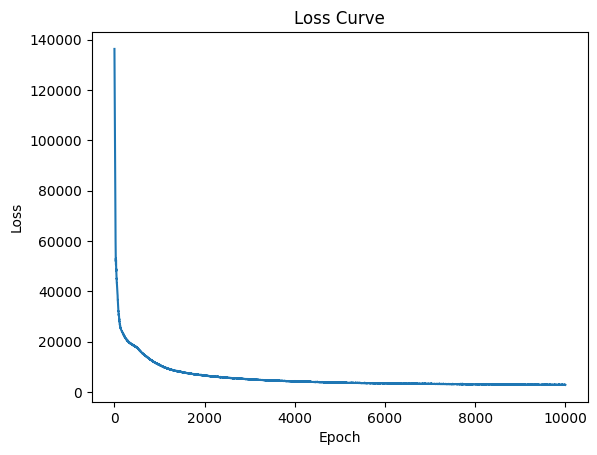

Training Accuracy: 0.9659090909090909
Training Mean Absolute Error: 0.034090910106897354
Training Mean Squared Error: 0.034090910106897354
Training Quadratic Weighted Kappa: 0.9940431385078603
Validation Accuracy: 0.7272727272727273
Validation Mean Absolute Error: 0.41363635659217834
Validation Mean Squared Error: 0.7954546213150024
Validation Quadratic Weighted Kappa: 0.8747266763848396
--------------------------------------------------
Cross-validation for fold: 3


C:\Users\wuepp\AppData\Local\Temp\ipykernel_15076\3702903398.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)


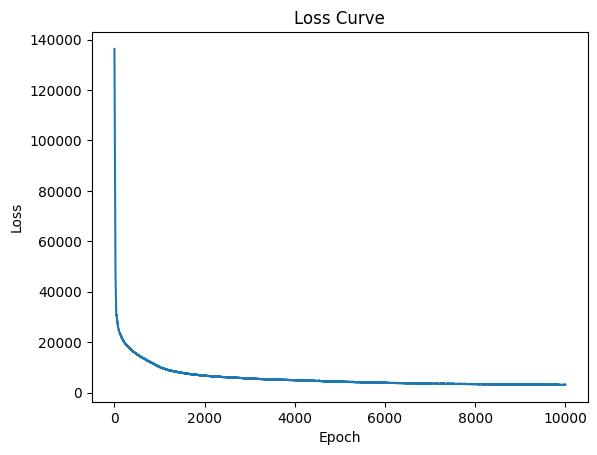

Training Accuracy: 0.9568181818181818
Training Mean Absolute Error: 0.04318181797862053
Training Mean Squared Error: 0.04318181797862053
Training Quadratic Weighted Kappa: 0.9926604473615361
Validation Accuracy: 0.5727272727272728
Validation Mean Absolute Error: 0.7636363506317139
Validation Mean Squared Error: 1.718181848526001
Validation Quadratic Weighted Kappa: 0.6915155651838443
--------------------------------------------------
Cross-validation for fold: 4


C:\Users\wuepp\AppData\Local\Temp\ipykernel_15076\3702903398.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)


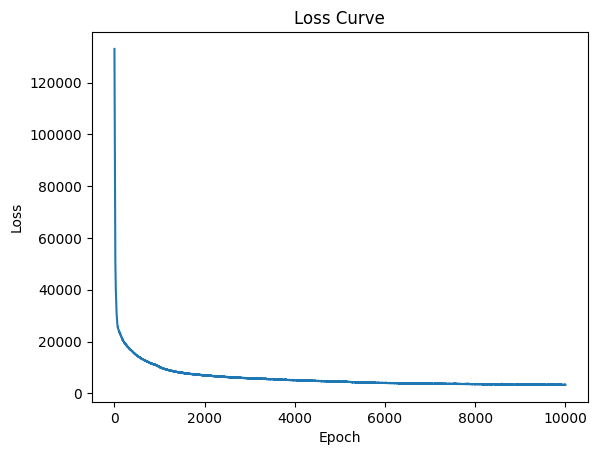

Training Accuracy: 0.9568181818181818
Training Mean Absolute Error: 0.04431818053126335
Training Mean Squared Error: 0.04659091308712959
Training Quadratic Weighted Kappa: 0.9920003263724939
Validation Accuracy: 0.6409090909090909
Validation Mean Absolute Error: 0.5954545736312866
Validation Mean Squared Error: 1.2681818008422852
Validation Quadratic Weighted Kappa: 0.7822323139147094
--------------------------------------------------
Cross-validation for fold: 5


C:\Users\wuepp\AppData\Local\Temp\ipykernel_15076\3702903398.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)


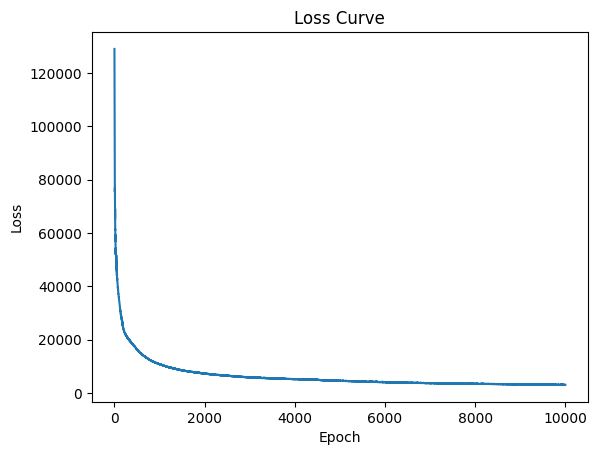

Training Accuracy: 0.9636363636363636
Training Mean Absolute Error: 0.03750000149011612
Training Mean Squared Error: 0.039772726595401764
Training Quadratic Weighted Kappa: 0.993269354321293
Validation Accuracy: 0.6
Validation Mean Absolute Error: 0.6181818246841431
Validation Mean Squared Error: 1.2545454502105713
Validation Quadratic Weighted Kappa: 0.7757754800590841
--------------------------------------------------
Cross-Validation Performance Summary:
Average Training Accuracy: 0.9609090909090909 ± 0.003636363636363654
Average Validation Accuracy: 0.6409090909090909 ± 0.05347433152673726
Average Training MAE: 0.03977273032069206 ± 0.00373447104357183
Average Validation MAE: 0.5681818127632141 ± 0.12593452632427216
Average Training MSE: 0.04113636538386345 ± 0.004153561312705278
Average Validation MSE: 1.1627273559570312 ± 0.34972715377807617
Average Training Quadratic Weighted Kappa: 0.9929435164253253 ± 0.0006818732452379188
Average Validation Quadratic Weighted Kappa: 0.7995765

In [24]:
import numpy as np
import torch
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, cohen_kappa_score

# Annahme: X2, X4, X3 sind definierte und vorverarbeitete Datenmatrizen
X = np.concatenate((X2, X4, X3), axis=0)

num_inputs = 10  # number of tasks
num_neurons = 128  # number of neurons in the hidden layer
num_latent = 2  # latent space dimension

cross_validate_VAE(X, VAE, num_inputs=10, num_neurons=128, num_latent=2, num_categories=5)


### Usability Disability Data set

#### PWDs

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split

# CSV-Datei einlesen (angenommen, die Daten sind Komma-getrennt)
# Anpassen des Delimiters, falls die Daten Tab-getrennt sind: delimiter='\t'
data = np.genfromtxt('usability-data_disability_csv.csv', skip_header=1, delimiter=',')

X = data[:29, 51:61].astype(int)
X = np.delete(X, [17], axis=0)
print(X)
# Die Daten in Training und Validierung aufteilen (z.B. 80% Training, 20% Validierung)
X, X_val = train_test_split(X, test_size=0.2, random_state=42)
N, m = X.shape
print(X)

# Anzahl der Zeilen und Spalten ausgeben
print("number of rows: " + str(N))
print("number of columns: " + str(m))


[[0 0 4 0 4 0 4 0 4 0]
 [4 0 4 0 4 0 4 0 4 1]
 [3 0 3 0 3 1 4 0 2 0]
 [0 0 3 0 3 1 4 2 2 0]
 [3 0 4 0 4 0 4 0 4 0]
 [4 0 4 1 3 1 4 0 3 0]
 [3 1 2 4 3 1 3 1 3 4]
 [4 0 4 0 4 0 4 0 4 0]
 [1 3 0 2 0 3 2 2 1 1]
 [1 0 3 1 3 1 4 1 3 1]
 [0 2 2 4 2 2 3 2 2 0]
 [3 1 3 1 2 2 3 2 2 1]
 [4 0 2 1 1 0 4 0 3 4]
 [4 4 0 4 4 0 4 0 4 0]
 [1 2 1 3 2 2 2 3 1 3]
 [4 0 4 0 4 0 4 0 4 0]
 [4 0 4 0 4 0 4 0 4 0]
 [3 0 4 1 3 0 4 1 3 0]
 [2 2 1 3 2 2 2 3 1 4]
 [3 2 3 1 2 1 4 2 3 3]
 [4 0 4 0 4 0 4 0 4 0]
 [4 0 4 3 3 0 4 0 4 1]
 [4 0 4 2 4 0 4 0 4 4]
 [0 0 2 0 4 0 4 0 4 0]
 [4 0 4 0 3 0 4 0 4 1]
 [2 0 4 4 4 0 2 0 0 4]
 [2 0 4 3 4 3 4 2 3 1]
 [0 2 1 3 0 4 1 3 1 4]]
[[3 0 4 1 3 0 4 1 3 0]
 [4 0 4 2 4 0 4 0 4 4]
 [3 1 3 1 2 2 3 2 2 1]
 [4 4 0 4 4 0 4 0 4 0]
 [4 0 4 0 4 0 4 0 4 0]
 [4 0 4 0 4 0 4 0 4 1]
 [3 0 4 0 4 0 4 0 4 0]
 [4 0 4 1 3 1 4 0 3 0]
 [3 0 3 0 3 1 4 0 2 0]
 [4 0 4 0 4 0 4 0 4 0]
 [0 0 2 0 4 0 4 0 4 0]
 [0 0 3 0 3 1 4 2 2 0]
 [2 0 4 3 4 3 4 2 3 1]
 [4 0 4 0 3 0 4 0 4 1]
 [2 2 1 3 2 2 2 3 1 4]
 [0 2 1 3 

C:\Users\wuepp\AppData\Local\Temp\ipykernel_15468\1030370614.py:10: RuntimeWarning: invalid value encountered in cast
  X = data[:29, 51:61].astype(int)


C:\Users\wuepp\AppData\Local\Temp\ipykernel_15468\3384498399.py:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)


Epoch 0, Loss: 3388.137451171875
Epoch 100, Loss: 2818.02783203125
Epoch 200, Loss: 2383.671142578125
Epoch 300, Loss: 2006.77099609375
Epoch 400, Loss: 1676.860107421875
Epoch 500, Loss: 1397.2763671875
Epoch 600, Loss: 1140.117431640625
Epoch 700, Loss: 937.651123046875
Epoch 800, Loss: 785.638916015625
Epoch 900, Loss: 655.1881713867188
Epoch 1000, Loss: 558.1549682617188
Epoch 1100, Loss: 483.89593505859375
Epoch 1200, Loss: 412.4841613769531
Epoch 1300, Loss: 353.3824768066406
Epoch 1400, Loss: 315.44805908203125
Epoch 1500, Loss: 277.0809020996094
Epoch 1600, Loss: 238.48574829101562
Epoch 1700, Loss: 209.41015625
Epoch 1800, Loss: 207.23138427734375
Epoch 1900, Loss: 204.78993225097656
Epoch 2000, Loss: 202.01190185546875
Epoch 2100, Loss: 200.73768615722656
Epoch 2200, Loss: 200.444580078125
Epoch 2300, Loss: 199.73780822753906
Epoch 2400, Loss: 197.214599609375
Epoch 2500, Loss: 196.59384155273438
Epoch 2600, Loss: 195.09442138671875
Epoch 2700, Loss: 194.53616333007812
Epoch 

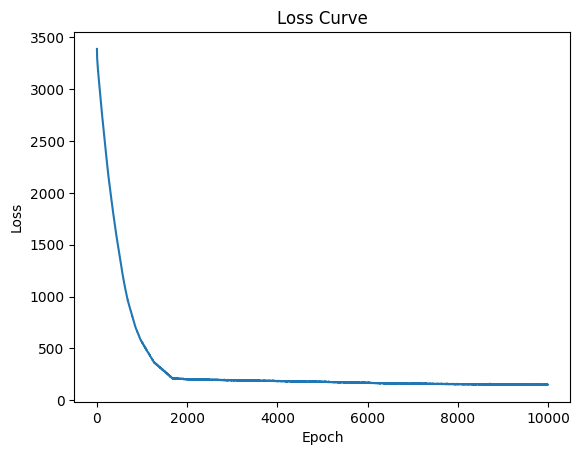

In [22]:
num_inputs = 10  # number of tasks
num_neurons = 128  # number of neurons in the hidden layer

num_latent = 2  # latent space dimension

model_pytorch = PC_IRT_AE(num_inputs=num_inputs, num_neurons=num_neurons, num_latent=num_latent, num_categories=5)

# Convert input to tensor
X_tensor = torch.tensor(X, dtype=torch.float)

# Train the model
model_pytorch.fit(X_tensor)

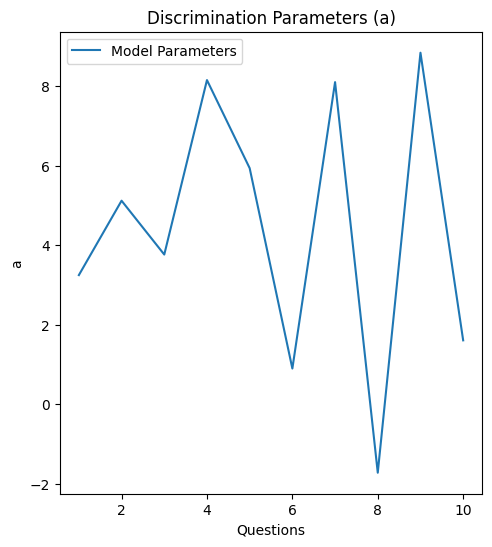

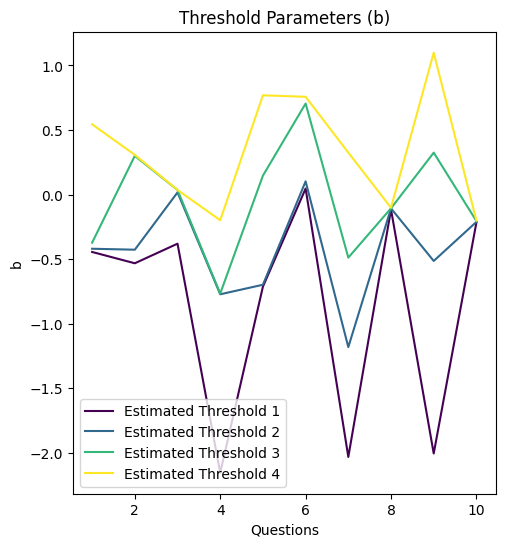

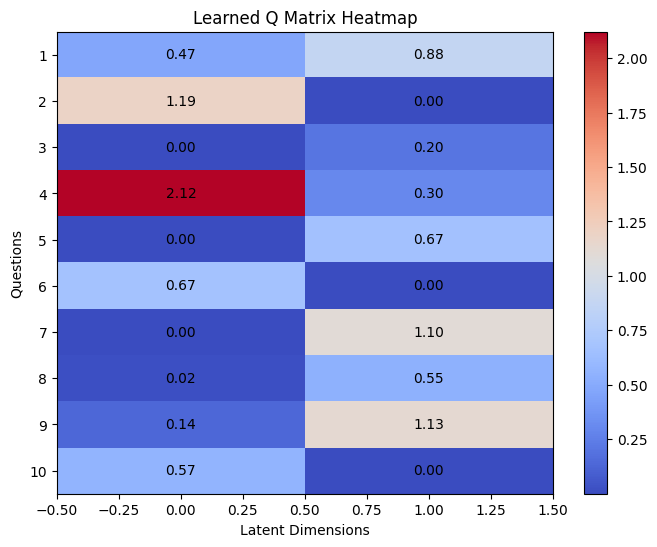

b values:
 [[-0.44433424 -0.419463   -0.3726312   0.5445637 ]
 [-0.5319153  -0.42679882  0.30003193  0.3078274 ]
 [-0.38021073  0.01697617  0.03529673  0.03611823]
 [-2.1540587  -0.77203906 -0.7667397  -0.1987183 ]
 [-0.7130903  -0.69824076  0.14666173  0.76892644]
 [ 0.04672211  0.10255264  0.7052537   0.7573672 ]
 [-2.0316837  -1.1810116  -0.48806792  0.325122  ]
 [-0.11521276 -0.10689923 -0.10617538 -0.10174481]
 [-2.0050814  -0.51397055  0.32487312  1.0987154 ]
 [-0.21579094 -0.21155564 -0.20524193 -0.20091718]]
Differences (should be non-negative):
 []
a values (should be positive):
 [ 3.247356    5.1162205   3.763568    8.145942    5.933343    0.89993954
  8.094693   -1.7168717   8.83346     1.6084535 ]
Learned Q matrix:
 [[4.7471052e-01 8.7615836e-01]
 [1.1913899e+00 1.5403224e-03]
 [2.2887767e-03 2.0010991e-01]
 [2.1211538e+00 3.0300072e-01]
 [4.5723780e-03 6.7049110e-01]
 [6.7146051e-01 4.9045915e-04]
 [1.1325389e-03 1.0968931e+00]
 [1.6827997e-02 5.4576260e-01]
 [1.3769481e-0

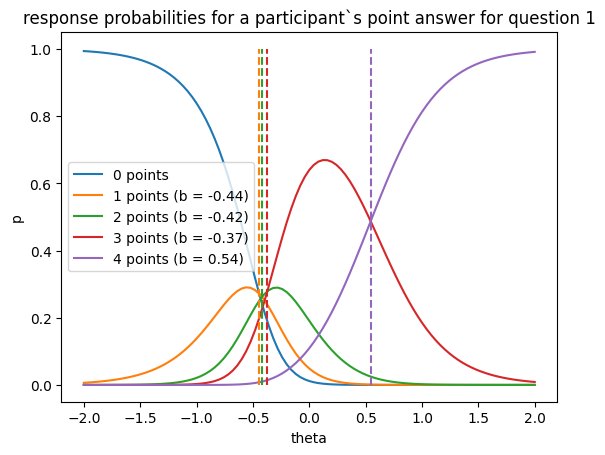

Accuracy: 0.75
Mean Absolute Error: 0.4136363636363636
Mean Squared Error: 0.9045454545454547
Quadratic Weighted Kappa: 0.8429969015377553
Validation Accuracy: 0.5
Validation Mean Absolute Error: 0.8
Validation Mean Squared Error: 1.6
Validation Quadratic Weighted Kappa: 0.7150489759572574


In [23]:
# Extracting model parameters
diffs = model_pytorch.b[:, 1:] - model_pytorch.b[:, :-1]
b_values = model_pytorch.b.detach().numpy()
a_values = model_pytorch.a.detach().numpy()

# Comparing the discrimination parameters (a)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title('Discrimination Parameters (a)')
plt.plot(np.arange(1, len(a_values) + 1), a_values, label='Model Parameters')  # Shift task index to start from 1
plt.ylabel('a')
plt.xlabel('Questions')
plt.legend()

# Erstelle eine Liste von Farben für die Parameter
colors = plt.cm.viridis(np.linspace(0, 1, b_values.shape[1]))  # z.B. "viridis" Farbschema

plt.figure(figsize=(12, 6))

# Comparing the threshold parameters (b)
plt.subplot(1, 2, 2)
plt.title('Threshold Parameters (b)')

# Plotte die echten und geschätzten Werte mit gleichen Farben
for j in range(b_values.shape[1]):  # Für jede Spalte (Parameter)
    plt.plot(np.arange(1, len(b_values) + 1), b_values[:, j], label=f'Estimated Threshold {j + 1}', color=colors[j])  # Shift task index to start from 1

plt.ylabel('b')
plt.xlabel('Questions')
plt.legend()

plt.show()


learned_Q = model_pytorch.Q.detach().numpy()


learned_Q_transposed = learned_Q.T


# Heatmap erstellen
plt.figure(figsize=(8, 6))
plt.imshow(learned_Q_transposed, cmap='coolwarm', aspect='auto')

# Colorbar hinzufügen
plt.colorbar()

# Achsenbeschriftungen und Titel
plt.title('Learned Q Matrix Heatmap')
plt.xlabel('Latent Dimensions')
plt.ylabel('Questions')

# Set y-ticks to start from 1 instead of 0
plt.yticks(np.arange(learned_Q_transposed.shape[0]), np.arange(1, learned_Q_transposed.shape[0] + 1))

# Zahlenwerte in die Heatmap einfügen
for i in range(learned_Q_transposed.shape[0]):
    for j in range(learned_Q_transposed.shape[1]):
        plt.text(j, i, f'{learned_Q_transposed[i, j]:.2f}', ha='center', va='center', color='black')

# Heatmap anzeigen
plt.show()



neg_diffs = diffs[diffs < 0]

print("b values:\n", b_values)
print("Differences (should be non-negative):\n", neg_diffs.detach().numpy())
print("a values (should be positive):\n", a_values)

print("Learned Q matrix:\n", learned_Q_transposed)

def compute_probabilities_for_theta(model, theta_range):
    probabilities = []

    # Loop through each theta value in the specified range
    for theta_val in theta_range:
        # Create a single latent vector for decoding (shape: (1, num_latent))
        theta_tensor = torch.tensor([[0, theta_val]], dtype=torch.float)
        # Get the probabilities from the model for this theta value
        with torch.no_grad():  # Disable gradient tracking
            Y = model.decode(theta_tensor)  # Forward pass with only theta
        probabilities.append(Y.numpy())

    probabilities = np.array(probabilities)

    # Remove the unnecessary '1' dimension
    probabilities = np.squeeze(probabilities, axis=1)  # Shape becomes (100, 7, 4)

    return probabilities



import numpy as np
import matplotlib.pyplot as plt

task = 0

theta_values = np.linspace(-2, 2, 101)
bs = b_values[task, :]
a = a_values[task]

M = len(bs) + 1
N = len(theta_values)

# compute logits
Z = np.zeros((N, M))
Z[:, 1:] = a * (np.expand_dims(theta_values, 1) - np.expand_dims(bs, 0))
Z = np.cumsum(Z, axis=1)

# compute probabilities
P = np.exp(Z) / np.expand_dims(np.sum(np.exp(Z), axis=1), 1)

# Plot the probabilities and store the plot objects
lines = []
for i in range(M):
    line, = plt.plot(theta_values, P[:, i], label=f'{i} points')
    lines.append(line)

plt.xlabel('theta')
plt.ylabel('p')
plt.title(f'response probabilities for a participant`s point answer for question {task + 1}')

legend_entries = ['0 points ']
for j in range(M - 1):
    legend_entries.append(f'{j + 1} points (b = {bs[j]:.2f})')

# Plot vertical lines (thresholds) in the same color as the corresponding probabilities
for j in range(M - 1):
    plt.plot([bs[j], bs[j]], [0, 1], linestyle='--', color=lines[j + 1].get_color())  # Use the color of the corresponding probability curve

plt.legend(legend_entries)
plt.show()


# Make predictions
_, _, _, Xhat_tensor = model_pytorch.forward(X_tensor)

# Convert probabilities to predicted categories
Xhat = torch.argmax(Xhat_tensor, dim=-1).detach().numpy()

#print(X_tensor[0])
#print(Xhat[0])

# Calculate accuracy
accuracy = np.mean(X_tensor.numpy() == Xhat)
print(f"Accuracy: {accuracy}")

# Make predictions on validation set

X_val_tensor = torch.tensor(X_val, dtype=torch.float)
_, _, _, Xhat_val_tensor = model_pytorch.forward(X_val_tensor)

# Convert probabilities to predicted categories for validation set
Xhat_val = torch.argmax(Xhat_val_tensor, dim=-1).detach().numpy()

#print(X_tensor[0])
#print(Xhat[0])

from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(X_tensor.numpy(), Xhat)
print(f"Mean Absolute Error: {mae}")

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(X_tensor.numpy(), Xhat)
print(f"Mean Squared Error: {mse}")


from sklearn.metrics import cohen_kappa_score
X_tensor_flat = X_tensor.numpy().ravel()
X_hat_flat = Xhat.ravel()

# Berechne den quadratisch gewichteten Kappa
kappa = cohen_kappa_score(X_tensor_flat, X_hat_flat, weights='quadratic')
print(f"Quadratic Weighted Kappa: {kappa}")

# Calculate accuracy for validation set
accuracy_val = np.mean(X_val_tensor.numpy() == Xhat_val)
print(f"Validation Accuracy: {accuracy_val}")

# Mean Absolute Error for validation set
mae_val = mean_absolute_error(X_val_tensor.numpy(), Xhat_val)
print(f"Validation Mean Absolute Error: {mae_val}")

# Mean Squared Error for validation set
mse_val = mean_squared_error(X_val_tensor.numpy(), Xhat_val)
print(f"Validation Mean Squared Error: {mse_val}")

# Flatten the tensors for Kappa calculation
X_val_tensor_flat = X_val_tensor.numpy().ravel()
X_hat_val_flat = Xhat_val.ravel()

# Quadratic Weighted Kappa for validation set
kappa_val = cohen_kappa_score(X_val_tensor_flat, X_hat_val_flat, weights='quadratic')
print(f"Validation Quadratic Weighted Kappa: {kappa_val}")

#print(Xhat)

C:\Users\wuepp\AppData\Local\Temp\ipykernel_15468\3702903398.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)


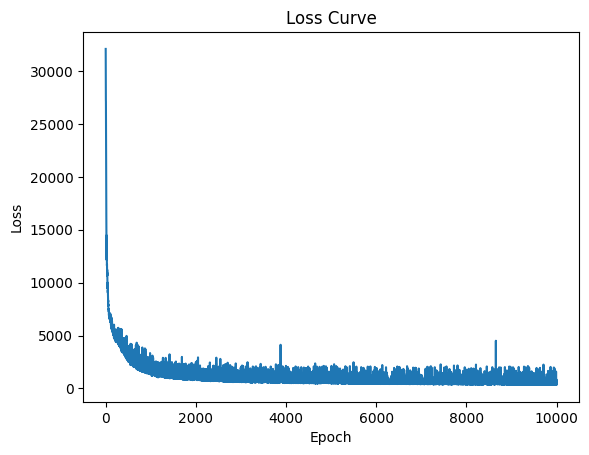

Accuracy: 0.990909090909091
Mean Absolute Error: 0.009090909734368324
Mean Squared Error: 0.009090909734368324
Quadratic Weighted Kappa: 0.9982720296582546
Validation Accuracy: 0.4166666666666667
Validation Mean Absolute Error: 0.966666579246521
Validation Mean Squared Error: 2.0333333015441895
Validation Quadratic Weighted Kappa: 0.5696649029982364


In [24]:
num_inputs = 10  # number of tasks
num_neurons = 128  # number of neurons in the hidden layer
num_latent = 2  # latent space dimension
num_categories = 5

model_pytorch = VAE(num_inputs=num_inputs, num_neurons=num_neurons, num_latent=num_latent, num_categories=num_categories)

# Convert input to tensor
X_tensor = torch.tensor(X, dtype=torch.float)

# Train the model
model_pytorch.fit(X_tensor)

# Make predictions
_, _, _, Xhat_tensor = model_pytorch.forward(X_tensor)

# Convert predictions to integer values
Xhat = Xhat_tensor.round().detach().numpy()

# Calculate accuracy
accuracy = np.mean(X_tensor.numpy() == Xhat)
print(f"Accuracy: {accuracy}")

# Make predictions on validation set
X_val_tensor = torch.tensor(X_val, dtype=torch.float)
_, _, _, Xhat_val_tensor = model_pytorch.forward(X_val_tensor)

# Convert probabilities to predicted categories for validation set
Xhat_val = Xhat_val_tensor.round().detach().numpy()

from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(X_tensor.numpy(), Xhat)
print(f"Mean Absolute Error: {mae}")

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(X_tensor.numpy(), Xhat)
print(f"Mean Squared Error: {mse}")


from sklearn.metrics import cohen_kappa_score
X_tensor_flat = X_tensor.numpy().ravel()
X_hat_flat = Xhat.ravel()

# Berechne den quadratisch gewichteten Kappa
kappa = cohen_kappa_score(X_tensor_flat, X_hat_flat, weights='quadratic')
print(f"Quadratic Weighted Kappa: {kappa}")

# Calculate accuracy for validation set
accuracy_val = np.mean(X_val_tensor.numpy() == Xhat_val)
print(f"Validation Accuracy: {accuracy_val}")

# Mean Absolute Error for validation set
mae_val = mean_absolute_error(X_val_tensor.numpy(), Xhat_val)
print(f"Validation Mean Absolute Error: {mae_val}")

# Mean Squared Error for validation set
mse_val = mean_squared_error(X_val_tensor.numpy(), Xhat_val)
print(f"Validation Mean Squared Error: {mse_val}")

# Flatten the tensors for Kappa calculation
X_val_tensor_flat = X_val_tensor.numpy().ravel()
X_hat_val_flat = Xhat_val.ravel()

# Quadratic Weighted Kappa for validation set
kappa_val = cohen_kappa_score(X_val_tensor_flat, X_hat_val_flat, weights='quadratic')
print(f"Validation Quadratic Weighted Kappa: {kappa_val}")


Cross-validation for fold: 1
Epoch 0, Loss: 3436.57275390625


C:\Users\wuepp\AppData\Local\Temp\ipykernel_15468\2447860930.py:6: RuntimeWarning: invalid value encountered in cast
  X = data[:29, 51:61].astype(int)
C:\Users\wuepp\AppData\Local\Temp\ipykernel_15468\3384498399.py:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)


Epoch 100, Loss: 2861.35107421875
Epoch 200, Loss: 2463.807373046875
Epoch 300, Loss: 2082.043212890625
Epoch 400, Loss: 1711.7783203125
Epoch 500, Loss: 1354.56982421875
Epoch 600, Loss: 1045.1131591796875
Epoch 700, Loss: 815.2355346679688
Epoch 800, Loss: 634.3001098632812
Epoch 900, Loss: 486.3056640625
Epoch 1000, Loss: 363.8796081542969
Epoch 1100, Loss: 276.9344787597656
Epoch 1200, Loss: 232.0653076171875
Epoch 1300, Loss: 204.30770874023438
Epoch 1400, Loss: 204.43507385253906
Epoch 1500, Loss: 201.9168701171875
Epoch 1600, Loss: 199.81585693359375
Epoch 1700, Loss: 197.42283630371094
Epoch 1800, Loss: 198.88394165039062
Epoch 1900, Loss: 196.2584228515625
Epoch 2000, Loss: 196.17857360839844
Epoch 2100, Loss: 193.81993103027344
Epoch 2200, Loss: 193.31005859375
Epoch 2300, Loss: 192.97695922851562
Epoch 2400, Loss: 189.7601776123047
Epoch 2500, Loss: 190.42724609375
Epoch 2600, Loss: 189.61505126953125
Epoch 2700, Loss: 188.0487823486328
Epoch 2800, Loss: 186.82945251464844
E

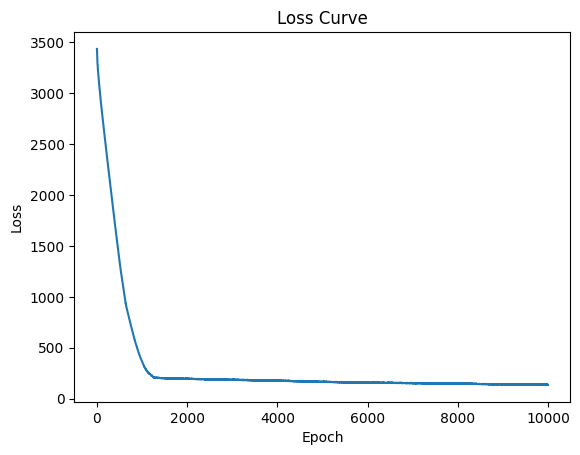

Training Accuracy: 0.8136363636363636
Training Mean Absolute Error: 0.2818181818181818
Training Mean Squared Error: 0.5727272727272728
Training Quadratic Weighted Kappa: 0.8951992801566718
Validation Accuracy: 0.5
Validation Mean Absolute Error: 0.8
Validation Mean Squared Error: 1.5666666666666667
Validation Quadratic Weighted Kappa: 0.701871233745639
--------------------------------------------------
Cross-validation for fold: 2
Epoch 0, Loss: 3529.593994140625


C:\Users\wuepp\AppData\Local\Temp\ipykernel_15468\3384498399.py:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)


Epoch 100, Loss: 2832.10107421875
Epoch 200, Loss: 2348.766845703125
Epoch 300, Loss: 1898.971435546875
Epoch 400, Loss: 1501.3460693359375
Epoch 500, Loss: 1137.868896484375
Epoch 600, Loss: 890.5640869140625
Epoch 700, Loss: 701.7332153320312
Epoch 800, Loss: 572.7219848632812
Epoch 900, Loss: 457.9964904785156
Epoch 1000, Loss: 378.5055236816406
Epoch 1100, Loss: 302.4209289550781
Epoch 1200, Loss: 231.96966552734375
Epoch 1300, Loss: 222.22879028320312
Epoch 1400, Loss: 219.6608428955078
Epoch 1500, Loss: 217.56558227539062
Epoch 1600, Loss: 218.48995971679688
Epoch 1700, Loss: 215.88633728027344
Epoch 1800, Loss: 212.92391967773438
Epoch 1900, Loss: 212.22520446777344
Epoch 2000, Loss: 211.30935668945312
Epoch 2100, Loss: 208.55873107910156
Epoch 2200, Loss: 208.01220703125
Epoch 2300, Loss: 207.2439422607422
Epoch 2400, Loss: 204.84959411621094
Epoch 2500, Loss: 204.2284393310547
Epoch 2600, Loss: 204.1864013671875
Epoch 2700, Loss: 203.06375122070312
Epoch 2800, Loss: 202.371520

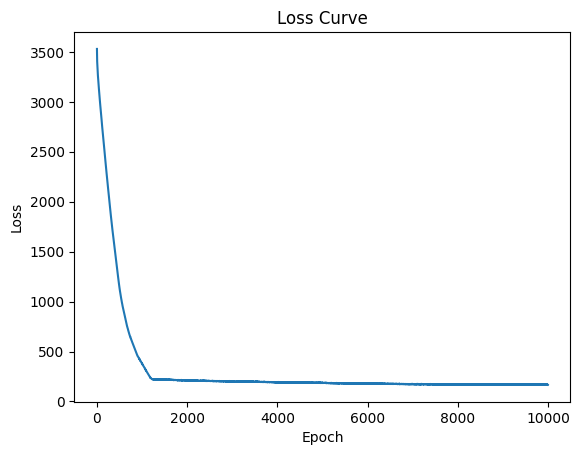

Training Accuracy: 0.7227272727272728
Training Mean Absolute Error: 0.35
Training Mean Squared Error: 0.5227272727272727
Training Quadratic Weighted Kappa: 0.8976702798899854
Validation Accuracy: 0.6166666666666667
Validation Mean Absolute Error: 0.6666666666666667
Validation Mean Squared Error: 1.6333333333333333
Validation Quadratic Weighted Kappa: 0.7447916666666667
--------------------------------------------------
Cross-validation for fold: 3
Epoch 0, Loss: 3308.6943359375


C:\Users\wuepp\AppData\Local\Temp\ipykernel_15468\3384498399.py:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)


Epoch 100, Loss: 2646.704833984375
Epoch 200, Loss: 2134.87841796875
Epoch 300, Loss: 1685.6273193359375
Epoch 400, Loss: 1305.2291259765625
Epoch 500, Loss: 963.6555786132812
Epoch 600, Loss: 736.4453735351562
Epoch 700, Loss: 596.811279296875
Epoch 800, Loss: 480.3977966308594
Epoch 900, Loss: 372.64984130859375
Epoch 1000, Loss: 316.42474365234375
Epoch 1100, Loss: 272.899658203125
Epoch 1200, Loss: 248.9095916748047
Epoch 1300, Loss: 247.50436401367188
Epoch 1400, Loss: 245.6376190185547
Epoch 1500, Loss: 242.299072265625
Epoch 1600, Loss: 240.37660217285156
Epoch 1700, Loss: 238.24940490722656
Epoch 1800, Loss: 237.5941162109375
Epoch 1900, Loss: 234.254638671875
Epoch 2000, Loss: 234.38284301757812
Epoch 2100, Loss: 233.76150512695312
Epoch 2200, Loss: 232.55819702148438
Epoch 2300, Loss: 230.85569763183594
Epoch 2400, Loss: 229.04464721679688
Epoch 2500, Loss: 228.08639526367188
Epoch 2600, Loss: 227.05557250976562
Epoch 2700, Loss: 226.52256774902344
Epoch 2800, Loss: 225.00090

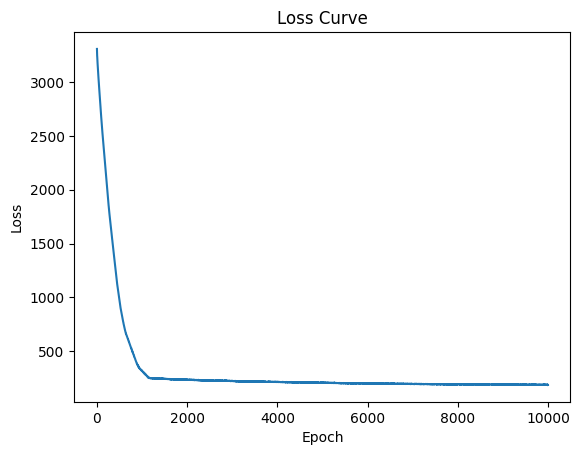

Training Accuracy: 0.6954545454545454
Training Mean Absolute Error: 0.5454545454545454
Training Mean Squared Error: 1.290909090909091
Training Quadratic Weighted Kappa: 0.7578895157790315
Validation Accuracy: 0.65
Validation Mean Absolute Error: 0.45
Validation Mean Squared Error: 0.6833333333333333
Validation Quadratic Weighted Kappa: 0.8960270498732037
--------------------------------------------------
Cross-validation for fold: 4
Epoch 0, Loss: 4414.845703125


C:\Users\wuepp\AppData\Local\Temp\ipykernel_15468\3384498399.py:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)


Epoch 100, Loss: 3920.244873046875
Epoch 200, Loss: 3507.131103515625
Epoch 300, Loss: 3120.728515625
Epoch 400, Loss: 2780.934326171875
Epoch 500, Loss: 2450.892578125
Epoch 600, Loss: 2131.67822265625
Epoch 700, Loss: 1850.201904296875
Epoch 800, Loss: 1579.5548095703125
Epoch 900, Loss: 1344.932861328125
Epoch 1000, Loss: 1115.8447265625
Epoch 1100, Loss: 954.8916625976562
Epoch 1200, Loss: 816.6265258789062
Epoch 1300, Loss: 713.1025390625
Epoch 1400, Loss: 634.7249145507812
Epoch 1500, Loss: 552.6384887695312
Epoch 1600, Loss: 487.9425964355469
Epoch 1700, Loss: 437.8274841308594
Epoch 1800, Loss: 391.779541015625
Epoch 1900, Loss: 346.5186462402344
Epoch 2000, Loss: 303.63226318359375
Epoch 2100, Loss: 259.6455383300781
Epoch 2200, Loss: 225.96212768554688
Epoch 2300, Loss: 225.2628631591797
Epoch 2400, Loss: 222.89358520507812
Epoch 2500, Loss: 222.16537475585938
Epoch 2600, Loss: 221.60557556152344
Epoch 2700, Loss: 220.58340454101562
Epoch 2800, Loss: 221.71383666992188
Epoch 

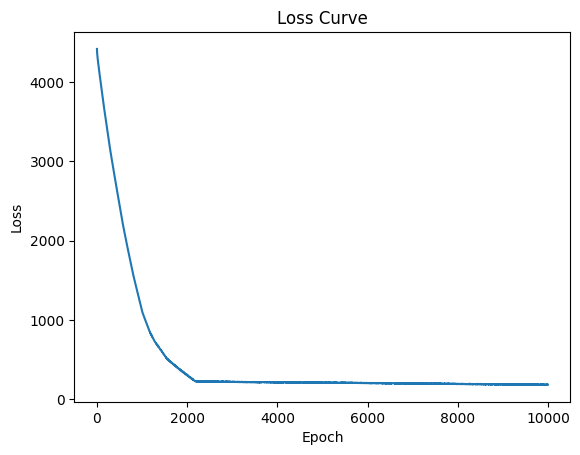

Training Accuracy: 0.7260869565217392
Training Mean Absolute Error: 0.4304347826086956
Training Mean Squared Error: 0.8652173913043478
Training Quadratic Weighted Kappa: 0.8483060790253409
Validation Accuracy: 0.6
Validation Mean Absolute Error: 0.5800000000000001
Validation Mean Squared Error: 1.02
Validation Quadratic Weighted Kappa: 0.8173614095401804
--------------------------------------------------
Cross-validation for fold: 5
Epoch 0, Loss: 2774.53369140625


C:\Users\wuepp\AppData\Local\Temp\ipykernel_15468\3384498399.py:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)


Epoch 100, Loss: 2275.554931640625
Epoch 200, Loss: 1911.1239013671875
Epoch 300, Loss: 1647.260009765625
Epoch 400, Loss: 1405.6995849609375
Epoch 500, Loss: 1173.9464111328125
Epoch 600, Loss: 1018.21337890625
Epoch 700, Loss: 908.8084716796875
Epoch 800, Loss: 804.6300659179688
Epoch 900, Loss: 706.7625122070312
Epoch 1000, Loss: 605.107421875
Epoch 1100, Loss: 514.6539306640625
Epoch 1200, Loss: 452.04083251953125
Epoch 1300, Loss: 393.2925720214844
Epoch 1400, Loss: 361.9580993652344
Epoch 1500, Loss: 329.1189270019531
Epoch 1600, Loss: 295.6192626953125
Epoch 1700, Loss: 264.2375793457031
Epoch 1800, Loss: 231.00875854492188
Epoch 1900, Loss: 217.5856170654297
Epoch 2000, Loss: 216.9100799560547
Epoch 2100, Loss: 216.63140869140625
Epoch 2200, Loss: 213.10614013671875
Epoch 2300, Loss: 212.77537536621094
Epoch 2400, Loss: 212.5223388671875
Epoch 2500, Loss: 211.40850830078125
Epoch 2600, Loss: 211.24562072753906
Epoch 2700, Loss: 210.25534057617188
Epoch 2800, Loss: 208.449996948

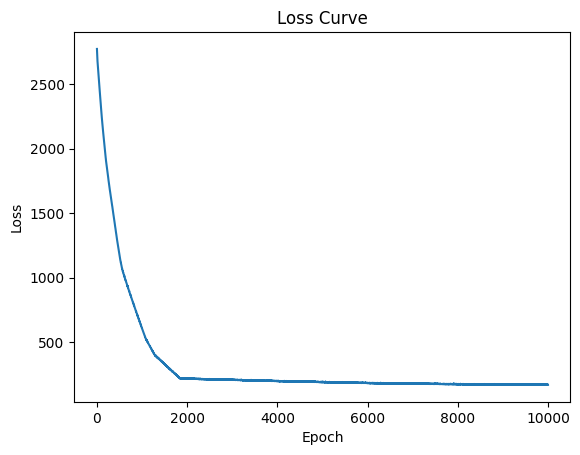

Training Accuracy: 0.7260869565217392
Training Mean Absolute Error: 0.3695652173913043
Training Mean Squared Error: 0.6391304347826087
Training Quadratic Weighted Kappa: 0.8927993912299058
Validation Accuracy: 0.5
Validation Mean Absolute Error: 0.66
Validation Mean Squared Error: 0.9799999999999999
Validation Quadratic Weighted Kappa: 0.7620897261604195
--------------------------------------------------
Cross-Validation Performance Summary:
Average Training Accuracy: 0.736798418972332 ± 0.04010200401465812
Average Validation Accuracy: 0.5733333333333334 ± 0.06200358412579426
Average Training MAE: 0.3954545454545454 ± 0.08873918316268402
Average Validation MAE: 0.6313333333333334 ± 0.11492219590275461
Average Training MSE: 0.7781422924901187 ± 0.28187526377540445
Average Validation MSE: 1.1766666666666667 ± 0.36530656836264097
Average Training Quadratic Weighted Kappa: 0.8583729092161871 ± 0.05344885598232858
Average Validation Quadratic Weighted Kappa: 0.7844282171972219 ± 0.066969566

In [25]:
import numpy as np
import torch
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, cohen_kappa_score

X = data[:29, 51:61].astype(int)
X = np.delete(X, [17], axis=0)

cross_validate_PC_VAE(X, PC_IRT_AE, num_inputs=10, num_neurons=128, num_latent=2, num_categories=5)


Cross-validation for fold: 1


C:\Users\wuepp\AppData\Local\Temp\ipykernel_15468\544932530.py:6: RuntimeWarning: invalid value encountered in cast
  X = data[:29, 51:61].astype(int)
C:\Users\wuepp\AppData\Local\Temp\ipykernel_15468\3702903398.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)


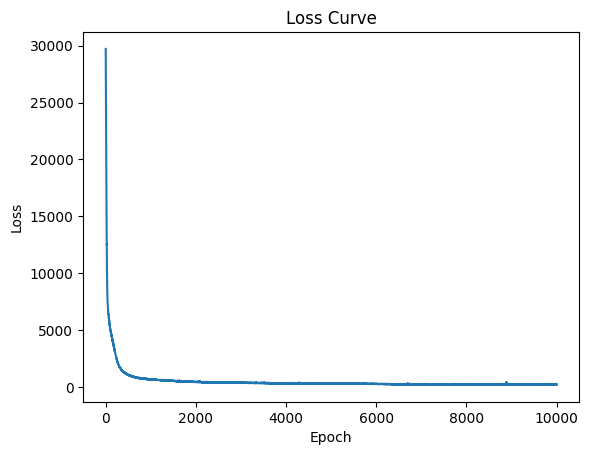

Training Accuracy: 1.0
Training Mean Absolute Error: 0.0
Training Mean Squared Error: 0.0
Training Quadratic Weighted Kappa: 1.0
Validation Accuracy: 0.5166666666666667
Validation Mean Absolute Error: 0.7999999523162842
Validation Mean Squared Error: 1.7666666507720947
Validation Quadratic Weighted Kappa: 0.6717249922576649
--------------------------------------------------
Cross-validation for fold: 2


C:\Users\wuepp\AppData\Local\Temp\ipykernel_15468\3702903398.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)


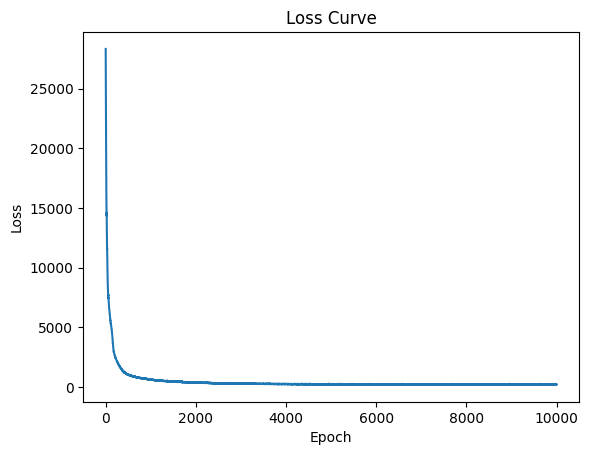

Training Accuracy: 1.0
Training Mean Absolute Error: 0.0
Training Mean Squared Error: 0.0
Training Quadratic Weighted Kappa: 1.0
Validation Accuracy: 0.6166666666666667
Validation Mean Absolute Error: 0.6166666150093079
Validation Mean Squared Error: 1.2833333015441895
Validation Quadratic Weighted Kappa: 0.7857142857142857
--------------------------------------------------
Cross-validation for fold: 3


C:\Users\wuepp\AppData\Local\Temp\ipykernel_15468\3702903398.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)


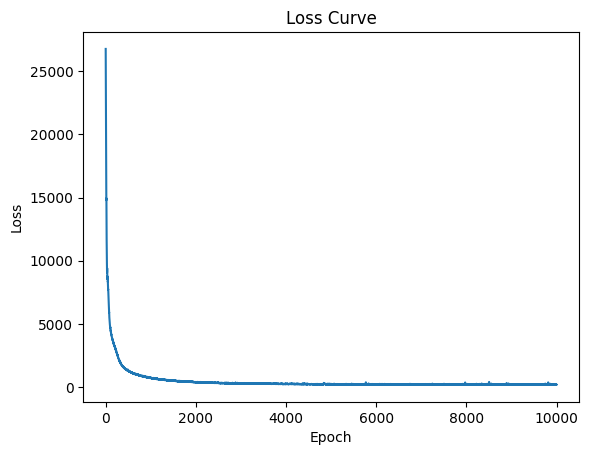

Training Accuracy: 1.0
Training Mean Absolute Error: 0.0
Training Mean Squared Error: 0.0
Training Quadratic Weighted Kappa: 1.0
Validation Accuracy: 0.6666666666666666
Validation Mean Absolute Error: 0.43333330750465393
Validation Mean Squared Error: 0.6666666269302368
Validation Quadratic Weighted Kappa: 0.8994974874371859
--------------------------------------------------
Cross-validation for fold: 4


C:\Users\wuepp\AppData\Local\Temp\ipykernel_15468\3702903398.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)


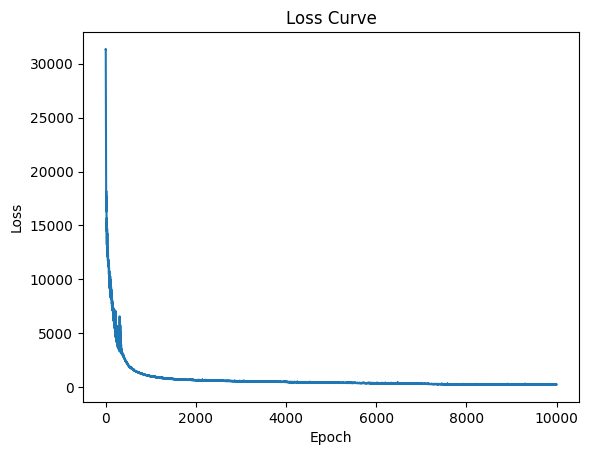

Training Accuracy: 1.0
Training Mean Absolute Error: 0.0
Training Mean Squared Error: 0.0
Training Quadratic Weighted Kappa: 1.0
Validation Accuracy: 0.52
Validation Mean Absolute Error: 0.5600000023841858
Validation Mean Squared Error: 0.7599999904632568
Validation Quadratic Weighted Kappa: 0.8353838156298735
--------------------------------------------------
Cross-validation for fold: 5


C:\Users\wuepp\AppData\Local\Temp\ipykernel_15468\3702903398.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)


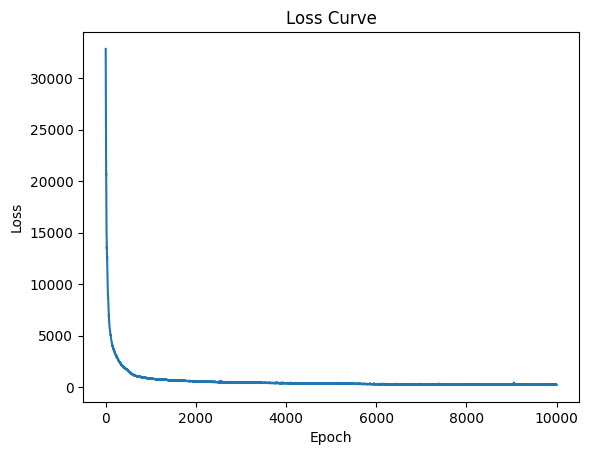

Training Accuracy: 1.0
Training Mean Absolute Error: 0.0
Training Mean Squared Error: 0.0
Training Quadratic Weighted Kappa: 1.0
Validation Accuracy: 0.48
Validation Mean Absolute Error: 0.699999988079071
Validation Mean Squared Error: 1.100000023841858
Validation Quadratic Weighted Kappa: 0.7146710935878813
--------------------------------------------------
Cross-Validation Performance Summary:
Average Training Accuracy: 1.0 ± 0.0
Average Validation Accuracy: 0.5599999999999999 ± 0.06995236474439825
Average Training MAE: 0.0 ± 0.0
Average Validation MAE: 0.621999979019165 ± 0.12428640574216843
Average Training MSE: 0.0 ± 0.0
Average Validation MSE: 1.1153333187103271 ± 0.395033597946167
Average Training Quadratic Weighted Kappa: 1.0 ± 0.0
Average Validation Quadratic Weighted Kappa: 0.7813983349253784 ± 0.08168382484988952


In [26]:
import numpy as np
import torch
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, cohen_kappa_score

X = data[:29, 51:61].astype(int)
X = np.delete(X, [17], axis=0)
cross_validate_VAE(X, VAE, num_inputs=10, num_neurons=128, num_latent=2, num_categories=5)


#### PNDs

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split

# CSV-Datei einlesen (angenommen, die Daten sind Komma-getrennt)
# Anpassen des Delimiters, falls die Daten Tab-getrennt sind: delimiter='\t'
data = np.genfromtxt('usability-data_disability_csv.csv', skip_header=1, delimiter=',')

X = data[30:, 51:61].astype(int)
print(X)
# Die Daten in Training und Validierung aufteilen (z.B. 80% Training, 20% Validierung)
X, X_val = train_test_split(X, test_size=0.2, random_state=42)
N, m = X.shape
print(X)

# Anzahl der Zeilen und Spalten ausgeben
print("number of rows: " + str(N))
print("number of columns: " + str(m))

[[1 0 3 0 3 1 3 1 2 1]
 [1 3 2 0 0 2 3 2 3 2]
 [0 1 0 4 1 3 2 4 2 1]
 [1 1 3 0 2 3 3 2 3 3]
 [2 0 4 1 4 0 4 1 3 2]
 [0 0 3 3 2 1 3 2 1 1]
 [0 2 0 2 2 2 0 4 0 3]
 [0 3 2 0 3 2 4 2 2 1]
 [1 0 0 0 1 0 1 2 1 0]
 [1 0 3 0 3 0 3 0 4 1]
 [0 0 4 2 3 1 3 2 1 0]
 [2 0 3 0 3 1 4 0 3 3]
 [2 0 4 0 3 0 4 1 4 0]
 [0 1 3 0 2 1 3 1 4 0]
 [0 1 1 0 0 4 1 4 0 3]
 [0 2 3 1 2 1 3 1 2 0]
 [0 1 3 1 2 3 4 1 2 1]
 [1 2 1 0 1 1 3 4 2 0]
 [0 2 3 0 1 2 3 4 3 0]
 [0 1 3 1 3 2 3 4 3 1]
 [0 1 3 2 2 1 2 3 1 1]
 [1 0 4 0 3 0 4 1 4 0]
 [0 3 1 4 1 4 0 3 0 2]
 [0 1 3 0 3 1 3 1 2 2]
 [0 3 0 0 1 3 1 4 0 4]
 [0 1 2 0 2 3 3 3 2 1]
 [1 1 2 0 1 2 3 1 2 0]
 [2 1 3 1 2 1 4 2 4 1]
 [0 0 2 1 3 1 4 1 2 0]
 [0 1 4 0 3 1 4 2 3 1]
 [1 2 3 2 3 2 3 1 3 3]
 [0 2 3 1 1 1 2 2 2 1]]
[[0 1 2 0 2 3 3 3 2 1]
 [2 0 4 0 3 0 4 1 4 0]
 [1 0 3 0 3 1 3 1 2 1]
 [2 0 4 1 4 0 4 1 3 2]
 [0 1 3 1 2 3 4 1 2 1]
 [0 0 3 3 2 1 3 2 1 1]
 [0 1 3 0 2 1 3 1 4 0]
 [2 0 3 0 3 1 4 0 3 3]
 [0 1 3 0 3 1 3 1 2 2]
 [1 3 2 0 0 2 3 2 3 2]
 [0 1 0 4 1 3 2 4 2 1]
 [1 1 2 0 

C:\Users\wuepp\AppData\Local\Temp\ipykernel_15468\3384498399.py:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)


Epoch 0, Loss: 3972.104736328125
Epoch 100, Loss: 3374.130859375
Epoch 200, Loss: 2994.809814453125
Epoch 300, Loss: 2626.9423828125
Epoch 400, Loss: 2266.23583984375
Epoch 500, Loss: 1908.06689453125
Epoch 600, Loss: 1600.6885986328125
Epoch 700, Loss: 1367.4200439453125
Epoch 800, Loss: 1137.148193359375
Epoch 900, Loss: 910.1539916992188
Epoch 1000, Loss: 711.2393188476562
Epoch 1100, Loss: 586.4343872070312
Epoch 1200, Loss: 472.8994445800781
Epoch 1300, Loss: 400.4529113769531
Epoch 1400, Loss: 356.2205810546875
Epoch 1500, Loss: 315.23919677734375
Epoch 1600, Loss: 300.0775146484375
Epoch 1700, Loss: 297.40435791015625
Epoch 1800, Loss: 296.4711608886719
Epoch 1900, Loss: 294.9431457519531
Epoch 2000, Loss: 291.8252258300781
Epoch 2100, Loss: 291.35723876953125
Epoch 2200, Loss: 289.8404846191406
Epoch 2300, Loss: 288.77886962890625
Epoch 2400, Loss: 287.418212890625
Epoch 2500, Loss: 285.5287170410156
Epoch 2600, Loss: 284.7647399902344
Epoch 2700, Loss: 283.90228271484375
Epoch

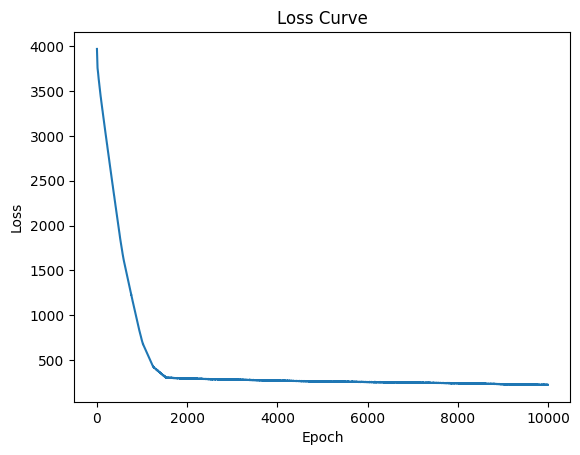

In [32]:
num_inputs = 10  # number of tasks
num_neurons = 128  # number of neurons in the hidden layer

num_latent = 2  # latent space dimension

model_pytorch = PC_IRT_AE(num_inputs=num_inputs, num_neurons=num_neurons, num_latent=num_latent, num_categories=5)

# Convert input to tensor
X_tensor = torch.tensor(X, dtype=torch.float)

# Train the model
model_pytorch.fit(X_tensor)

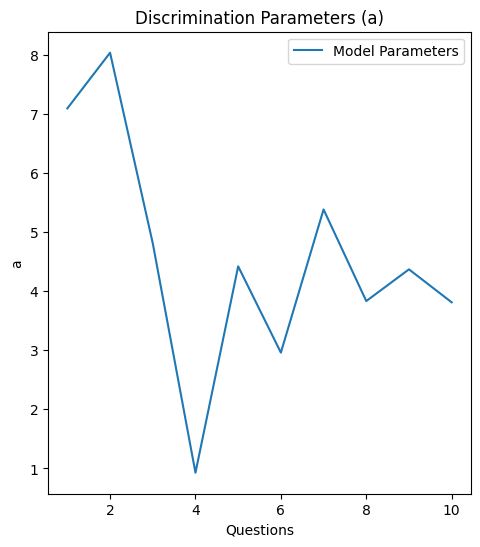

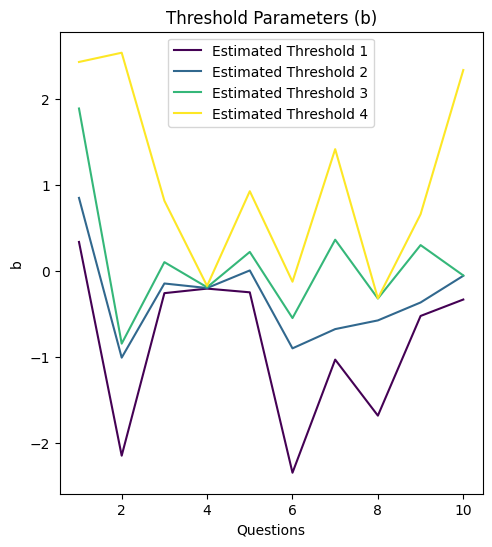

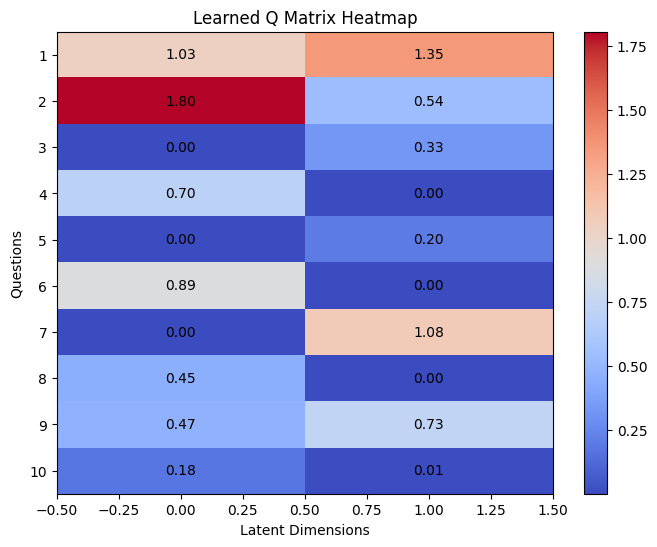

b values:
 [[ 0.3381236   0.85151345  1.8933004   2.4356072 ]
 [-2.1524842  -1.0099987  -0.8467751   2.5433545 ]
 [-0.25855786 -0.14597963  0.10281971  0.81796575]
 [-0.20566492 -0.19886819 -0.19016737 -0.17461596]
 [-0.24880028  0.0061213   0.22188827  0.929513  ]
 [-2.3512194  -0.9018444  -0.54887587 -0.12525472]
 [-1.0331731  -0.67750734  0.3642097   1.4195933 ]
 [-1.6859505  -0.576188   -0.3213002  -0.31918603]
 [-0.52428937 -0.36713     0.30150956  0.66121525]
 [-0.33282226 -0.05615159 -0.05237729  2.3417308 ]]
Differences (should be non-negative):
 []
a values (should be positive):
 [7.0937276  8.035618   4.810076   0.92695045 4.4202614  2.960013
 5.383011   3.8324785  4.369088   3.8113804 ]
Learned Q matrix:
 [[1.0331364e+00 1.3484296e+00]
 [1.8042170e+00 5.3728771e-01]
 [1.2222985e-03 3.2736811e-01]
 [7.0198643e-01 1.8695246e-03]
 [8.8747387e-05 1.9848612e-01]
 [8.9184070e-01 2.9534088e-03]
 [4.4537303e-03 1.0773526e+00]
 [4.5106709e-01 4.2940205e-04]
 [4.6928617e-01 7.3031926e

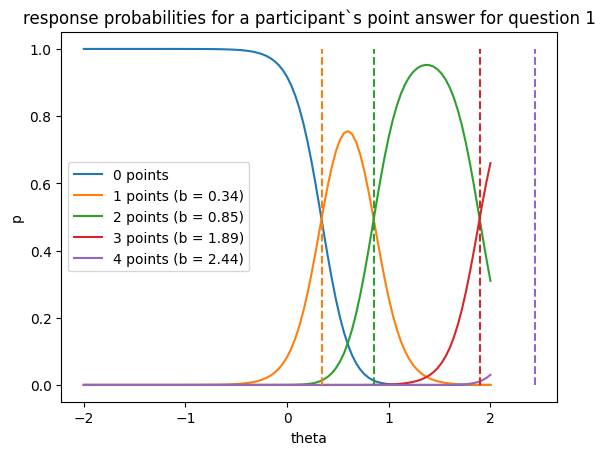

Accuracy: 0.64
Mean Absolute Error: 0.45199999999999996
Mean Squared Error: 0.6759999999999999
Quadratic Weighted Kappa: 0.8050173984475232
Validation Accuracy: 0.4142857142857143
Validation Mean Absolute Error: 0.7285714285714285
Validation Mean Squared Error: 1.1285714285714286
Validation Quadratic Weighted Kappa: 0.6808265035207203


In [33]:
# Extracting model parameters
diffs = model_pytorch.b[:, 1:] - model_pytorch.b[:, :-1]
b_values = model_pytorch.b.detach().numpy()
a_values = model_pytorch.a.detach().numpy()

# Comparing the discrimination parameters (a)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title('Discrimination Parameters (a)')
plt.plot(np.arange(1, len(a_values) + 1), a_values, label='Model Parameters')  # Shift task index to start from 1
plt.ylabel('a')
plt.xlabel('Questions')
plt.legend()

# Erstelle eine Liste von Farben für die Parameter
colors = plt.cm.viridis(np.linspace(0, 1, b_values.shape[1]))  # z.B. "viridis" Farbschema

plt.figure(figsize=(12, 6))

# Comparing the threshold parameters (b)
plt.subplot(1, 2, 2)
plt.title('Threshold Parameters (b)')

# Plotte die echten und geschätzten Werte mit gleichen Farben
for j in range(b_values.shape[1]):  # Für jede Spalte (Parameter)
    plt.plot(np.arange(1, len(b_values) + 1), b_values[:, j], label=f'Estimated Threshold {j + 1}', color=colors[j])  # Shift task index to start from 1

plt.ylabel('b')
plt.xlabel('Questions')
plt.legend()

plt.show()


learned_Q = model_pytorch.Q.detach().numpy()


learned_Q_transposed = learned_Q.T


# Heatmap erstellen
plt.figure(figsize=(8, 6))
plt.imshow(learned_Q_transposed, cmap='coolwarm', aspect='auto')

# Colorbar hinzufügen
plt.colorbar()

# Achsenbeschriftungen und Titel
plt.title('Learned Q Matrix Heatmap')
plt.xlabel('Latent Dimensions')
plt.ylabel('Questions')

# Set y-ticks to start from 1 instead of 0
plt.yticks(np.arange(learned_Q_transposed.shape[0]), np.arange(1, learned_Q_transposed.shape[0] + 1))

# Zahlenwerte in die Heatmap einfügen
for i in range(learned_Q_transposed.shape[0]):
    for j in range(learned_Q_transposed.shape[1]):
        plt.text(j, i, f'{learned_Q_transposed[i, j]:.2f}', ha='center', va='center', color='black')

# Heatmap anzeigen
plt.show()



neg_diffs = diffs[diffs < 0]

print("b values:\n", b_values)
print("Differences (should be non-negative):\n", neg_diffs.detach().numpy())
print("a values (should be positive):\n", a_values)

print("Learned Q matrix:\n", learned_Q_transposed)

def compute_probabilities_for_theta(model, theta_range):
    probabilities = []

    # Loop through each theta value in the specified range
    for theta_val in theta_range:
        # Create a single latent vector for decoding (shape: (1, num_latent))
        theta_tensor = torch.tensor([[0, theta_val]], dtype=torch.float)
        # Get the probabilities from the model for this theta value
        with torch.no_grad():  # Disable gradient tracking
            Y = model.decode(theta_tensor)  # Forward pass with only theta
        probabilities.append(Y.numpy())

    probabilities = np.array(probabilities)

    # Remove the unnecessary '1' dimension
    probabilities = np.squeeze(probabilities, axis=1)  # Shape becomes (100, 7, 4)

    return probabilities



import numpy as np
import matplotlib.pyplot as plt

task = 0

theta_values = np.linspace(-2, 2, 101)
bs = b_values[task, :]
a = a_values[task]

M = len(bs) + 1
N = len(theta_values)

# compute logits
Z = np.zeros((N, M))
Z[:, 1:] = a * (np.expand_dims(theta_values, 1) - np.expand_dims(bs, 0))
Z = np.cumsum(Z, axis=1)

# compute probabilities
P = np.exp(Z) / np.expand_dims(np.sum(np.exp(Z), axis=1), 1)

# Plot the probabilities and store the plot objects
lines = []
for i in range(M):
    line, = plt.plot(theta_values, P[:, i], label=f'{i} points')
    lines.append(line)

plt.xlabel('theta')
plt.ylabel('p')
plt.title(f'response probabilities for a participant`s point answer for question {task + 1}')

legend_entries = ['0 points ']
for j in range(M - 1):
    legend_entries.append(f'{j + 1} points (b = {bs[j]:.2f})')

# Plot vertical lines (thresholds) in the same color as the corresponding probabilities
for j in range(M - 1):
    plt.plot([bs[j], bs[j]], [0, 1], linestyle='--', color=lines[j + 1].get_color())  # Use the color of the corresponding probability curve

plt.legend(legend_entries)
plt.show()


# Make predictions
_, _, _, Xhat_tensor = model_pytorch.forward(X_tensor)

# Convert probabilities to predicted categories
Xhat = torch.argmax(Xhat_tensor, dim=-1).detach().numpy()

#print(X_tensor[0])
#print(Xhat[0])

# Calculate accuracy
accuracy = np.mean(X_tensor.numpy() == Xhat)
print(f"Accuracy: {accuracy}")

# Make predictions on validation set

X_val_tensor = torch.tensor(X_val, dtype=torch.float)
_, _, _, Xhat_val_tensor = model_pytorch.forward(X_val_tensor)

# Convert probabilities to predicted categories for validation set
Xhat_val = torch.argmax(Xhat_val_tensor, dim=-1).detach().numpy()

#print(X_tensor[0])
#print(Xhat[0])

from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(X_tensor.numpy(), Xhat)
print(f"Mean Absolute Error: {mae}")

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(X_tensor.numpy(), Xhat)
print(f"Mean Squared Error: {mse}")


from sklearn.metrics import cohen_kappa_score
X_tensor_flat = X_tensor.numpy().ravel()
X_hat_flat = Xhat.ravel()

# Berechne den quadratisch gewichteten Kappa
kappa = cohen_kappa_score(X_tensor_flat, X_hat_flat, weights='quadratic')
print(f"Quadratic Weighted Kappa: {kappa}")

# Calculate accuracy for validation set
accuracy_val = np.mean(X_val_tensor.numpy() == Xhat_val)
print(f"Validation Accuracy: {accuracy_val}")

# Mean Absolute Error for validation set
mae_val = mean_absolute_error(X_val_tensor.numpy(), Xhat_val)
print(f"Validation Mean Absolute Error: {mae_val}")

# Mean Squared Error for validation set
mse_val = mean_squared_error(X_val_tensor.numpy(), Xhat_val)
print(f"Validation Mean Squared Error: {mse_val}")

# Flatten the tensors for Kappa calculation
X_val_tensor_flat = X_val_tensor.numpy().ravel()
X_hat_val_flat = Xhat_val.ravel()

# Quadratic Weighted Kappa for validation set
kappa_val = cohen_kappa_score(X_val_tensor_flat, X_hat_val_flat, weights='quadratic')
print(f"Validation Quadratic Weighted Kappa: {kappa_val}")

#print(Xhat)

C:\Users\wuepp\AppData\Local\Temp\ipykernel_15468\3702903398.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)


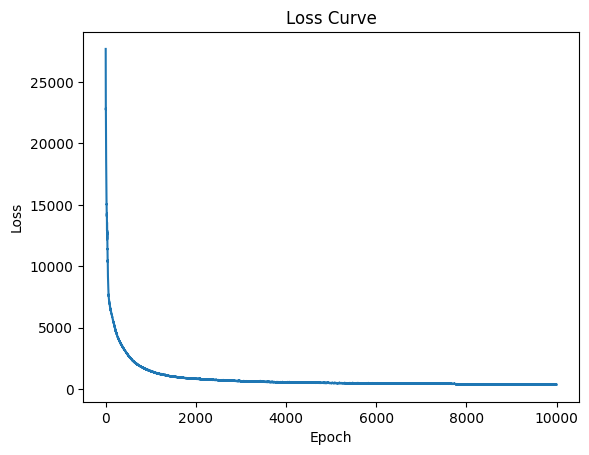

Accuracy: 0.996
Mean Absolute Error: 0.003999999724328518
Mean Squared Error: 0.003999999724328518
Quadratic Weighted Kappa: 0.9988334655405721
Validation Accuracy: 0.37142857142857144
Validation Mean Absolute Error: 0.8999999761581421
Validation Mean Squared Error: 1.5571428537368774
Validation Quadratic Weighted Kappa: 0.5511236616072479


In [34]:
num_inputs = 10  # number of tasks
num_neurons = 128  # number of neurons in the hidden layer
num_latent = 2  # latent space dimension
num_categories = 5

model_pytorch = VAE(num_inputs=num_inputs, num_neurons=num_neurons, num_latent=num_latent, num_categories=num_categories)

# Convert input to tensor
X_tensor = torch.tensor(X, dtype=torch.float)

# Train the model
model_pytorch.fit(X_tensor)

# Make predictions
_, _, _, Xhat_tensor = model_pytorch.forward(X_tensor)

# Convert predictions to integer values
Xhat = Xhat_tensor.round().detach().numpy()

# Calculate accuracy
accuracy = np.mean(X_tensor.numpy() == Xhat)
print(f"Accuracy: {accuracy}")

# Make predictions on validation set
X_val_tensor = torch.tensor(X_val, dtype=torch.float)
_, _, _, Xhat_val_tensor = model_pytorch.forward(X_val_tensor)

# Convert probabilities to predicted categories for validation set
Xhat_val = Xhat_val_tensor.round().detach().numpy()

from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(X_tensor.numpy(), Xhat)
print(f"Mean Absolute Error: {mae}")

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(X_tensor.numpy(), Xhat)
print(f"Mean Squared Error: {mse}")


from sklearn.metrics import cohen_kappa_score
X_tensor_flat = X_tensor.numpy().ravel()
X_hat_flat = Xhat.ravel()

# Berechne den quadratisch gewichteten Kappa
kappa = cohen_kappa_score(X_tensor_flat, X_hat_flat, weights='quadratic')
print(f"Quadratic Weighted Kappa: {kappa}")

# Calculate accuracy for validation set
accuracy_val = np.mean(X_val_tensor.numpy() == Xhat_val)
print(f"Validation Accuracy: {accuracy_val}")

# Mean Absolute Error for validation set
mae_val = mean_absolute_error(X_val_tensor.numpy(), Xhat_val)
print(f"Validation Mean Absolute Error: {mae_val}")

# Mean Squared Error for validation set
mse_val = mean_squared_error(X_val_tensor.numpy(), Xhat_val)
print(f"Validation Mean Squared Error: {mse_val}")

# Flatten the tensors for Kappa calculation
X_val_tensor_flat = X_val_tensor.numpy().ravel()
X_hat_val_flat = Xhat_val.ravel()

# Quadratic Weighted Kappa for validation set
kappa_val = cohen_kappa_score(X_val_tensor_flat, X_hat_val_flat, weights='quadratic')
print(f"Validation Quadratic Weighted Kappa: {kappa_val}")


Cross-validation for fold: 1
Epoch 0, Loss: 3553.205322265625


C:\Users\wuepp\AppData\Local\Temp\ipykernel_15468\3384498399.py:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)


Epoch 100, Loss: 2966.2177734375
Epoch 200, Loss: 2643.134033203125
Epoch 300, Loss: 2353.09716796875
Epoch 400, Loss: 2067.05419921875
Epoch 500, Loss: 1789.03271484375
Epoch 600, Loss: 1514.885009765625
Epoch 700, Loss: 1272.9962158203125
Epoch 800, Loss: 1081.47021484375
Epoch 900, Loss: 931.6233520507812
Epoch 1000, Loss: 816.8804931640625
Epoch 1100, Loss: 737.96826171875
Epoch 1200, Loss: 659.8004150390625
Epoch 1300, Loss: 584.6511840820312
Epoch 1400, Loss: 546.58056640625
Epoch 1500, Loss: 510.4635314941406
Epoch 1600, Loss: 475.66937255859375
Epoch 1700, Loss: 442.0993347167969
Epoch 1800, Loss: 407.80560302734375
Epoch 1900, Loss: 373.2896423339844
Epoch 2000, Loss: 340.9294128417969
Epoch 2100, Loss: 307.81256103515625
Epoch 2200, Loss: 293.5013427734375
Epoch 2300, Loss: 290.85791015625
Epoch 2400, Loss: 289.3979187011719
Epoch 2500, Loss: 286.8375549316406
Epoch 2600, Loss: 284.2852478027344
Epoch 2700, Loss: 282.18548583984375
Epoch 2800, Loss: 280.17694091796875
Epoch 2

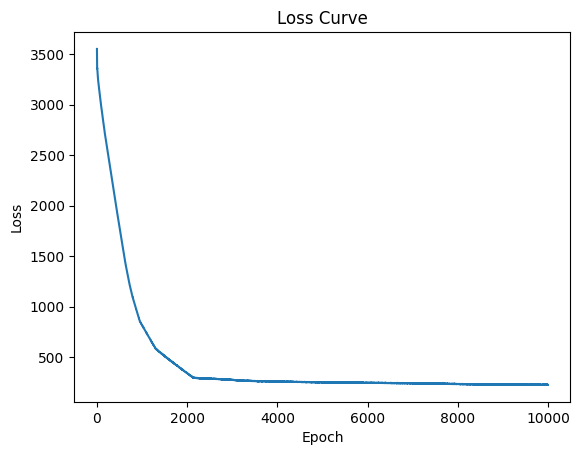

Training Accuracy: 0.644
Training Mean Absolute Error: 0.48
Training Mean Squared Error: 0.792
Training Quadratic Weighted Kappa: 0.78897197377284
Validation Accuracy: 0.45714285714285713
Validation Mean Absolute Error: 0.6714285714285715
Validation Mean Squared Error: 0.9857142857142855
Validation Quadratic Weighted Kappa: 0.7361520812848247
--------------------------------------------------
Cross-validation for fold: 2
Epoch 0, Loss: 4939.333984375


C:\Users\wuepp\AppData\Local\Temp\ipykernel_15468\3384498399.py:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)


Epoch 100, Loss: 4168.875
Epoch 200, Loss: 3690.45703125
Epoch 300, Loss: 3214.565185546875
Epoch 400, Loss: 2822.29052734375
Epoch 500, Loss: 2473.9501953125
Epoch 600, Loss: 2183.029541015625
Epoch 700, Loss: 1914.051025390625
Epoch 800, Loss: 1682.37744140625
Epoch 900, Loss: 1459.99951171875
Epoch 1000, Loss: 1239.5528564453125
Epoch 1100, Loss: 1020.4225463867188
Epoch 1200, Loss: 825.3026123046875
Epoch 1300, Loss: 670.061279296875
Epoch 1400, Loss: 591.8868408203125
Epoch 1500, Loss: 512.1251220703125
Epoch 1600, Loss: 438.77044677734375
Epoch 1700, Loss: 372.9116516113281
Epoch 1800, Loss: 340.4744873046875
Epoch 1900, Loss: 319.8414001464844
Epoch 2000, Loss: 318.4665832519531
Epoch 2100, Loss: 317.28448486328125
Epoch 2200, Loss: 315.52423095703125
Epoch 2300, Loss: 314.77935791015625
Epoch 2400, Loss: 311.7464294433594
Epoch 2500, Loss: 310.53912353515625
Epoch 2600, Loss: 309.4294738769531
Epoch 2700, Loss: 309.1441650390625
Epoch 2800, Loss: 308.0227966308594
Epoch 2900, L

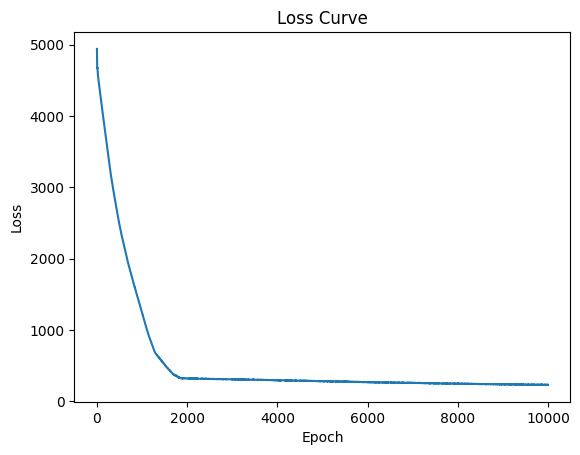

Training Accuracy: 0.608
Training Mean Absolute Error: 0.512
Training Mean Squared Error: 0.8479999999999999
Training Quadratic Weighted Kappa: 0.7724618766314054
Validation Accuracy: 0.5
Validation Mean Absolute Error: 0.6
Validation Mean Squared Error: 0.8571428571428571
Validation Quadratic Weighted Kappa: 0.7796432318992654
--------------------------------------------------
Cross-validation for fold: 3
Epoch 0, Loss: 3995.033447265625


C:\Users\wuepp\AppData\Local\Temp\ipykernel_15468\3384498399.py:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)


Epoch 100, Loss: 3082.8076171875
Epoch 200, Loss: 2624.59130859375
Epoch 300, Loss: 2168.109375
Epoch 400, Loss: 1785.4501953125
Epoch 500, Loss: 1465.9788818359375
Epoch 600, Loss: 1194.47509765625
Epoch 700, Loss: 991.563720703125
Epoch 800, Loss: 834.6552124023438
Epoch 900, Loss: 696.144287109375
Epoch 1000, Loss: 620.3453369140625
Epoch 1100, Loss: 577.0830078125
Epoch 1200, Loss: 533.6397705078125
Epoch 1300, Loss: 492.0854797363281
Epoch 1400, Loss: 448.0400695800781
Epoch 1500, Loss: 406.0294189453125
Epoch 1600, Loss: 361.5970764160156
Epoch 1700, Loss: 319.3699035644531
Epoch 1800, Loss: 300.0128479003906
Epoch 1900, Loss: 297.5110778808594
Epoch 2000, Loss: 295.4258117675781
Epoch 2100, Loss: 293.12628173828125
Epoch 2200, Loss: 291.333984375
Epoch 2300, Loss: 289.86431884765625
Epoch 2400, Loss: 287.7874755859375
Epoch 2500, Loss: 286.8009948730469
Epoch 2600, Loss: 284.8442077636719
Epoch 2700, Loss: 283.88348388671875
Epoch 2800, Loss: 282.2269592285156
Epoch 2900, Loss: 

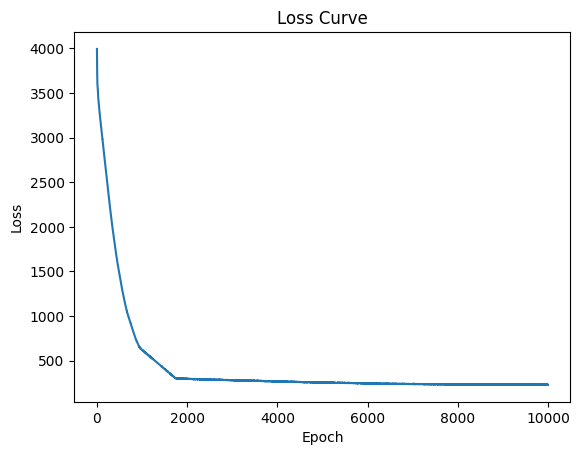

Training Accuracy: 0.6192307692307693
Training Mean Absolute Error: 0.473076923076923
Training Mean Squared Error: 0.6807692307692308
Training Quadratic Weighted Kappa: 0.8220692854933498
Validation Accuracy: 0.4666666666666667
Validation Mean Absolute Error: 0.7666666666666666
Validation Mean Squared Error: 1.3
Validation Quadratic Weighted Kappa: 0.5772357723577235
--------------------------------------------------
Cross-validation for fold: 4
Epoch 0, Loss: 3484.35791015625


C:\Users\wuepp\AppData\Local\Temp\ipykernel_15468\3384498399.py:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)


Epoch 100, Loss: 2993.690673828125
Epoch 200, Loss: 2594.26708984375
Epoch 300, Loss: 2217.93701171875
Epoch 400, Loss: 1852.018310546875
Epoch 500, Loss: 1563.4552001953125
Epoch 600, Loss: 1324.8726806640625
Epoch 700, Loss: 1090.9046630859375
Epoch 800, Loss: 859.2382202148438
Epoch 900, Loss: 673.0742797851562
Epoch 1000, Loss: 550.9967651367188
Epoch 1100, Loss: 444.5409240722656
Epoch 1200, Loss: 394.2853088378906
Epoch 1300, Loss: 357.47259521484375
Epoch 1400, Loss: 322.11334228515625
Epoch 1500, Loss: 296.2523498535156
Epoch 1600, Loss: 294.88409423828125
Epoch 1700, Loss: 292.2548522949219
Epoch 1800, Loss: 289.4229736328125
Epoch 1900, Loss: 287.7048034667969
Epoch 2000, Loss: 286.5531921386719
Epoch 2100, Loss: 284.3706970214844
Epoch 2200, Loss: 283.8207702636719
Epoch 2300, Loss: 283.3907470703125
Epoch 2400, Loss: 280.99139404296875
Epoch 2500, Loss: 280.23321533203125
Epoch 2600, Loss: 279.5025634765625
Epoch 2700, Loss: 278.3179626464844
Epoch 2800, Loss: 277.909454345

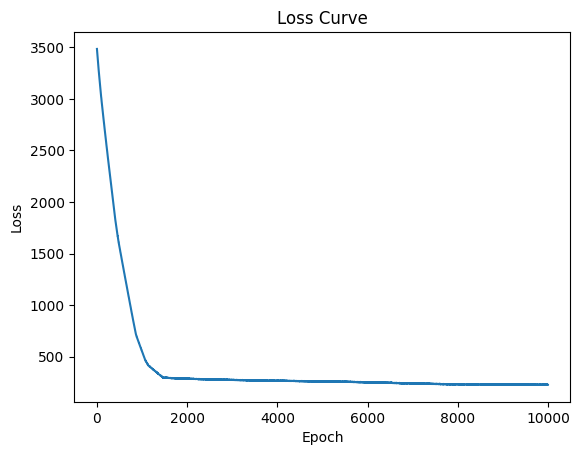

Training Accuracy: 0.6461538461538462
Training Mean Absolute Error: 0.44230769230769235
Training Mean Squared Error: 0.6346153846153847
Training Quadratic Weighted Kappa: 0.8091772827556758
Validation Accuracy: 0.43333333333333335
Validation Mean Absolute Error: 0.6666666666666666
Validation Mean Squared Error: 0.8666666666666666
Validation Quadratic Weighted Kappa: 0.7683741648106904
--------------------------------------------------
Cross-validation for fold: 5
Epoch 0, Loss: 4204.5908203125


C:\Users\wuepp\AppData\Local\Temp\ipykernel_15468\3384498399.py:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)


Epoch 100, Loss: 3721.801513671875
Epoch 200, Loss: 3346.7509765625
Epoch 300, Loss: 3031.50634765625
Epoch 400, Loss: 2739.661865234375
Epoch 500, Loss: 2460.12744140625
Epoch 600, Loss: 2250.901611328125
Epoch 700, Loss: 2050.919921875
Epoch 800, Loss: 1851.824951171875
Epoch 900, Loss: 1653.0784912109375
Epoch 1000, Loss: 1458.0673828125
Epoch 1100, Loss: 1284.60888671875
Epoch 1200, Loss: 1152.223876953125
Epoch 1300, Loss: 1028.9781494140625
Epoch 1400, Loss: 912.875
Epoch 1500, Loss: 818.9447021484375
Epoch 1600, Loss: 745.8584594726562
Epoch 1700, Loss: 674.0281982421875
Epoch 1800, Loss: 631.8894653320312
Epoch 1900, Loss: 590.5753784179688
Epoch 2000, Loss: 549.6372680664062
Epoch 2100, Loss: 508.1689147949219
Epoch 2200, Loss: 466.4781188964844
Epoch 2300, Loss: 425.5257873535156
Epoch 2400, Loss: 384.867431640625
Epoch 2500, Loss: 343.347900390625
Epoch 2600, Loss: 301.4239807128906
Epoch 2700, Loss: 290.499267578125
Epoch 2800, Loss: 288.48846435546875
Epoch 2900, Loss: 287

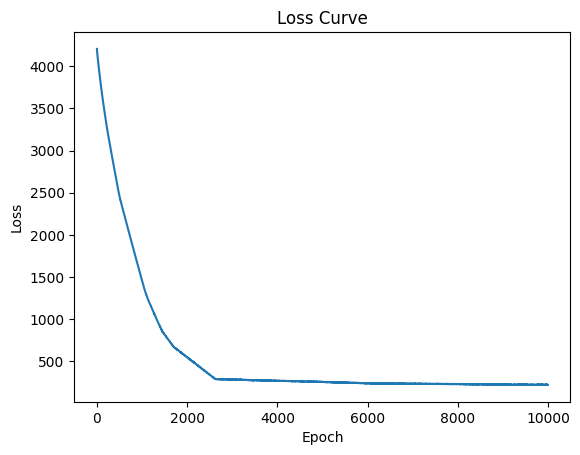

Training Accuracy: 0.6538461538461539
Training Mean Absolute Error: 0.4384615384615384
Training Mean Squared Error: 0.6538461538461539
Training Quadratic Weighted Kappa: 0.7976394319253555
Validation Accuracy: 0.4
Validation Mean Absolute Error: 0.7666666666666666
Validation Mean Squared Error: 1.1666666666666665
Validation Quadratic Weighted Kappa: 0.6408414571575167
--------------------------------------------------
Cross-Validation Performance Summary:
Average Training Accuracy: 0.6342461538461539 ± 0.017523772526208396
Average Validation Accuracy: 0.4514285714285714 ± 0.03345555822904817
Average Training MAE: 0.46916923076923067 ± 0.026950157808761716
Average Validation MAE: 0.6942857142857142 ± 0.06426983930972566
Average Training MSE: 0.7218461538461538 ± 0.08337490718393026
Average Validation MSE: 1.035238095238095 ± 0.17318151383647704
Average Training Quadratic Weighted Kappa: 0.7980639701157253 ± 0.01695920225226691
Average Validation Quadratic Weighted Kappa: 0.7004493415020

In [35]:
import numpy as np
import torch
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, cohen_kappa_score

X = data[30:, 51:61].astype(int)

cross_validate_PC_VAE(X, PC_IRT_AE, num_inputs=10, num_neurons=128, num_latent=2, num_categories=5)

Cross-validation for fold: 1


C:\Users\wuepp\AppData\Local\Temp\ipykernel_15468\3702903398.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)


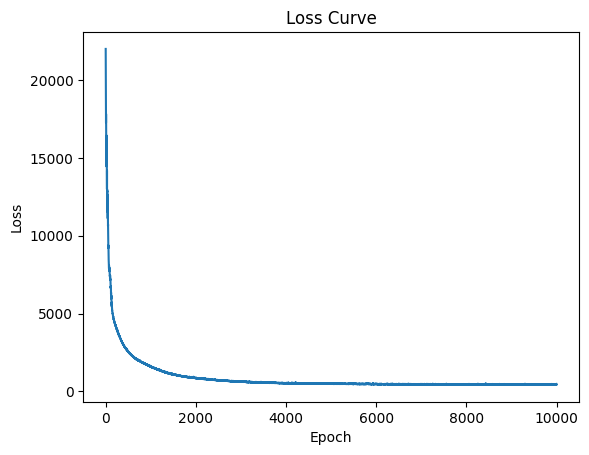

Training Accuracy: 0.988
Training Mean Absolute Error: 0.012000000104308128
Training Mean Squared Error: 0.012000000104308128
Training Quadratic Weighted Kappa: 0.9965201414214526
Validation Accuracy: 0.38571428571428573
Validation Mean Absolute Error: 0.7714285850524902
Validation Mean Squared Error: 1.1428570747375488
Validation Quadratic Weighted Kappa: 0.6725529177873932
--------------------------------------------------
Cross-validation for fold: 2


C:\Users\wuepp\AppData\Local\Temp\ipykernel_15468\3702903398.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)


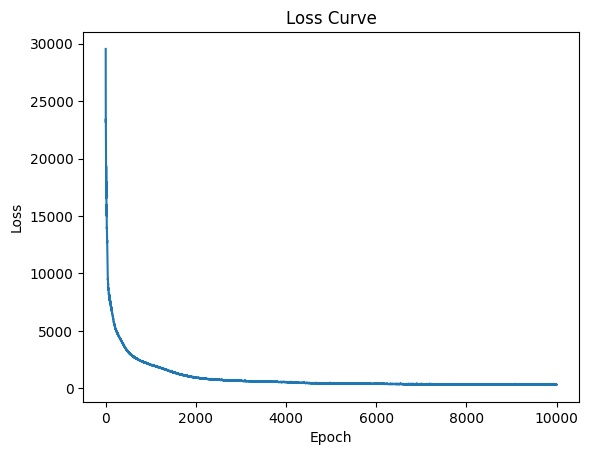

Training Accuracy: 1.0
Training Mean Absolute Error: 0.0
Training Mean Squared Error: 0.0
Training Quadratic Weighted Kappa: 1.0
Validation Accuracy: 0.5142857142857142
Validation Mean Absolute Error: 0.6428571939468384
Validation Mean Squared Error: 0.9857142567634583
Validation Quadratic Weighted Kappa: 0.7312186978297162
--------------------------------------------------
Cross-validation for fold: 3


C:\Users\wuepp\AppData\Local\Temp\ipykernel_15468\3702903398.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)


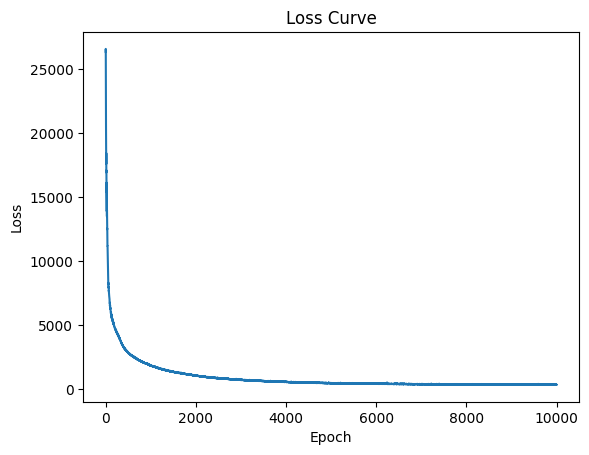

Training Accuracy: 1.0
Training Mean Absolute Error: 0.0
Training Mean Squared Error: 0.0
Training Quadratic Weighted Kappa: 1.0
Validation Accuracy: 0.2833333333333333
Validation Mean Absolute Error: 1.0
Validation Mean Squared Error: 1.7000000476837158
Validation Quadratic Weighted Kappa: 0.44109589041095887
--------------------------------------------------
Cross-validation for fold: 4


C:\Users\wuepp\AppData\Local\Temp\ipykernel_15468\3702903398.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)


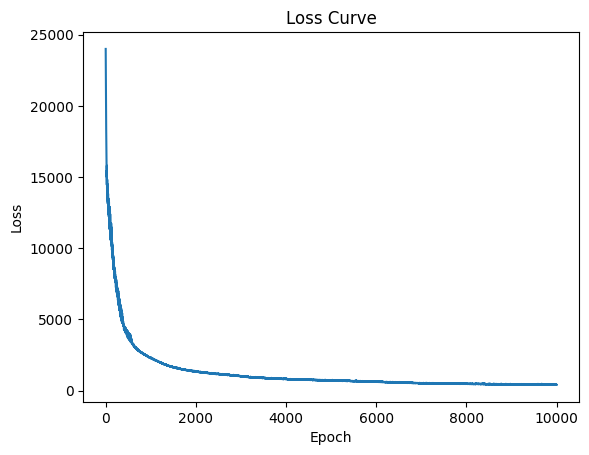

Training Accuracy: 0.9961538461538462
Training Mean Absolute Error: 0.0038461540825664997
Training Mean Squared Error: 0.0038461540825664997
Training Quadratic Weighted Kappa: 0.9988815664951736
Validation Accuracy: 0.5
Validation Mean Absolute Error: 0.6833332777023315
Validation Mean Squared Error: 1.0833332538604736
Validation Quadratic Weighted Kappa: 0.7161572052401746
--------------------------------------------------
Cross-validation for fold: 5


C:\Users\wuepp\AppData\Local\Temp\ipykernel_15468\3702903398.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)


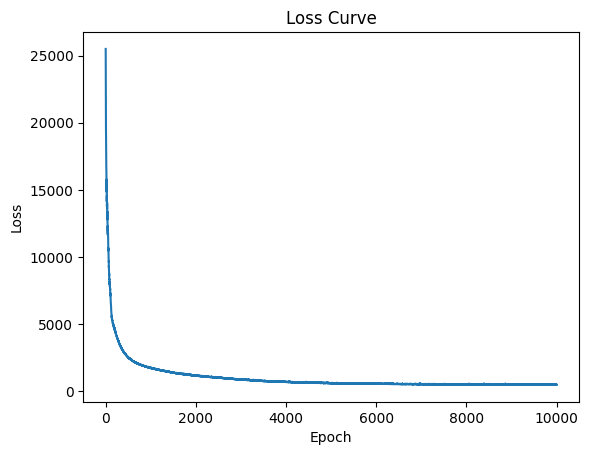

Training Accuracy: 0.9846153846153847
Training Mean Absolute Error: 0.015384616330265999
Training Mean Squared Error: 0.015384616330265999
Training Quadratic Weighted Kappa: 0.9954867771249034
Validation Accuracy: 0.4
Validation Mean Absolute Error: 0.8999999761581421
Validation Mean Squared Error: 1.5333333015441895
Validation Quadratic Weighted Kappa: 0.5318066157760815
--------------------------------------------------
Cross-Validation Performance Summary:
Average Training Accuracy: 0.9937538461538462 ± 0.0063309888736549705
Average Validation Accuracy: 0.41666666666666663 ± 0.08424669529978157
Average Training MAE: 0.006246154196560383 ± 0.006330989301204681
Average Validation MAE: 0.7995238304138184 ± 0.1335066854953766
Average Training MSE: 0.006246154196560383 ± 0.006330989301204681
Average Validation MSE: 1.2890474796295166 ± 0.2772214114665985
Average Training Quadratic Weighted Kappa: 0.9981776970083059 ± 0.0018507052160739849
Average Validation Quadratic Weighted Kappa: 0.61

In [36]:
import numpy as np
import torch
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, cohen_kappa_score

X = data[30:, 51:61].astype(int)

cross_validate_VAE(X, VAE, num_inputs=10, num_neurons=128, num_latent=2, num_categories=5)